## Preprocess the data and get adjacency matrix 

In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(1, parent_dir+'\Covariance and Adjacency Matrix')
from DataManager import dataManager

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------


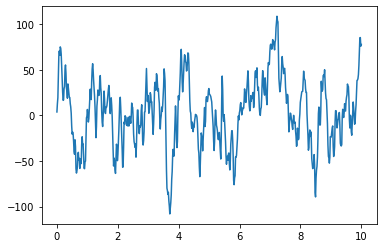

In [2]:
import h5py
import numpy as np
filepath = parent_dir+'\datasets\sample_patients\pat_FR_620.mat'
variables = {}
f = h5py.File(filepath, 'r')
for k, v in f.items():
    variables[k] = np.array(v)
for key in variables.keys():
    print("name:", key)
    print("shape:", variables[key].shape)
    print("-----------------------")
#print sample EGG signal from one node
import matplotlib.pyplot as plt

plt.figure()
ax = plt.axes()
X_train = variables["X_train"]
X_test = variables["X_test"]

ax.plot(np.linspace(0, 10, 640), X_train[:,5,0])

In [ ]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))
#dm.normalize()
#dm.sanity_check(4.514*10**-1, -10**-3, parent_dir)

## create normalized adjacency matrix 

In [ ]:
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
def show_heat_map(m):
    plt.imshow(m, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()
    
    
def create_DAD(adj):
    np.fill_diagonal(adj, 1)
    rowsum = np.sum(adj, axis=1)
    d = np.diag_indices(adj.shape[0]) 
    D = np.zeros(adj.shape)
    D[d] = rowsum
    #print(rowsum)
    D = fractional_matrix_power(D, -0.5)
    #print(D)
    return D@adj@D

In [ ]:
'''#first fine tune a good threshold n
n = 2*10**-4

#create DAD based on a choice
Ptemp = np.load("sample_Pinv.npy")
Araw = Ptemp > n
show_heat_map(Araw)
show_heat_map(create_DAD(Araw))
'''

#create DAD from dm
n = 2*10**-4
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train

## Modified GCN Class

In [ ]:
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(GCN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.weight = nn.Parameter(torch.Tensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        
        self.reset_parameters()

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ',' \
               + str(self.out_features) + ')'
    
    def reset_parameters(self):
        stdv = 1. / self.weight.size(1) ** 1/2
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
    
    # H, feature matrix
    # A, precomputed adj matrix
    def forward(self, H, A):
        n = torch.matmul(A, torch.matmul(H, self.weight))
        if self.bias is not None:
            return n + self.bias
        else:
            return n

class SimularityMatrix(nn.Module):
    def __init__(self, in_features):
        super(SimularityMatrix, self).__init__()
        self.in_features = in_features
        
        self.weight = nn.Parameter(torch.Tensor(in_features))
        #self.weight = torch.squeeze(self.weight)
        
        self.reset_parameters()

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) +')'
    
    def reset_parameters(self):
        stdv = 1. / self.weight.size(0) ** 1/2
        self.weight.data.uniform_(-stdv, stdv)
    
    #computes the simularity matrix:
    # H, feature matrix --> N x D
    # A, precomputed adj matrix --> NxN
    # this method is pretty wack, need to find a vectorized way to do it.
    def forward(self, H, H0):
        #get hidden state (concate H0 and H)
        Z = torch.cat((H0, H), 2)
        M = Z.shape[0]
        N = Z.shape[1]
        D = Z.shape[2]
        #centering normalize Z
        Z = self.fcn(Z)
        return self.get_sim_vectorized(Z)
        '''
        sim_matrix = torch.zeros(M ,N, N)
        for u in range(N):
            for v in range(N):
                if u>v:
                    zu = torch.reshape(Z[:,u,:], (M,1,D))
                    zv = torch.reshape(Z[:,v,:], (M,1,D))
                    sim_matrix[:,u,v] = self.get_sim(zu, zv)
                    sim_matrix[:,v,u] = sim_matrix[:,u,v]
                elif u==v:    
                    zu = torch.reshape(Z[:,u,:], (M,1,D))
                    a = self.get_sim(zu, zu)
                    #print(a.shape, sim_matrix.shape)
                    sim_matrix[:,u,v] = a
        return sim_matrix
        '''
        
    #simularity between node u and node v (shape Mx1xD)
    #return the u,v index of the simularity matrix
    def get_sim(self, u,v):
        theta = torch.diag(self.weight)
        #print(self.weight)
        #print(u.shape, theta.shape, self.weight.shape, torch.transpose(v, 1, 2).shape)
        return torch.squeeze(torch.matmul(torch.matmul(u, theta), torch.transpose(v, 1, 2)))
        
    def get_sim_vectorized(self, Z): # Z is M x N x 2D
        theta = torch.diag(self.weight)
        sim_matrix = torch.matmul(torch.matmul(Z, theta), torch.transpose(Z, 1, 2))
        return sim_matrix
        
    #centering-normalizing (CN) operator
    def fcn(self, Z):
        norm_Z = (Z - torch.mean(Z, dim=2, keepdim=True))
        return norm_Z/torch.std(Z, unbiased=True, dim=2, keepdim=True)
        #(((1/(self.in_features-1)) * torch.sum(norm_Z**2, dim = 2, keepdim = True))**(1/2))

In [ ]:
# n-layer GCN Network
class Net(nn.Module):
    def __init__(self, body_features, n_layers, activation = F.relu, bias=False):
        super(Net, self).__init__()
        assert(n_layers >= 1)
        self.activation = activation
        self.head = GCN(body_features, body_features, bias)
        self.layers = nn.ModuleList()
        for i in range(n_layers - 1):
            self.layers.append(GCN(body_features, body_features, bias))
        self.tail = SimularityMatrix(body_features*2) # size(H_0 + h_u)

    def forward(self, h_0, A):
        x = self.activation(self.head(h_0, A))
        for layer in self.layers:
            x = self.activation(layer(x, A))
        sim_matrix = self.tail(x, h_0)
        return sim_matrix

In [ ]:
class sim_loss(torch.nn.Module):

    def __init__(self):
        super(sim_loss,self).__init__()

    def forward(self, sim_matrix, A, epsilon = 1e-8):
        A_tf = (A!=0)
        M = sim_matrix.shape[0]
        abs_N = torch.sum(A_tf, dim = 1, keepdim = True) # Nx1 matrix
        
        logexp_S = torch.log(torch.sum(torch.exp(sim_matrix), dim = 2, keepdim = True))
        
        
        obj_vector = (torch.sum(A_tf*sim_matrix, dim = 2, keepdim = True) - abs_N * logexp_S)
        return -(1/M)*torch.sum(obj_vector)

In [ ]:
#save & load checkpoint
import shutil
from torchsummary import summary
from tqdm import tqdm
def save_ckp(state, f_path):
    torch.save(state, f_path)
    print("model saved")
    
def load_ckp(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    return checkpoint

# takes in numpy arrays
def train_GCN(A, X_train, X_test, checkpoint, load = False, print_summary = True):
    #preprocess inputs
    A = torch.from_numpy(A).float()
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    parameters = checkpoint['parameters']
    cumepoch = 0
    A = A.to(device)
    input_features = X_train.to(device)
    valid_features = X_test.to(device)
    
    #initialize model
    model = Net(parameters['body'], parameters['n_layers'], F.relu, bias=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'])
    criterion = sim_loss()
    
    #load past checkpoint if any
    if load:
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        cumepoch = checkpoint['cumepoch']
    
    #print some model info
    if print_summary:
        print(model)
        summary(model, [(31,640), (31,31)])
    
    n_epochs = parameters['num_epochs']
    batch_size = parameters['batch_size']

    model.train()
    for epoch in range(1, n_epochs+1):

        permutation = torch.randperm(input_features.shape[0])

        for i in tqdm(range(0,input_features.shape[0], batch_size)):
            model.train()
            optimizer.zero_grad()

            indices = permutation[i:i+batch_size] if i+batch_size < input_features.shape[0] else permutation[i:] 
            batch_x= input_features[indices, :,:]
            batch_v= valid_features[indices, :,:]

            sim_matrix = model(batch_x, A).to(device)
            train_loss = criterion(sim_matrix, A)
            train_loss.backward()
            optimizer.step()
            
            model.eval()
            sim_matrix_valid = model(batch_v, A).to(device)
            valid_loss = criterion(sim_matrix_valid, A)
            
            print("Epoch:", epoch + cumepoch, "  Batch:", int((i/batch_size)+1),"of size",batch_size, "  Train loss:", float(train_loss), "  Valid loss:",float(valid_loss), end="\r")
        print()
    
    checkpoint = {
        'parameters': parameters,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'cumepoch': n_epochs + cumepoch
    }
    
    return model, checkpoint
    

In [17]:
'''
#create new model
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
parameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'n_layers': 4,
    'num_epochs': 1000,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(parameters)
checkpoint = {'parameters': parameters}
'''
#load existing model
checkpoint_path = "models/4layer_1000epoch_Aavg.pt"
checkpoint = load_ckp(checkpoint_path)
checkpoint['parameters']['num_epochs'] = 1000
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test


In [18]:
model, checkpoint = train_GCN(A, X_train, X_test, checkpoint, load = True, print_summary = True)

 55%|█████▍    | 6/11 [00:00<00:00, 55.70it/s]

Net(
  (head): GCN (640,640)
  (layers): ModuleList(
    (0): GCN (640,640)
    (1): GCN (640,640)
    (2): GCN (640,640)
  )
  (tail): SimularityMatrix (1280)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GCN-1              [-1, 31, 640]         410,240
               GCN-2              [-1, 31, 640]         410,240
               GCN-3              [-1, 31, 640]         410,240
               GCN-4              [-1, 31, 640]         410,240
  SimularityMatrix-5               [-1, 31, 31]           1,280
Total params: 1,642,240
Trainable params: 1,642,240
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 72.73
Forward/backward pass size (MB): 0.61
Params size (MB): 6.26
Estimated Total Size (MB): 79.61
----------------------------------------------------------------
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1001   Batch: 11 of size 128   Train loss: 319.1649169921875   Valid loss: 338.5372314453125
Epoch: 1002   Batch: 11 of size 128   Train loss: 319.5344543457031   Valid loss: 339.304443359375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1003   Batch: 11 of size 128   Train loss: 319.5413513183594   Valid loss: 338.66070556640625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1004   Batch: 11 of size 128   Train loss: 319.4576110839844   Valid loss: 337.6754455566406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1005   Batch: 11 of size 128   Train loss: 318.89361572265625   Valid loss: 337.7781677246094
Epoch: 1006   Batch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1006   Batch: 11 of size 128   Train loss: 319.01568603515625   Valid loss: 338.61419677734375
Epoch: 1007   Batch: 5 of size 128 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1007   Batch: 11 of size 128   Train loss: 319.0657653808594   Valid loss: 336.7469482421875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1008   Batch: 11 of size 128   Train loss: 319.6211853027344   Valid loss: 339.546142578125
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1009   Batch: 11 of size 128   Train loss: 319.1490478515625   Valid loss: 339.1375427246094


 64%|██████▎   | 7/11 [00:00<00:00, 66.21it/s]

Epoch: 1010   Batch: 11 of size 128   Train loss: 319.4568786621094   Valid loss: 338.42193603515625
Epoch:

100%|██████████| 11/11 [00:00<00:00, 64.87it/s]

Epoch: 1011   Batch: 11 of size 128   Train loss: 320.0415954589844   Valid loss: 337.2286682128906



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1013   Batch: 11 of size 128   Train loss: 319.33184814453125   Valid loss: 338.2008056640625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1014   Batch: 11 of size 128   Train loss: 320.0201416015625   Valid loss: 339.1482849121094
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1015   Batch: 11 of size 128   Train loss: 319.4901428222656   Valid loss: 338.5592041015625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1016   Batch: 11 of size 128   Train loss: 319.638427734375   Valid loss: 339.4532470703125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1017   Batch: 11 of size 128   Train loss: 319.2289123535156   Valid loss: 340.222900390625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1018   Batch: 11 of size 128   Train loss: 319.6464538574219   Valid loss: 339.44964599609375
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1019   Batch: 11 of size 128   Train loss: 319.6590270996094   Valid loss: 336.44085693359375


 64%|██████▎   | 7/11 [00:00<00:00, 62.65it/s]

Epoch: 1020   Batch: 11 of size 128   Train loss: 319.58026123046875   Valid loss: 338.1611328125
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 62.69it/s]

Epoch: 1021   Batch: 11 of size 128   Train loss: 319.05908203125   Valid loss: 339.4242858886719
Epoch: 1022   Batch: 

 64%|██████▎   | 7/11 [00:00<00:00, 64.97it/s]

Epoch: 1022   Batch: 11 of size 128   Train loss: 319.387451171875   Valid loss: 338.6659851074219
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1023   Batch: 11 of size 128   Train loss: 319.0299377441406   Valid loss: 340.63934326171875
Epoch: 1024   Batch: 11 of size 128   Train loss: 319.4060974121094   Valid loss: 337.4767761230469
Epoch: 1025   Batch: 1 of size 128   Train loss: 319.2935485839844

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1025   Batch: 11 of size 128   Train loss: 319.07354736328125   Valid loss: 337.75634765625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1026   Batch: 11 of size 128   Train loss: 319.15887451171875   Valid loss: 338.5472412109375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1027   Batch: 11 of size 128   Train loss: 319.3624267578125   Valid loss: 338.5460510253906
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1028   Batch: 11 of size 128   Train loss: 319.3568115234375   Valid loss: 337.5233459472656
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1029   Batch: 11 of size 128   Train loss: 319.07373046875   Valid loss: 336.4515686035156
Epoch: 1030   Batch: 6 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1030   Batch: 11 of size 128   Train loss: 319.1124267578125   Valid loss: 339.9453125
Epoch: 1031   Batch: 

 64%|██████▎   | 7/11 [00:00<00:00, 65.61it/s]

Epoch: 1031   Batch: 11 of size 128   Train loss: 319.2105407714844   Valid loss: 337.18182373046875
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.61it/s]

Epoch: 1032   Batch: 11 of size 128   Train loss: 318.9454345703125   Valid loss: 339.297607421875
Epoch: 1033   Batch:

100%|██████████| 11/11 [00:00<00:00, 67.67it/s]

Epoch: 1033   Batch: 11 of size 128   Train loss: 319.5777282714844   Valid loss: 339.80865478515625



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1035   Batch: 11 of size 128   Train loss: 319.1193542480469   Valid loss: 337.67291259765625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1036   Batch: 11 of size 128   Train loss: 319.61309814453125   Valid loss: 339.8699035644531
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1037   Batch: 11 of size 128   Train loss: 319.1334228515625   Valid loss: 339.9930419921875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1038   Batch: 11 of size 128   Train loss: 319.2027893066406   Valid loss: 338.9806823730469
Epoch: 1039   Batch: 4 of size 128   Train loss: 319.3764343261719   Valid loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1039   Batch: 11 of size 128   Train loss: 319.41259765625   Valid loss: 338.6617126464844


 64%|██████▎   | 7/11 [00:00<00:00, 64.97it/s]

Epoch: 1040   Batch: 11 of size 128   Train loss: 319.27459716796875   Valid loss: 339.9891357421875
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.87it/s]

Epoch: 1041   Batch: 11 of size 128   Train loss: 319.0484313964844   Valid loss: 339.4834289550781


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1042   Batch: 11 of size 128   Train loss: 319.42047119140625   Valid loss: 339.5505065917969
Epoch: 1043   Batch: 11 of size 128   Train loss: 318.867431640625   Valid loss: 339.5771789550781
Epoch: 1044   Batch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1044   Batch: 11 of size 128   Train loss: 319.5714416503906   Valid loss: 338.1822204589844


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1045   Batch: 11 of size 128   Train loss: 319.08978271484375   Valid loss: 340.1880798339844
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1046   Batch: 11 of size 128   Train loss: 319.54046630859375   Valid loss: 339.2747497558594


 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1047   Batch: 11 of size 128   Train loss: 319.2530212402344   Valid loss: 338.96539306640625


 64%|██████▎   | 7/11 [00:00<00:00, 62.67it/s]

Epoch: 1048   Batch: 11 of size 128   Train loss: 319.1862487792969   Valid loss: 338.2701721191406


100%|██████████| 11/11 [00:00<00:00, 64.13it/s]

Epoch: 1049   Batch: 11 of size 128   Train loss: 319.35205078125   Valid loss: 336.569580078125



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1051   Batch: 11 of size 128   Train loss: 319.2170715332031   Valid loss: 337.2218017578125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1052   Batch: 11 of size 128   Train loss: 319.1657409667969   Valid loss: 340.5657043457031


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1053   Batch: 11 of size 128   Train loss: 318.86016845703125   Valid loss: 338.0001220703125
Epoch: 1054   Batch: 5 of size 128

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1054   Batch: 11 of size 128   Train loss: 318.9089050292969   Valid loss: 337.494873046875
Epoch: 1055   Batch: 6 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1055   Batch: 11 of size 128   Train loss: 319.3363342285156   Valid loss: 339.1368103027344
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1056   Batch: 11 of size 128   Train loss: 318.790771484375   Valid loss: 339.6363830566406
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 62.67it/s]

Epoch: 1057   Batch: 11 of size 128   Train loss: 319.3120422363281   Valid loss: 338.5600891113281


 64%|██████▎   | 7/11 [00:00<00:00, 61.02it/s]

Epoch: 1058   Batch: 11 of size 128   Train loss: 319.7901916503906   Valid loss: 338.00860595703125
Epoch:

 55%|█████▍    | 6/11 [00:00<00:00, 59.57it/s]

Epoch: 1059   Batch: 11 of size 128   Train loss: 319.9789733886719   Valid loss: 340.68536376953125
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 59.99it/s]

Epoch: 1060   Batch: 11 of size 128   Train loss: 319.40252685546875   Valid loss: 340.5465087890625
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 59.98it/s]

Epoch: 1061   Batch: 11 of size 128   Train loss: 319.53759765625   Valid loss: 336.7301330566406
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 63.25it/s]

Epoch: 1062   Batch: 11 of size 128   Train loss: 319.394775390625   Valid loss: 339.1641540527344
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1063   Batch: 11 of size 128   Train loss: 319.6784973144531   Valid loss: 336.98431396484375
Epoch: 1064   Batch: 11 of size 128   Train loss: 319.0832214355469   Valid loss: 338.1585998535156
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1065   Batch: 11 of size 128   Train loss: 318.8149108886719   Valid loss: 337.5888366699219
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1066   Batch: 11 of size 128   Train loss: 318.2902526855469   Valid loss: 338.2689514160156
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1067   Batch: 11 of size 128   Train loss: 319.09893798828125   Valid loss: 338.6859436035156
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1068   Batch: 11 of size 128   Train loss: 318.3936462402344   Valid loss: 338.7953186035156
Epoch: 1069   Batch: 5 of size 128   Train loss: 318.62603759765625   Valid loss: 338.2379150390625

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1069   Batch: 11 of size 128   Train loss: 318.8114013671875   Valid loss: 339.1724548339844


 64%|██████▎   | 7/11 [00:00<00:00, 66.22it/s]

Epoch: 1070   Batch: 11 of size 128   Train loss: 319.5255432128906   Valid loss: 338.89593505859375
Epoch: 1071   Batch: 8 of size 128   Train loss: 319.3058166503906   Valid loss:

 64%|██████▎   | 7/11 [00:00<00:00, 65.62it/s]

Epoch: 1071   Batch: 11 of size 128   Train loss: 319.0506286621094   Valid loss: 339.26715087890625
Epoch: 1072   Batch: 9 of size 

 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1072   Batch: 11 of size 128   Train loss: 318.8713073730469   Valid loss: 338.6181945800781
Epoch: 1073   Batch: 11 of size 128   Train loss: 318.92236328125   Valid loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

338.7386779785156
Epoch: 1074   Batch: 11 of size 128   Train loss: 319.0171203613281   Valid loss: 339.02313232421875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1075   Batch: 11 of size 128   Train loss: 319.158203125   Valid loss: 337.8871765136719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1076   Batch: 11 of size 128   Train loss: 318.75091552734375   Valid loss: 338.5720520019531


 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1077   Batch: 11 of size 128   Train loss: 318.630859375   Valid loss: 339.2561950683594
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1078   Batch: 11 of size 128   Train loss: 319.44500732421875   Valid loss: 339.81268310546875


100%|██████████| 11/11 [00:00<00:00, 66.82it/s]

Epoch: 1079   Batch: 11 of size 128   Train loss: 319.1961364746094   Valid loss: 339.14910888671875
Epoch: 1080   Batch: 11 of size 128   Train loss: 318.981201171875   Valid loss: 338.1914978027344



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1081   Batch: 11 of size 128   Train loss: 318.94140625   Valid loss: 337.6932678222656


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1082   Batch: 11 of size 128   Train loss: 319.0902404785156   Valid loss: 338.62890625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1083   Batch: 11 of size 128   Train loss: 318.84808349609375   Valid loss: 339.9385070800781
Epoch: 1084   Batch: 7 of size 128   Train loss: 

 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1084   Batch: 11 of size 128   Train loss: 318.8968200683594   Valid loss: 339.26666259765625
Epoch: 1085   Batch: 

 64%|██████▎   | 7/11 [00:00<00:00, 65.61it/s]

Epoch: 1085   Batch: 11 of size 128   Train loss: 319.1417541503906   Valid loss: 339.6603698730469
Epoch: 1086   Batch: 10 of size 128   Train loss: 319.4628601074219   Valid loss: 

 64%|██████▎   | 7/11 [00:00<00:00, 64.41it/s]

Epoch: 1086   Batch: 11 of size 128   Train loss: 319.3263854980469   Valid loss: 338.2384948730469
Epoch: 1087   Batch: 11 of size 128   Train loss: 319.3876953125   Valid loss:

  0%|          | 0/11 [00:00<?, ?it/s]

 338.1975402832031
Epoch: 1088   Batch: 11 of size 128   Train loss: 319.1771545410156   Valid loss: 338.59906005859375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1089   Batch: 11 of size 128   Train loss: 318.4334411621094   Valid loss: 339.27093505859375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1090   Batch: 11 of size 128   Train loss: 319.0993347167969   Valid loss: 336.5683288574219


 64%|██████▎   | 7/11 [00:00<00:00, 65.29it/s]

Epoch: 1091   Batch: 11 of size 128   Train loss: 318.359130859375   Valid loss: 337.8038330078125
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 64.99it/s]

Epoch: 1092   Batch: 11 of size 128   Train loss: 318.4320068359375   Valid loss: 339.2401428222656
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1093   Batch: 11 of size 128   Train loss: 318.7781066894531   Valid loss: 339.86456298828125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1094   Batch: 11 of size 128   Train loss: 318.5722961425781   Valid loss: 337.91925048828125
Epoch: 1095   Batch: 11 of size 128   Train loss: 318.9462585449219   Valid loss: 339.0734558105469


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1096   Batch: 11 of size 128   Train loss: 319.9544372558594   Valid loss: 340.1133117675781
Epoch: 1097   Batch: 3 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1097   Batch: 11 of size 128   Train loss: 319.4215087890625   Valid loss: 339.6401062011719


 64%|██████▎   | 7/11 [00:00<00:00, 66.87it/s]

Epoch: 1098   Batch: 11 of size 128   Train loss: 319.9423522949219   Valid loss: 338.9228210449219


 64%|██████▎   | 7/11 [00:00<00:00, 65.01it/s]

Epoch: 1099   Batch: 11 of size 128   Train loss: 319.1298828125   Valid loss: 338.24700927734375


 64%|██████▎   | 7/11 [00:00<00:00, 65.34it/s]

Epoch: 1100   Batch: 11 of size 128   Train loss: 318.786376953125   Valid loss: 340.1280212402344
Epoch: 1101   Batch: 11 of size 128

  0%|          | 0/11 [00:00<?, ?it/s]

   Train loss: 319.1291198730469   Valid loss: 339.4831848144531
Epoch: 1102   Batch: 11 of size 128   Train loss: 318.3171691894531   Valid loss: 338.3514404296875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1103   Batch: 11 of size 128   Train loss: 318.3810119628906   Valid loss: 338.0238037109375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1104   Batch: 11 of size 128   Train loss: 318.2872314453125   Valid loss: 340.146240234375


 64%|██████▎   | 7/11 [00:00<00:00, 65.61it/s]

Epoch: 1105   Batch: 11 of size 128   Train loss: 318.2917785644531   Valid loss: 339.662109375


 64%|██████▎   | 7/11 [00:00<00:00, 64.41it/s]

Epoch: 1106   Batch: 11 of size 128   Train loss: 318.47357177734375   Valid loss: 338.93902587890625
Epoch: 1107   Batch: 10 

 64%|██████▎   | 7/11 [00:00<00:00, 65.62it/s]

Epoch: 1107   Batch: 11 of size 128   Train loss: 318.8182678222656   Valid loss: 338.88543701171875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1108   Batch: 11 of size 128   Train loss: 318.6639404296875   Valid loss: 337.4441223144531
Epoch: 1109   Batch: 11 of size 128   Train loss: 319.55718994140625   Valid loss: 340.8629455566406
Epoch: 1110   Batch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1110   Batch: 11 of size 128   Train loss: 318.7453308105469   Valid loss: 340.4867858886719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1111   Batch: 11 of size 128   Train loss: 318.50677490234375   Valid loss: 338.2962951660156
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1112   Batch: 11 of size 128   Train loss: 318.3977355957031   Valid loss: 336.6398010253906
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1113   Batch: 11 of size 128   Train loss: 318.48968505859375   Valid loss: 336.8751220703125


 64%|██████▎   | 7/11 [00:00<00:00, 66.21it/s]

Epoch: 1114   Batch: 11 of size 128   Train loss: 318.4503479003906   Valid loss: 338.2982177734375


 64%|██████▎   | 7/11 [00:00<00:00, 67.51it/s]

Epoch: 1115   Batch: 11 of size 128   Train loss: 318.46771240234375   Valid loss: 340.9126892089844
Epoch: 1116   Batch: 10 of size 128   Train loss:

 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1116   Batch: 11 of size 128   Train loss: 318.87213134765625   Valid loss: 340.688232421875
Epoch: 1117

  0%|          | 0/11 [00:00<?, ?it/s]

   Batch: 11 of size 128   Train loss: 319.0068664550781   Valid loss: 341.09503173828125
Epoch: 1118   Batch: 11 of size 128   Train loss: 319.0675354003906   Valid loss: 337.1939392089844
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1119   Batch: 11 of size 128   Train loss: 318.42718505859375   Valid loss: 338.4952087402344
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1120   Batch: 11 of size 128   Train loss: 318.2855224609375   Valid loss: 341.5329284667969
Epoch: 1121   Batch: 4 of size 128   Train loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1121   Batch: 11 of size 128   Train loss: 318.670654296875   Valid loss: 339.72052001953125


 64%|██████▎   | 7/11 [00:00<00:00, 66.83it/s]

Epoch: 1122   Batch: 11 of size 128   Train loss: 318.74749755859375   Valid loss: 337.6144104003906


 64%|██████▎   | 7/11 [00:00<00:00, 67.51it/s]

Epoch: 1123   Batch: 11 of size 128   Train loss: 318.8739013671875   Valid loss: 339.3929748535156


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1124   Batch: 11 of size 128   Train loss: 319.3998107910156   Valid loss: 339.4855651855469
Epoch: 1125   Batch: 11 of size 128   Train loss: 318.42022705078125   Valid loss: 337.875732421875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1126   Batch: 11 of size 128   Train loss: 318.2718200683594   Valid loss: 337.9526672363281
Epoch: 1127   Batch: 4

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1127   Batch: 11 of size 128   Train loss: 319.0443420410156   Valid loss: 337.9961853027344
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1128   Batch: 11 of size 128   Train loss: 318.7052307128906   Valid loss: 338.3846740722656
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1129   Batch: 11 of size 128   Train loss: 319.3815002441406   Valid loss: 341.1071472167969
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1130   Batch: 11 of size 128   Train loss: 319.09759521484375   Valid loss: 340.9858703613281
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 62.13it/s]

Epoch: 1131   Batch: 11 of size 128   Train loss: 318.8828125   Valid loss: 341.75823974609375


 64%|██████▎   | 7/11 [00:00<00:00, 60.51it/s]

Epoch: 1132   Batch: 11 of size 128   Train loss: 318.75189208984375   Valid loss: 338.4887390136719
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1133   Batch: 11 of size 128   Train loss: 318.359130859375   Valid loss: 337.30047607421875
Epoch: 1134   Batch: 11 of size 128   Train loss: 318.50927734375   Valid loss: 338.4964904785156


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1135   Batch: 11 of size 128   Train loss: 318.1354064941406   Valid loss: 338.15618896484375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1136   Batch: 11 of size 128   Train loss: 317.9057922363281   Valid loss: 339.4693908691406


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1137   Batch: 11 of size 128   Train loss: 318.57293701171875   Valid loss: 339.1684265136719
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.19it/s]

Epoch: 1138   Batch: 11 of size 128   Train loss: 318.6051940917969   Valid loss: 342.012451171875


 64%|██████▎   | 7/11 [00:00<00:00, 60.49it/s]

Epoch: 1139   Batch: 11 of size 128   Train loss: 318.4875183105469   Valid loss: 338.43377685546875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1140   Batch: 11 of size 128   Train loss: 318.3478698730469   Valid loss: 342.35919189453125
Epoch: 1141   Batch: 11 of size 128   Train loss: 318.7933654785156   Valid loss: 342.03350830078125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1142   Batch: 11 of size 128   Train loss: 318.6636047363281   Valid loss: 338.9199523925781
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1143   Batch: 11 of size 128   Train loss: 319.1545715332031   Valid loss: 337.23858642578125
Epoch: 1144   Batch: 4

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1144   Batch: 11 of size 128   Train loss: 318.3257751464844   Valid loss: 339.6322937011719
Epoch: 1145   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1145   Batch: 11 of size 128   Train loss: 318.1825866699219   Valid loss: 339.3288879394531


 55%|█████▍    | 6/11 [00:00<00:00, 59.56it/s]

Epoch: 1146   Batch: 11 of size 128   Train loss: 318.5064392089844   Valid loss: 338.6806335449219


 64%|██████▎   | 7/11 [00:00<00:00, 64.99it/s]

Epoch: 1147   Batch: 11 of size 128   Train loss: 319.31109619140625   Valid loss: 338.2723388671875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1148   Batch: 11 of size 128   Train loss: 319.2044372558594   Valid loss: 337.8750915527344
Epoch: 1149   Batch: 11 of size 128   Train loss: 318.2821044921875   Valid loss: 337.6767578125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1150   Batch: 11 of size 128   Train loss: 318.29327392578125   Valid loss: 337.5604553222656
Epoch: 1151   Batch: 2 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1151   Batch: 11 of size 128   Train loss: 318.4012145996094   Valid loss: 338.5131530761719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1152   Batch: 11 of size 128   Train loss: 319.32183837890625   Valid loss: 336.9683837890625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1153   Batch: 11 of size 128   Train loss: 318.8304443359375   Valid loss: 338.5437927246094
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 64.39it/s]

Epoch: 1154   Batch: 11 of size 128   Train loss: 318.40234375   Valid loss: 342.2398986816406
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 64.41it/s]

Epoch: 1155   Batch: 11 of size 128   Train loss: 318.3193054199219   Valid loss: 337.0660400390625
Epoch: 1156   Batch: 9

 64%|██████▎   | 7/11 [00:00<00:00, 65.61it/s]

Epoch: 1156   Batch: 11 of size 128   Train loss: 318.43121337890625   Valid loss: 341.2969665527344


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1157   Batch: 11 of size 128   Train loss: 318.12939453125   Valid loss: 337.3681945800781
Epoch: 1158   Batch: 11 of size 128   Train loss: 318.454345703125   Valid loss: 340.1305236816406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1159   Batch: 11 of size 128   Train loss: 318.2952575683594   Valid loss: 341.7067565917969
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1160   Batch: 11 of size 128   Train loss: 318.2773742675781   Valid loss: 337.25823974609375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1161   Batch: 11 of size 128   Train loss: 318.7955017089844   Valid loss: 340.3309631347656


 64%|██████▎   | 7/11 [00:00<00:00, 66.87it/s]

Epoch: 1162   Batch: 11 of size 128   Train loss: 318.17138671875   Valid loss: 337.43231201171875
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 64.99it/s]

Epoch: 1163   Batch: 11 of size 128   Train loss: 318.3724365234375   Valid loss: 338.183349609375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1164   Batch: 11 of size 128   Train loss: 318.5589904785156   Valid loss: 338.5447082519531
Epoch: 1165   Batch: 11 of size 128   Train loss: 318.28167724609375   Valid loss: 336.4385070800781


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1166   Batch: 11 of size 128   Train loss: 318.586181640625   Valid loss: 340.5754089355469
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1167   Batch: 11 of size 128   Train loss: 317.98150634765625   Valid loss: 341.2287292480469
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1168   Batch: 11 of size 128   Train loss: 318.6023254394531   Valid loss: 337.20745849609375


 64%|██████▎   | 7/11 [00:00<00:00, 66.80it/s]

Epoch: 1169   Batch: 11 of size 128   Train loss: 318.8629455566406   Valid loss: 340.3522033691406


 64%|██████▎   | 7/11 [00:00<00:00, 59.97it/s]

Epoch: 1170   Batch: 11 of size 128   Train loss: 318.2777404785156   Valid loss: 338.06109619140625
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.48it/s]

Epoch: 1171   Batch: 11 of size 128   Train loss: 318.1263122558594   Valid loss: 339.3826904296875
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 64.97it/s]

Epoch: 1172   Batch: 11 of size 128   Train loss: 318.2331848144531   Valid loss: 338.9582214355469
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1173   Batch: 11 of size 128   Train loss: 318.6036071777344   Valid loss: 341.315185546875
Epoch: 1174   Batch: 11 of size 128   Train loss: 318.0592041015625   Valid loss: 338.7593994140625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1175   Batch: 11 of size 128   Train loss: 318.7409362792969   Valid loss: 341.1243591308594
Epoch: 1176   Batch: 3 of size 128   Train loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1176   Batch: 11 of size 128   Train loss: 318.2005615234375   Valid loss: 337.2481994628906
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1177   Batch: 11 of size 128   Train loss: 318.7158508300781   Valid loss: 344.3813781738281
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1178   Batch: 11 of size 128   Train loss: 319.2001647949219   Valid loss: 339.6161804199219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1179   Batch: 11 of size 128   Train loss: 318.42755126953125   Valid loss: 340.55810546875
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1180   Batch: 11 of size 128   Train loss: 318.3077392578125   Valid loss: 337.9384765625


 64%|██████▎   | 7/11 [00:00<00:00, 66.85it/s]

Epoch: 1181   Batch: 11 of size 128   Train loss: 318.00927734375   Valid loss: 339.6481628417969
Epoch:

100%|██████████| 11/11 [00:00<00:00, 64.51it/s]

Epoch: 1182   Batch: 11 of size 128   Train loss: 318.3056945800781   Valid loss: 339.6769104003906



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1184   Batch: 11 of size 128   Train loss: 318.351806640625   Valid loss: 341.54840087890625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1185   Batch: 11 of size 128   Train loss: 317.7789306640625   Valid loss: 338.7770080566406


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1186   Batch: 11 of size 128   Train loss: 317.94970703125   Valid loss: 342.44976806640625


 64%|██████▎   | 7/11 [00:00<00:00, 65.55it/s]

Epoch: 1187   Batch: 11 of size 128   Train loss: 317.80059814453125   Valid loss: 339.6374816894531
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1188   Batch: 11 of size 128   Train loss: 318.3760986328125   Valid loss: 340.4418029785156
Epoch: 1189   Batch: 10 

100%|██████████| 11/11 [00:00<00:00, 66.44it/s]

Epoch: 1189   Batch: 11 of size 128   Train loss: 318.21319580078125   Valid loss: 341.1805419921875



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1191   Batch: 11 of size 128   Train loss: 317.7763366699219   Valid loss: 341.3287353515625
Epoch: 1192   Batch: 1

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1192   Batch: 11 of size 128   Train loss: 317.5549011230469   Valid loss: 340.4548645019531
Epoch: 1193   Batch: 3 of size 128   Train loss: 317.7342529296875   Valid loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1193   Batch: 11 of size 128   Train loss: 317.64239501953125   Valid loss: 340.79620361328125
Epoch: 1194   Batch: 4 of size 128   Train loss: 317.72430419921875   Valid loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1194   Batch: 11 of size 128   Train loss: 318.06585693359375   Valid loss: 341.3096008300781
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1195   Batch: 11 of size 128   Train loss: 317.9986877441406   Valid loss: 340.1805419921875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1196   Batch: 11 of size 128   Train loss: 318.8550720214844   Valid loss: 340.9233093261719
Epoch: 1197   Batch: 7 of size 128 

 64%|██████▎   | 7/11 [00:00<00:00, 67.42it/s]

Epoch: 1197   Batch: 11 of size 128   Train loss: 317.95220947265625   Valid loss: 341.3258972167969


 64%|██████▎   | 7/11 [00:00<00:00, 67.49it/s]

Epoch: 1198   Batch: 11 of size 128   Train loss: 318.4412841796875   Valid loss: 339.639892578125
Epoch: 1199   Batch: 11 of size 128   Train loss: 317.9939270019531   Valid loss:

  0%|          | 0/11 [00:00<?, ?it/s]

 339.66259765625
Epoch: 1200   Batch: 11 of size 128   Train loss: 318.281005859375   Valid loss: 339.0657043457031
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1201   Batch: 11 of size 128   Train loss: 318.0755615234375   Valid loss: 339.3493957519531


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1202   Batch: 11 of size 128   Train loss: 317.8810119628906   Valid loss: 339.4797668457031


 64%|██████▎   | 7/11 [00:00<00:00, 66.60it/s]

Epoch: 1203   Batch: 11 of size 128   Train loss: 318.0531921386719   Valid loss: 339.2991638183594


 64%|██████▎   | 7/11 [00:00<00:00, 65.61it/s]

Epoch: 1204   Batch: 11 of size 128   Train loss: 318.2675476074219   Valid loss: 341.7754821777344


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1205   Batch: 11 of size 128   Train loss: 317.4782409667969   Valid loss: 338.7677001953125
Epoch: 1206   Batch: 11 of size 128   Train loss: 318.6781311035156   Valid loss: 340.12176513671875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1207   Batch: 11 of size 128   Train loss: 318.62506103515625   Valid loss: 340.2674865722656
Epoch: 1208   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1208   Batch: 11 of size 128   Train loss: 317.8177490234375   Valid loss: 339.2311096191406


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1209   Batch: 11 of size 128   Train loss: 318.3560791015625   Valid loss: 342.19464111328125
Epoch: 1210   Batch: 5 of size 128

 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1210   Batch: 11 of size 128   Train loss: 317.96240234375   Valid loss: 340.902587890625


 64%|██████▎   | 7/11 [00:00<00:00, 66.22it/s]

Epoch: 1211   Batch: 11 of size 128   Train loss: 317.5691223144531   Valid loss: 342.54083251953125
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 61.37it/s]

Epoch: 1212   Batch: 11 of size 128   Train loss: 317.66845703125   Valid loss: 341.1763916015625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1213   Batch: 11 of size 128   Train loss: 317.66839599609375   Valid loss: 340.1239013671875
Epoch: 1214   Batch: 11 of size 128   Train loss: 317.56805419921875   Valid loss: 342.5132751464844
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1215   Batch: 11 of size 128   Train loss: 317.5548095703125   Valid loss: 340.55517578125
Epoch: 1216 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1216   Batch: 11 of size 128   Train loss: 318.0164794921875   Valid loss: 340.1752014160156


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1217   Batch: 11 of size 128   Train loss: 318.05548095703125   Valid loss: 338.6187744140625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1218   Batch: 11 of size 128   Train loss: 317.6084899902344   Valid loss: 337.6933288574219


 64%|██████▎   | 7/11 [00:00<00:00, 66.69it/s]

Epoch: 1219   Batch: 11 of size 128   Train loss: 317.7677307128906   Valid loss: 340.6691589355469
Epoch: 1220   Batch: 9 of size 128   Train loss:

 64%|██████▎   | 7/11 [00:00<00:00, 68.10it/s]

Epoch: 1220   Batch: 11 of size 128   Train loss: 317.678466796875   Valid loss: 339.07513427734375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1221   Batch: 11 of size 128   Train loss: 317.75457763671875   Valid loss: 338.6560974121094
Epoch: 1222   Batch: 11 of size 128   Train loss: 317.6268615722656   Valid loss: 339.7093811035156


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1223   Batch: 11 of size 128   Train loss: 318.1756591796875   Valid loss: 341.79681396484375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1224   Batch: 11 of size 128   Train loss: 317.5906677246094   Valid loss: 340.5043640136719
Epoch: 1225   Batch: 5 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1225   Batch: 11 of size 128   Train loss: 317.6651611328125   Valid loss: 341.2598571777344
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1226   Batch: 11 of size 128   Train loss: 317.983154296875   Valid loss: 338.3515930175781
Epoch: 1227   Batch: 6 of size 128 

 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1227   Batch: 11 of size 128   Train loss: 318.8720397949219   Valid loss: 339.63507080078125


 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1228   Batch: 11 of size 128   Train loss: 318.0796203613281   Valid loss: 340.9555358886719


100%|██████████| 11/11 [00:00<00:00, 62.30it/s]


Epoch: 1229   Batch: 11 of size 128   Train loss: 318.36907958984375   Valid loss: 339.31512451171875
Epoch: 1230   Batch: 11 of size 128   Train loss: 317.9621276855469   Valid loss: 339.6533203125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1231   Batch: 11 of size 128   Train loss: 317.8508605957031   Valid loss: 338.4658203125
Epoch: 1232   Batch: 3 of size 128   Train loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1232   Batch: 11 of size 128   Train loss: 317.8408203125   Valid loss: 342.0076904296875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1233   Batch: 11 of size 128   Train loss: 317.8497314453125   Valid loss: 337.6935729980469


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1234   Batch: 11 of size 128   Train loss: 317.6096496582031   Valid loss: 339.0635986328125
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 62.11it/s]

Epoch: 1235   Batch: 11 of size 128   Train loss: 318.2624816894531   Valid loss: 339.05712890625


 64%|██████▎   | 7/11 [00:00<00:00, 64.41it/s]

Epoch: 1236   Batch: 11 of size 128   Train loss: 318.2242126464844   Valid loss: 338.79388427734375


 64%|██████▎   | 7/11 [00:00<00:00, 61.03it/s]

Epoch: 1237   Batch: 11 of size 128   Train loss: 318.2178039550781   Valid loss: 341.6390075683594
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1238   Batch: 11 of size 128   Train loss: 317.5870361328125   Valid loss: 340.9837951660156
Epoch: 1239   Batch: 11 of size 128   Train loss: 317.63665771484375   Valid loss: 340.08160400390625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1240   Batch: 11 of size 128   Train loss: 317.9920959472656   Valid loss: 339.43792724609375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1241   Batch: 11 of size 128   Train loss: 318.19500732421875   Valid loss: 339.1032409667969
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1242   Batch: 11 of size 128   Train loss: 317.6835021972656   Valid loss: 340.4299621582031
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1243   Batch: 11 of size 128   Train loss: 317.3361511230469   Valid loss: 339.0583190917969


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1244   Batch: 11 of size 128   Train loss: 317.8934326171875   Valid loss: 338.9570617675781
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1245   Batch: 11 of size 128   Train loss: 317.7162170410156   Valid loss: 339.7044982910156
Epoch: 1246   Batch: 7 of size 128 

 64%|██████▎   | 7/11 [00:00<00:00, 66.85it/s]

Epoch: 1246   Batch: 11 of size 128   Train loss: 318.123046875   Valid loss: 340.1283874511719
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 62.67it/s]

Epoch: 1247   Batch: 11 of size 128   Train loss: 317.6456298828125   Valid loss: 338.5797119140625
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 62.15it/s]

Epoch: 1248   Batch: 11 of size 128   Train loss: 317.5515441894531   Valid loss: 339.4467468261719
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 61.57it/s]

Epoch: 1249   Batch: 11 of size 128   Train loss: 317.96282958984375   Valid loss: 340.38421630859375
Epoch: 1250   Batch: 10

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1250   Batch: 11 of size 128   Train loss: 317.84661865234375   Valid loss: 342.3470153808594
Epoch: 1251   Batch: 11 of size 128   Train loss: 317.7366027832031   Valid loss: 340.0169982910156


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1252   Batch: 11 of size 128   Train loss: 317.2930908203125   Valid loss: 344.16302490234375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1253   Batch: 11 of size 128   Train loss: 317.7347412109375   Valid loss: 339.6501159667969


 64%|██████▎   | 7/11 [00:00<00:00, 65.56it/s]

Epoch: 1254   Batch: 11 of size 128   Train loss: 317.5084228515625   Valid loss: 338.0106506347656


 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1255   Batch: 11 of size 128   Train loss: 318.7193298339844   Valid loss: 340.2397766113281


 64%|██████▎   | 7/11 [00:00<00:00, 66.24it/s]

Epoch: 1256   Batch: 11 of size 128   Train loss: 319.5188903808594   Valid loss: 340.5748596191406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1257   Batch: 11 of size 128   Train loss: 318.0240173339844   Valid loss: 337.119873046875
Epoch: 1258   Batch: 11 of size 128   Train loss: 317.8026428222656   Valid loss: 339.7870178222656
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1259   Batch: 11 of size 128   Train loss: 317.4473571777344   Valid loss: 339.4820861816406


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1260   Batch: 11 of size 128   Train loss: 317.3659362792969   Valid loss: 342.5680847167969
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1261   Batch: 11 of size 128   Train loss: 317.3447570800781   Valid loss: 339.1236877441406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1262   Batch: 11 of size 128   Train loss: 317.6663513183594   Valid loss: 339.636962890625
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 67.49it/s]

Epoch: 1263   Batch: 11 of size 128   Train loss: 317.3806457519531   Valid loss: 341.6629333496094
Epoch: 1264   Batch: 8 of size 128   Train loss:

 64%|██████▎   | 7/11 [00:00<00:00, 64.39it/s]

Epoch: 1264   Batch: 11 of size 128   Train loss: 317.73858642578125   Valid loss: 338.57403564453125
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 63.82it/s]

Epoch: 1265   Batch: 11 of size 128   Train loss: 317.3290710449219   Valid loss: 339.077392578125
Epoch: 1266   Batch: 

100%|██████████| 11/11 [00:00<00:00, 67.25it/s]

Epoch: 1266   Batch: 11 of size 128   Train loss: 317.2309265136719   Valid loss: 339.6180419921875



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1268   Batch: 11 of size 128   Train loss: 317.9252624511719   Valid loss: 338.4252014160156
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1269   Batch: 11 of size 128   Train loss: 317.7561340332031   Valid loss: 339.28265380859375
Epoch: 1270   Batch: 3

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1270   Batch: 11 of size 128   Train loss: 317.82806396484375   Valid loss: 340.0220031738281


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1271   Batch: 11 of size 128   Train loss: 317.8041076660156   Valid loss: 341.8453369140625
Epoch: 1272   Batch: 

 64%|██████▎   | 7/11 [00:00<00:00, 66.21it/s]

Epoch: 1272   Batch: 11 of size 128   Train loss: 317.2041320800781   Valid loss: 339.7604675292969


 64%|██████▎   | 7/11 [00:00<00:00, 66.82it/s]

Epoch: 1273   Batch: 11 of size 128   Train loss: 317.4834899902344   Valid loss: 339.00421142578125
Epoch: 1274   Batch: 9 of size 128   Train loss: 317.47845458984375   Valid loss: 

 64%|██████▎   | 7/11 [00:00<00:00, 65.56it/s]

Epoch: 1274   Batch: 11 of size 128   Train loss: 317.8691711425781   Valid loss: 343.6436767578125
Epoch: 1275   Batch: 11 of size

  0%|          | 0/11 [00:00<?, ?it/s]

 128   Train loss: 318.0999450683594   Valid loss: 337.9420166015625
Epoch: 1276   Batch: 11 of size 128   Train loss: 317.6870422363281   Valid loss: 340.0902099609375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1277   Batch: 11 of size 128   Train loss: 317.3319091796875   Valid loss: 339.5101623535156


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1278   Batch: 11 of size 128   Train loss: 317.8626403808594   Valid loss: 338.532958984375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1279   Batch: 11 of size 128   Train loss: 317.548828125   Valid loss: 340.134765625


 64%|██████▎   | 7/11 [00:00<00:00, 67.46it/s]

Epoch: 1280   Batch: 11 of size 128   Train loss: 317.2063903808594   Valid loss: 342.2442932128906


 64%|██████▎   | 7/11 [00:00<00:00, 62.68it/s]

Epoch: 1281   Batch: 11 of size 128   Train loss: 317.9712219238281   Valid loss: 343.8101806640625


100%|██████████| 11/11 [00:00<00:00, 62.26it/s]

Epoch: 1282   Batch: 11 of size 128   Train loss: 317.4932861328125   Valid loss: 340.32666015625



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1284   Batch: 11 of size 128   Train loss: 317.9880065917969   Valid loss: 339.3526611328125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1285   Batch: 11 of size 128   Train loss: 318.0269775390625   Valid loss: 340.46429443359375
Epoch: 1286   Batch: 4 of size 128

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1286   Batch: 11 of size 128   Train loss: 317.54833984375   Valid loss: 338.4098815917969
Epoch: 1287   Batch: 5 of size 128   Train loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1287   Batch: 11 of size 128   Train loss: 317.5413513183594   Valid loss: 339.5079345703125


 64%|██████▎   | 7/11 [00:00<00:00, 66.18it/s]

Epoch: 1288   Batch: 11 of size 128   Train loss: 317.5054626464844   Valid loss: 338.8869323730469


 64%|██████▎   | 7/11 [00:00<00:00, 62.14it/s]

Epoch: 1289   Batch: 11 of size 128   Train loss: 317.7383117675781   Valid loss: 340.20062255859375
Epoch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1290   Batch: 11 of size 128   Train loss: 317.1282043457031   Valid loss: 340.4084777832031
Epoch: 1291   Batch: 11 of size 128   Train loss: 317.16693115234375   Valid loss: 341.0244445800781


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1292   Batch: 11 of size 128   Train loss: 317.0550537109375   Valid loss: 340.65972900390625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1293   Batch: 11 of size 128   Train loss: 317.13177490234375   Valid loss: 340.8292236328125


 64%|██████▎   | 7/11 [00:00<00:00, 66.22it/s]

Epoch: 1294   Batch: 11 of size 128   Train loss: 317.2464599609375   Valid loss: 341.93499755859375
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 63.02it/s]

Epoch: 1295   Batch: 11 of size 128   Train loss: 316.7286071777344   Valid loss: 340.319580078125
Epoch: 1296   Batch: 8

 64%|██████▎   | 7/11 [00:00<00:00, 63.81it/s]

Epoch: 1296   Batch: 11 of size 128   Train loss: 317.45452880859375   Valid loss: 345.2453308105469
Epoch: 1297   Batch: 9 of size 128

100%|██████████| 11/11 [00:00<00:00, 66.70it/s]

Epoch: 1297   Batch: 11 of size 128   Train loss: 317.978515625   Valid loss: 341.41796875



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1299   Batch: 11 of size 128   Train loss: 317.5228576660156   Valid loss: 338.9358215332031
Epoch: 1300   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1300   Batch: 11 of size 128   Train loss: 317.0488586425781   Valid loss: 343.4736328125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1301   Batch: 11 of size 128   Train loss: 317.3774108886719   Valid loss: 339.8116760253906
Epoch: 1302   Batch: 4 of size 128   Train loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1302   Batch: 11 of size 128   Train loss: 317.144287109375   Valid loss: 341.40679931640625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1303   Batch: 11 of size 128   Train loss: 317.4842834472656   Valid loss: 340.0400390625
Epoch: 1304   Batch: 7 of size 128   Train loss: 

 64%|██████▎   | 7/11 [00:00<00:00, 66.85it/s]

Epoch: 1304   Batch: 11 of size 128   Train loss: 317.48883056640625   Valid loss: 340.1390075683594


 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1305   Batch: 11 of size 128   Train loss: 317.4872131347656   Valid loss: 341.7648620605469


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1306   Batch: 11 of size 128   Train loss: 317.0110168457031   Valid loss: 340.2944030761719
Epoch: 1307   Batch: 11 of size 128   Train loss: 316.77471923828125   Valid loss: 340.669677734375
Epoch: 1308   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1308   Batch: 11 of size 128   Train loss: 317.04913330078125   Valid loss: 341.375732421875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1309   Batch: 11 of size 128   Train loss: 317.1426696777344   Valid loss: 342.9863586425781
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1310   Batch: 11 of size 128   Train loss: 317.46551513671875   Valid loss: 342.17645263671875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1311   Batch: 11 of size 128   Train loss: 318.7434997558594   Valid loss: 339.85455322265625
Epoch: 1312 

 64%|██████▎   | 7/11 [00:00<00:00, 63.78it/s]

Epoch: 1312   Batch: 11 of size 128   Train loss: 318.2576599121094   Valid loss: 338.9624938964844


 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1313   Batch: 11 of size 128   Train loss: 317.7307434082031   Valid loss: 340.988525390625
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 62.13it/s]

 1314   Batch: 11 of size 128   Train loss: 317.678955078125   Valid loss: 340.3508605957031
Epoch: 1315   Batch: 11 of size 128   Train loss:

  0%|          | 0/11 [00:00<?, ?it/s]

 317.5810241699219   Valid loss: 338.976318359375
Epoch: 1316   Batch: 11 of size 128   Train loss: 317.164794921875   Valid loss: 339.56231689453125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1317   Batch: 11 of size 128   Train loss: 317.17578125   Valid loss: 339.8471374511719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1318   Batch: 11 of size 128   Train loss: 317.3956604003906   Valid loss: 338.4827575683594
Epoch: 1319   Batch: 4 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1319   Batch: 11 of size 128   Train loss: 317.5787353515625   Valid loss: 340.5831604003906


 64%|██████▎   | 7/11 [00:00<00:00, 64.99it/s]

Epoch: 1320   Batch: 11 of size 128   Train loss: 317.6672058105469   Valid loss: 339.761962890625


 64%|██████▎   | 7/11 [00:00<00:00, 62.11it/s]

Epoch: 1321   Batch: 11 of size 128   Train loss: 317.022216796875   Valid loss: 341.9201354980469
Epoch: 1322   Batch: 9 of size 128   Train loss: 

 64%|██████▎   | 7/11 [00:00<00:00, 63.82it/s]

Epoch: 1322   Batch: 11 of size 128   Train loss: 317.42449951171875   Valid loss: 340.72479248046875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1323   Batch: 11 of size 128   Train loss: 317.1525573730469   Valid loss: 343.8355712890625
Epoch: 1324   Batch: 11 of size 128   Train loss: 317.776123046875   Valid loss: 339.77685546875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1325   Batch: 11 of size 128   Train loss: 317.2569274902344   Valid loss: 338.9795227050781


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1326   Batch: 11 of size 128   Train loss: 317.47918701171875   Valid loss: 339.17437744140625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1327   Batch: 11 of size 128   Train loss: 317.0980529785156   Valid loss: 339.5045166015625


 64%|██████▎   | 7/11 [00:00<00:00, 66.87it/s]

Epoch: 1328   Batch: 11 of size 128   Train loss: 317.3694152832031   Valid loss: 339.849365234375
Epoch: 1329

 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1329   Batch: 11 of size 128   Train loss: 316.4201965332031   Valid loss: 340.778076171875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1330   Batch: 11 of size 128   Train loss: 317.5332946777344   Valid loss: 341.5422058105469
Epoch: 1331   Batch: 11 of size 128   Train loss: 317.7735595703125   Valid loss: 339.8013916015625
Epoch: 1332   Batch: 1 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1332   Batch: 11 of size 128   Train loss: 317.5828552246094   Valid loss: 339.1422424316406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1333   Batch: 11 of size 128   Train loss: 317.4172058105469   Valid loss: 339.66656494140625
Epoch: 1334   Batch: 4

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1334   Batch: 11 of size 128   Train loss: 317.0247497558594   Valid loss: 340.63067626953125
Epoch: 1335   Batch: 5

 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1335   Batch: 11 of size 128   Train loss: 316.86077880859375   Valid loss: 340.7409973144531


 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1336   Batch: 11 of size 128   Train loss: 316.6799621582031   Valid loss: 340.4342041015625


100%|██████████| 11/11 [00:00<00:00, 64.89it/s]

Epoch: 1337   Batch: 11 of size 128   Train loss: 316.9599914550781   Valid loss: 339.9453430175781



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1339   Batch: 11 of size 128   Train loss: 317.54931640625   Valid loss: 339.3418273925781
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1340   Batch: 11 of size 128   Train loss: 317.46734619140625   Valid loss: 341.18310546875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1341   Batch: 11 of size 128   Train loss: 316.80584716796875   Valid loss: 339.24969482421875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1342   Batch: 11 of size 128   Train loss: 317.19525146484375   Valid loss: 344.0202941894531
Epoch: 1343   Batch: 6 of size 128 

 64%|██████▎   | 7/11 [00:00<00:00, 66.24it/s]

Epoch: 1343   Batch: 11 of size 128   Train loss: 317.1514587402344   Valid loss: 340.502685546875


 64%|██████▎   | 7/11 [00:00<00:00, 66.22it/s]

Epoch: 1344   Batch: 11 of size 128   Train loss: 317.11651611328125   Valid loss: 341.55889892578125
Epoch: 1345   Batch: 10 of size 128

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1345   Batch: 11 of size 128   Train loss: 317.5574645996094   Valid loss: 340.6168212890625
Epoch: 1346   Batch: 11 of size 128   Train loss: 317.5315246582031   Valid loss: 338.8183898925781


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1347   Batch: 11 of size 128   Train loss: 317.14837646484375   Valid loss: 339.42529296875
Epoch: 1348   Batch: 2

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1348   Batch: 11 of size 128   Train loss: 317.0484619140625   Valid loss: 338.0528259277344


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1349   Batch: 11 of size 128   Train loss: 317.49371337890625   Valid loss: 338.7710266113281
Epoch: 1350   Batch: 6 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1350   Batch: 11 of size 128   Train loss: 317.2401428222656   Valid loss: 341.21380615234375
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.56it/s]

Epoch: 1351   Batch: 11 of size 128   Train loss: 317.1446228027344   Valid loss: 341.7480163574219
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 67.51it/s]

Epoch: 1352   Batch: 11 of size 128   Train loss: 317.2698059082031   Valid loss: 341.81292724609375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1353   Batch: 11 of size 128   Train loss: 317.2602844238281   Valid loss: 340.21160888671875
Epoch: 1354   Batch: 11 of size 128   Train loss: 316.6310119628906   Valid loss: 338.2318420410156


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1355   Batch: 11 of size 128   Train loss: 316.39111328125   Valid loss: 343.6103820800781


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1356   Batch: 11 of size 128   Train loss: 317.2007141113281   Valid loss: 340.838623046875


 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1357   Batch: 11 of size 128   Train loss: 317.64837646484375   Valid loss: 341.8441162109375


 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1358   Batch: 11 of size 128   Train loss: 316.8514709472656   Valid loss: 340.1011047363281
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.81it/s]

Epoch: 1359   Batch: 11 of size 128   Train loss: 317.0137939453125   Valid loss: 342.1460876464844


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1360   Batch: 11 of size 128   Train loss: 317.2241516113281   Valid loss: 342.54510498046875
Epoch: 1361   Batch: 11 of size 128   Train loss: 316.7113342285156   Valid loss: 339.43646240234375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1362   Batch: 11 of size 128   Train loss: 316.76531982421875   Valid loss: 340.4049377441406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1363   Batch: 11 of size 128   Train loss: 317.2563781738281   Valid loss: 340.2374267578125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1364   Batch: 11 of size 128   Train loss: 317.5563659667969   Valid loss: 340.2198486328125
Epoch: 1365   Batch: 4 of size 128   Train loss: 317.02740478515625   Valid loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1365   Batch: 11 of size 128   Train loss: 317.1668395996094   Valid loss: 344.34197998046875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1366   Batch: 11 of size 128   Train loss: 317.2619323730469   Valid loss: 341.4640808105469
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.00it/s]

Epoch: 1367   Batch: 11 of size 128   Train loss: 316.9349670410156   Valid loss: 343.09844970703125


 64%|██████▎   | 7/11 [00:00<00:00, 62.11it/s]

Epoch: 1368   Batch: 11 of size 128   Train loss: 316.89324951171875   Valid loss: 340.9599304199219


 64%|██████▎   | 7/11 [00:00<00:00, 62.67it/s]

Epoch: 1369   Batch: 11 of size 128   Train loss: 317.173828125   Valid loss: 342.54974365234375
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 64.39it/s]

Epoch: 1370   Batch: 11 of size 128   Train loss: 316.9040222167969   Valid loss: 340.1520080566406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1371   Batch: 11 of size 128   Train loss: 317.9205627441406   Valid loss: 339.7485656738281
Epoch: 1372   Batch: 11 of size 128   Train loss: 317.2296142578125   Valid loss: 341.6106872558594


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1373   Batch: 11 of size 128   Train loss: 316.9563903808594   Valid loss: 339.7789611816406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1374   Batch: 11 of size 128   Train loss: 316.89471435546875   Valid loss: 342.25860595703125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1375   Batch: 11 of size 128   Train loss: 317.0597839355469   Valid loss: 340.8183898925781
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1376   Batch: 11 of size 128   Train loss: 316.5648193359375   Valid loss: 340.140380859375
Epoch: 1377   Batch: 7 of size 128   Train loss: 316.5956726074219   Valid loss:

 64%|██████▎   | 7/11 [00:00<00:00, 64.97it/s]

Epoch: 1377   Batch: 11 of size 128   Train loss: 316.23260498046875   Valid loss: 339.7445983886719
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 59.99it/s]

Epoch: 1378   Batch: 11 of size 128   Train loss: 316.6064453125   Valid loss: 342.422607421875
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 64.41it/s]

Epoch: 1379   Batch: 11 of size 128   Train loss: 317.6238098144531   Valid loss: 345.36309814453125
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 61.58it/s]

Epoch: 1380   Batch: 11 of size 128   Train loss: 317.17791748046875   Valid loss: 341.2480163574219
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1381   Batch: 11 of size 128   Train loss: 316.8922119140625   Valid loss: 340.6056823730469
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1382   Batch: 11 of size 128   Train loss: 317.1380615234375   Valid loss: 341.2361755371094
Epoch: 1383   Batch: 11 of size 128   Train loss: 316.4320983886719   Valid loss: 346.477783203125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1384   Batch: 11 of size 128   Train loss: 316.4943542480469   Valid loss: 340.38104248046875
Epoch: 1385   Batch: 1 of size 128 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1385   Batch: 11 of size 128   Train loss: 316.6634826660156   Valid loss: 341.17926025390625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1386   Batch: 11 of size 128   Train loss: 316.7379455566406   Valid loss: 342.8146667480469


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1387   Batch: 11 of size 128   Train loss: 316.71612548828125   Valid loss: 342.1614990234375


 64%|██████▎   | 7/11 [00:00<00:00, 64.97it/s]

Epoch: 1388   Batch: 11 of size 128   Train loss: 316.98980712890625   Valid loss: 340.7904357910156


 64%|██████▎   | 7/11 [00:00<00:00, 65.01it/s]

Epoch: 1389   Batch: 11 of size 128   Train loss: 316.72198486328125   Valid loss: 344.0086669921875
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 63.81it/s]

Epoch: 1390   Batch: 11 of size 128   Train loss: 316.3569641113281   Valid loss: 339.1558837890625
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 61.05it/s]

 1391   Batch: 11 of size 128   Train loss: 316.587158203125   Valid loss: 343.0914611816406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1392   Batch: 11 of size 128   Train loss: 316.0961608886719   Valid loss: 342.7785339355469
Epoch: 1393   Batch: 11 of size 128   Train loss: 316.7186584472656   Valid loss: 340.29266357421875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1394   Batch: 11 of size 128   Train loss: 316.9184265136719   Valid loss: 341.2974853515625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1395   Batch: 11 of size 128   Train loss: 316.21173095703125   Valid loss: 343.2592468261719
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1396   Batch: 11 of size 128   Train loss: 317.1264953613281   Valid loss: 344.0506591796875
Epoch: 1397   Batch: 5 of size 128 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1397   Batch: 11 of size 128   Train loss: 319.2587585449219   Valid loss: 346.5486145019531


 64%|██████▎   | 7/11 [00:00<00:00, 59.99it/s]

Epoch: 1398   Batch: 11 of size 128   Train loss: 317.63885498046875   Valid loss: 340.5099792480469
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.01it/s]

Epoch: 1399   Batch: 11 of size 128   Train loss: 316.98809814453125   Valid loss: 339.3821105957031


 64%|██████▎   | 7/11 [00:00<00:00, 65.01it/s]

Epoch: 1400   Batch: 11 of size 128   Train loss: 317.0588073730469   Valid loss: 340.44500732421875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1401   Batch: 11 of size 128   Train loss: 316.63079833984375   Valid loss: 341.25067138671875
Epoch: 1402   Batch: 11 of size 128   Train loss: 317.3381652832031   Valid loss: 339.2098083496094
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1403   Batch: 11 of size 128   Train loss: 316.84930419921875   Valid loss: 343.0165710449219
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1404   Batch: 11 of size 128   Train loss: 316.56512451171875   Valid loss: 342.07513427734375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1405   Batch: 11 of size 128   Train loss: 317.3460693359375   Valid loss: 341.2635803222656


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1406   Batch: 11 of size 128   Train loss: 321.583984375   Valid loss: 339.4591064453125
Epoch: 1407   Batch: 5

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1407   Batch: 11 of size 128   Train loss: 317.5838317871094   Valid loss: 340.9653015136719
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1408   Batch: 11 of size 128   Train loss: 316.8260192871094   Valid loss: 341.4009094238281


 64%|██████▎   | 7/11 [00:00<00:00, 64.41it/s]

Epoch: 1409   Batch: 11 of size 128   Train loss: 316.4947814941406   Valid loss: 340.88470458984375
Epoch: 1410   Batch: 8 of size 128   Train loss:

 64%|██████▎   | 7/11 [00:00<00:00, 61.02it/s]

Epoch: 1410   Batch: 11 of size 128   Train loss: 316.6856384277344   Valid loss: 343.2754821777344
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1411   Batch: 11 of size 128   Train loss: 316.1341247558594   Valid loss: 340.16815185546875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1412   Batch: 11 of size 128   Train loss: 316.42791748046875   Valid loss: 343.2692565917969
Epoch: 1413   Batch: 11 of size 128   Train loss: 316.30255126953125   Valid loss: 341.9808654785156
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1414   Batch: 11 of size 128   Train loss: 316.5446472167969   Valid loss: 341.2257385253906
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1415   Batch: 11 of size 128   Train loss: 316.6230163574219   Valid loss: 341.23345947265625
Epoch: 1416   Batch: 2 of size 128

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1416   Batch: 11 of size 128   Train loss: 316.527587890625   Valid loss: 339.3547058105469
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1417   Batch: 11 of size 128   Train loss: 317.99346923828125   Valid loss: 342.63287353515625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1418   Batch: 11 of size 128   Train loss: 316.941162109375   Valid loss: 342.40625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1419   Batch: 11 of size 128   Train loss: 316.62579345703125   Valid loss: 340.6463317871094
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1420   Batch: 11 of size 128   Train loss: 316.6253662109375   Valid loss: 342.1672668457031
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 63.23it/s]

Epoch: 1421   Batch: 11 of size 128   Train loss: 316.385498046875   Valid loss: 343.57525634765625
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 63.23it/s]

Epoch: 1422   Batch: 11 of size 128   Train loss: 317.07244873046875   Valid loss: 340.71923828125
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 63.22it/s]

Epoch: 1423   Batch: 11 of size 128   Train loss: 317.8038024902344   Valid loss: 338.5360107421875
Epoch:

100%|██████████| 11/11 [00:00<00:00, 66.83it/s]

Epoch: 1424   Batch: 11 of size 128   Train loss: 316.49639892578125   Valid loss: 340.7589111328125



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1426   Batch: 11 of size 128   Train loss: 316.0363464355469   Valid loss: 344.2742919921875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1427   Batch: 11 of size 128   Train loss: 316.7878723144531   Valid loss: 340.2377014160156


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1428   Batch: 11 of size 128   Train loss: 316.66571044921875   Valid loss: 342.0675964355469


 64%|██████▎   | 7/11 [00:00<00:00, 66.24it/s]

Epoch: 1429   Batch: 11 of size 128   Train loss: 316.1136779785156   Valid loss: 341.5895690917969


 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1430   Batch: 11 of size 128   Train loss: 316.48968505859375   Valid loss: 340.7200927734375
Epoch: 1431   Batch: 11 of size

  0%|          | 0/11 [00:00<?, ?it/s]

 128   Train loss: 316.1572265625   Valid loss: 342.3110046386719
Epoch: 1432   Batch: 11 of size 128   Train loss: 316.8852844238281   Valid loss: 341.065185546875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1433   Batch: 11 of size 128   Train loss: 316.45806884765625   Valid loss: 340.51220703125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1434   Batch: 11 of size 128   Train loss: 316.0611267089844   Valid loss: 343.34375


 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1435   Batch: 11 of size 128   Train loss: 316.2717590332031   Valid loss: 340.4830627441406


100%|██████████| 11/11 [00:00<00:00, 67.26it/s]

Epoch: 1436   Batch: 11 of size 128   Train loss: 316.55615234375   Valid loss: 342.43572998046875



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1438   Batch: 11 of size 128   Train loss: 316.6590576171875   Valid loss: 343.0045471191406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1439   Batch: 11 of size 128   Train loss: 316.5470886230469   Valid loss: 342.3023681640625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1440   Batch: 11 of size 128   Train loss: 316.9980163574219   Valid loss: 342.2275085449219
Epoch: 1441   Batch: 4 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1441   Batch: 11 of size 128   Train loss: 316.6474914550781   Valid loss: 340.9370422363281


 64%|██████▎   | 7/11 [00:00<00:00, 64.99it/s]

Epoch: 1442   Batch: 11 of size 128   Train loss: 316.3585205078125   Valid loss: 340.8722229003906


 64%|██████▎   | 7/11 [00:00<00:00, 64.42it/s]

Epoch: 1443   Batch: 11 of size 128   Train loss: 316.3246765136719   Valid loss: 344.3388366699219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1444   Batch: 11 of size 128   Train loss: 315.8056640625   Valid loss: 343.1915283203125
Epoch: 1445   Batch: 11 of size 128   Train loss: 316.05621337890625   Valid loss: 342.1412658691406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1446   Batch: 11 of size 128   Train loss: 316.7671203613281   Valid loss: 341.47381591796875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1447   Batch: 11 of size 128   Train loss: 318.0842590332031   Valid loss: 345.7242736816406


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1448   Batch: 11 of size 128   Train loss: 317.1903991699219   Valid loss: 340.2831726074219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1449   Batch: 11 of size 128   Train loss: 316.9832763671875   Valid loss: 340.5449523925781


 64%|██████▎   | 7/11 [00:00<00:00, 60.52it/s]

Epoch: 1450   Batch: 11 of size 128   Train loss: 316.3797607421875   Valid loss: 340.16632080078125


 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1451   Batch: 11 of size 128   Train loss: 316.33251953125   Valid loss: 342.33941650390625


 64%|██████▎   | 7/11 [00:00<00:00, 65.01it/s]

Epoch: 1452   Batch: 11 of size 128   Train loss: 316.4270935058594   Valid loss: 340.8990173339844
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1453   Batch: 11 of size 128   Train loss: 316.8577575683594   Valid loss: 342.0892028808594
Epoch: 1454   Batch: 11 of size 128   Train loss: 316.37164306640625   Valid loss: 344.5270080566406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1455   Batch: 11 of size 128   Train loss: 316.4946594238281   Valid loss: 343.3053283691406
Epoch: 1456   Batch: 1 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1456   Batch: 11 of size 128   Train loss: 316.8046875   Valid loss: 341.6952209472656
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1457   Batch: 11 of size 128   Train loss: 316.5229797363281   Valid loss: 342.3889465332031
Epoch: 1458   Batch: 3 of size 128   Train loss: 316.28424072265625   Valid loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1458   Batch: 11 of size 128   Train loss: 316.1614685058594   Valid loss: 340.16796875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1459   Batch: 11 of size 128   Train loss: 316.72625732421875   Valid loss: 343.2051696777344
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1460   Batch: 11 of size 128   Train loss: 316.157470703125   Valid loss: 341.97320556640625
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 64.99it/s]

Epoch: 1461   Batch: 11 of size 128   Train loss: 316.0941162109375   Valid loss: 342.27496337890625
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.20it/s]

Epoch: 1462   Batch: 11 of size 128   Train loss: 316.3160400390625   Valid loss: 341.6733093261719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1463   Batch: 11 of size 128   Train loss: 316.17236328125   Valid loss: 344.2126770019531
Epoch: 1464   Batch: 11 of size 128   Train loss: 316.6396179199219   Valid loss: 342.6380615234375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1465   Batch: 11 of size 128   Train loss: 316.3187561035156   Valid loss: 343.3516845703125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1466   Batch: 11 of size 128   Train loss: 316.19854736328125   Valid loss: 342.1723327636719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1467   Batch: 11 of size 128   Train loss: 316.5343017578125   Valid loss: 344.3895263671875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1468   Batch: 11 of size 128   Train loss: 316.6839904785156   Valid loss: 344.6339111328125
Epoch: 1469   Batch: 7 of size

 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1469   Batch: 11 of size 128   Train loss: 316.8715515136719   Valid loss: 341.9527587890625


 64%|██████▎   | 7/11 [00:00<00:00, 64.87it/s]

Epoch: 1470   Batch: 11 of size 128   Train loss: 316.4913635253906   Valid loss: 343.06671142578125
Epoch: 1471   Batch: 11 of size

  0%|          | 0/11 [00:00<?, ?it/s]

 128   Train loss: 316.13677978515625   Valid loss: 343.1154479980469
Epoch: 1472   Batch: 11 of size 128   Train loss: 316.20721435546875   Valid loss: 340.80267333984375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1473   Batch: 11 of size 128   Train loss: 316.34283447265625   Valid loss: 342.26788330078125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1474   Batch: 11 of size 128   Train loss: 316.2070617675781   Valid loss: 341.10797119140625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1475   Batch: 11 of size 128   Train loss: 315.8647766113281   Valid loss: 340.2308654785156
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 67.51it/s]

Epoch: 1476   Batch: 11 of size 128   Train loss: 316.4883728027344   Valid loss: 343.4525451660156


 64%|██████▎   | 7/11 [00:00<00:00, 62.68it/s]

Epoch: 1477   Batch: 11 of size 128   Train loss: 316.4790344238281   Valid loss: 340.1383361816406
Epoch: 1478   Batch:

100%|██████████| 11/11 [00:00<00:00, 65.65it/s]

Epoch: 1478   Batch: 11 of size 128   Train loss: 316.57452392578125   Valid loss: 341.0028381347656



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1480   Batch: 11 of size 128   Train loss: 316.68011474609375   Valid loss: 341.5081787109375
Epoch: 1481   Batch: 1 of size 128   Train loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1481   Batch: 11 of size 128   Train loss: 316.1974182128906   Valid loss: 344.0320129394531


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1482   Batch: 11 of size 128   Train loss: 316.44647216796875   Valid loss: 342.8326721191406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1483   Batch: 11 of size 128   Train loss: 317.1007385253906   Valid loss: 341.65521240234375
Epoch: 1484   Batch: 6 of size 128 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1484   Batch: 11 of size 128   Train loss: 316.70343017578125   Valid loss: 344.4146423339844
Epoch: 1485   Batch: 7 

 64%|██████▎   | 7/11 [00:00<00:00, 62.13it/s]

Epoch: 1485   Batch: 11 of size 128   Train loss: 316.2569274902344   Valid loss: 342.15960693359375
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 63.86it/s]

Epoch: 1486   Batch: 11 of size 128   Train loss: 316.0975341796875   Valid loss: 344.9246826171875
Epoch: 1487   Batch: 9 

 64%|██████▎   | 7/11 [00:00<00:00, 65.88it/s]

Epoch: 1487   Batch: 11 of size 128   Train loss: 316.1988220214844   Valid loss: 344.85205078125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1488   Batch: 11 of size 128   Train loss: 315.8594055175781   Valid loss: 344.3257751464844
Epoch: 1489   Batch: 11 of size 128   Train loss: 316.3622131347656   Valid loss: 342.27862548828125
Epoch: 1490   Batch: 1

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1490   Batch: 11 of size 128   Train loss: 316.3489990234375   Valid loss: 343.8992919921875
Epoch: 1491   Batch: 3 of size 128 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1491   Batch: 11 of size 128   Train loss: 316.6015625   Valid loss: 340.8924255371094
Epoch: 1492   Batch: 3 of size 128   Train loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1492   Batch: 11 of size 128   Train loss: 316.82196044921875   Valid loss: 339.7066955566406
Epoch: 1493   Batch: 4 of size 128   Train loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1493   Batch: 11 of size 128   Train loss: 316.28277587890625   Valid loss: 343.37322998046875
Epoch: 1494   Batch: 6 of size 128 

 64%|██████▎   | 7/11 [00:00<00:00, 66.18it/s]

Epoch: 1494   Batch: 11 of size 128   Train loss: 316.2537841796875   Valid loss: 341.161865234375


 64%|██████▎   | 7/11 [00:00<00:00, 66.32it/s]

Epoch: 1495   Batch: 11 of size 128   Train loss: 316.2380065917969   Valid loss: 343.4435729980469


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1496   Batch: 11 of size 128   Train loss: 316.6156921386719   Valid loss: 343.7950439453125
Epoch: 1497   Batch: 11 of size 128   Train loss: 315.6641845703125   Valid loss: 342.8170471191406


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1498   Batch: 11 of size 128   Train loss: 315.3348083496094   Valid loss: 343.1709289550781


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1499   Batch: 11 of size 128   Train loss: 315.9708557128906   Valid loss: 340.7792663574219
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.87it/s]

Epoch: 1500   Batch: 11 of size 128   Train loss: 316.3797302246094   Valid loss: 341.57122802734375


 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1501   Batch: 11 of size 128   Train loss: 316.08062744140625   Valid loss: 340.1072692871094


100%|██████████| 11/11 [00:00<00:00, 66.00it/s]

Epoch: 1502   Batch: 11 of size 128   Train loss: 316.17529296875   Valid loss: 342.0841979980469



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1504   Batch: 11 of size 128   Train loss: 315.98370361328125   Valid loss: 342.9007568359375
Epoch: 1505   Batch: 1 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1505   Batch: 11 of size 128   Train loss: 315.8858337402344   Valid loss: 345.4634704589844
Epoch: 1506   Batch: 3

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1506   Batch: 11 of size 128   Train loss: 315.9696044921875   Valid loss: 340.86236572265625
Epoch: 1507   Batch: 4 of size 128 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1507   Batch: 11 of size 128   Train loss: 317.0772399902344   Valid loss: 341.74224853515625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1508   Batch: 11 of size 128   Train loss: 316.9768371582031   Valid loss: 341.8761901855469
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1509   Batch: 11 of size 128   Train loss: 316.9671325683594   Valid loss: 340.03759765625
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.46it/s]

Epoch: 1510   Batch: 11 of size 128   Train loss: 315.7456970214844   Valid loss: 341.99554443359375
Epoch: 1511   Batch: 8 of size

 64%|██████▎   | 7/11 [00:00<00:00, 61.03it/s]

Epoch: 1511   Batch: 11 of size 128   Train loss: 315.6572570800781   Valid loss: 342.3782043457031


 64%|██████▎   | 7/11 [00:00<00:00, 64.99it/s]

Epoch: 1512   Batch: 11 of size 128   Train loss: 316.2086181640625   Valid loss: 342.12176513671875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1513   Batch: 11 of size 128   Train loss: 315.7218933105469   Valid loss: 342.0036315917969
Epoch: 1514   Batch: 11 of size 128   Train loss: 316.35015869140625   Valid loss: 341.8100891113281
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1515   Batch: 11 of size 128   Train loss: 317.31646728515625   Valid loss: 342.0249938964844


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1516   Batch: 11 of size 128   Train loss: 317.5649108886719   Valid loss: 341.794189453125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1517   Batch: 11 of size 128   Train loss: 317.543212890625   Valid loss: 338.1894836425781
Epoch: 1518   Batch: 4 of size 128   Train loss: 316.706787109375   Valid loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1518   Batch: 11 of size 128   Train loss: 316.58990478515625   Valid loss: 341.4340515136719


 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1519   Batch: 11 of size 128   Train loss: 315.8376770019531   Valid loss: 344.04290771484375


 64%|██████▎   | 7/11 [00:00<00:00, 65.61it/s]

Epoch: 1520   Batch: 11 of size 128   Train loss: 315.7416076660156   Valid loss: 342.0762023925781


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1521   Batch: 11 of size 128   Train loss: 315.9972839355469   Valid loss: 342.1374816894531
Epoch: 1522   Batch: 11 of size 128   Train loss: 316.3587341308594   Valid loss: 341.2783203125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1523   Batch: 11 of size 128   Train loss: 315.7226867675781   Valid loss: 340.5494079589844


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1524   Batch: 11 of size 128   Train loss: 316.3180847167969   Valid loss: 341.69110107421875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1525   Batch: 11 of size 128   Train loss: 315.9091491699219   Valid loss: 341.9686584472656
Epoch: 1526   Batch: 5 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1526   Batch: 11 of size 128   Train loss: 316.25494384765625   Valid loss: 344.3391418457031


 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1527   Batch: 11 of size 128   Train loss: 315.9015808105469   Valid loss: 341.4288635253906


 64%|██████▎   | 7/11 [00:00<00:00, 65.00it/s]

Epoch: 1528   Batch: 11 of size 128   Train loss: 316.2261047363281   Valid loss: 344.75518798828125
Epoch: 1529   Batch: 9 of size 128

 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1529   Batch: 11 of size 128   Train loss: 316.0586853027344   Valid loss: 342.6546936035156
Epoch: 1530   Batch: 10 of size 128   Train loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1530   Batch: 11 of size 128   Train loss: 316.1948547363281   Valid loss: 343.66949462890625
Epoch: 1531   Batch: 11 of size 128   Train loss: 316.46630859375   Valid loss: 341.6244812011719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1532   Batch: 11 of size 128   Train loss: 316.30303955078125   Valid loss: 343.72705078125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1533   Batch: 11 of size 128   Train loss: 316.7712097167969   Valid loss: 341.92523193359375
Epoch: 1534   Batch: 5 of size 128 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1534   Batch: 11 of size 128   Train loss: 316.296875   Valid loss: 342.1647033691406


 64%|██████▎   | 7/11 [00:00<00:00, 65.61it/s]

Epoch: 1535   Batch: 11 of size 128   Train loss: 316.4454345703125   Valid loss: 341.89434814453125
Epoch: 1536   Batch: 8

 64%|██████▎   | 7/11 [00:00<00:00, 64.99it/s]

Epoch: 1536   Batch: 11 of size 128   Train loss: 315.4809265136719   Valid loss: 342.5059814453125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1537   Batch: 11 of size 128   Train loss: 316.3068542480469   Valid loss: 344.38336181640625
Epoch: 1538   Batch: 11 of size 128   Train loss: 316.6308288574219   Valid loss: 341.9250183105469


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1539   Batch: 11 of size 128   Train loss: 316.16595458984375   Valid loss: 340.7256164550781
Epoch: 1540   Batch: 3 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1540   Batch: 11 of size 128   Train loss: 316.5162048339844   Valid loss: 343.9832763671875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1541   Batch: 11 of size 128   Train loss: 315.71063232421875   Valid loss: 343.2117004394531
Epoch: 1542   Batch: 7 

 64%|██████▎   | 7/11 [00:00<00:00, 66.87it/s]

Epoch: 1542   Batch: 11 of size 128   Train loss: 316.7797546386719   Valid loss: 343.089111328125
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.83it/s]

Epoch: 1543   Batch: 11 of size 128   Train loss: 315.8389892578125   Valid loss: 344.85797119140625
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.79it/s]

Epoch: 1544   Batch: 11 of size 128   Train loss: 315.62518310546875   Valid loss: 342.58856201171875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1545   Batch: 11 of size 128   Train loss: 315.43353271484375   Valid loss: 341.57562255859375
Epoch: 1546   Batch: 11 of size 128   Train loss: 315.5180969238281   Valid loss: 344.08502197265625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1547   Batch: 11 of size 128   Train loss: 315.6041564941406   Valid loss: 341.07135009765625
Epoch: 1548   Batch: 2 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1548   Batch: 11 of size 128   Train loss: 315.65631103515625   Valid loss: 341.46588134765625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1549   Batch: 11 of size 128   Train loss: 315.5821533203125   Valid loss: 345.0813293457031


 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1550   Batch: 11 of size 128   Train loss: 315.3596496582031   Valid loss: 343.3819274902344


 64%|██████▎   | 7/11 [00:00<00:00, 66.24it/s]

Epoch: 1551   Batch: 11 of size 128   Train loss: 315.5492858886719   Valid loss: 343.3173522949219
Epoch: 1552   Batch: 9 of size 

 64%|██████▎   | 7/11 [00:00<00:00, 66.21it/s]

Epoch: 1552   Batch: 11 of size 128   Train loss: 315.93768310546875   Valid loss: 341.636962890625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1553   Batch: 11 of size 128   Train loss: 315.7385559082031   Valid loss: 342.33160400390625
Epoch: 1554   Batch: 11 of size 128   Train loss: 316.3180847167969   Valid loss: 340.8834533691406


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1555   Batch: 11 of size 128   Train loss: 316.19537353515625   Valid loss: 343.56732177734375
Epoch: 1556   Batch: 3 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1556   Batch: 11 of size 128   Train loss: 315.8328552246094   Valid loss: 342.49151611328125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1557   Batch: 11 of size 128   Train loss: 315.655517578125   Valid loss: 340.6933898925781


 64%|██████▎   | 7/11 [00:00<00:00, 66.18it/s]

Epoch: 1558   Batch: 11 of size 128   Train loss: 316.4901428222656   Valid loss: 341.5311584472656
Epoch: 1559   Batch: 8 of size

 64%|██████▎   | 7/11 [00:00<00:00, 67.57it/s]

Epoch: 1559   Batch: 11 of size 128   Train loss: 316.1419982910156   Valid loss: 343.5849304199219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1560   Batch: 11 of size 128   Train loss: 316.0522766113281   Valid loss: 343.546142578125
Epoch: 1561   Batch: 11 of size 128   Train loss: 315.95361328125   Valid loss: 343.4109191894531
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1562   Batch: 11 of size 128   Train loss: 315.6209716796875   Valid loss: 342.4619445800781


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1563   Batch: 11 of size 128   Train loss: 316.4443054199219   Valid loss: 343.4078063964844


 64%|██████▎   | 7/11 [00:00<00:00, 65.01it/s]

Epoch: 1564   Batch: 11 of size 128   Train loss: 315.281982421875   Valid loss: 343.56427001953125


 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1565   Batch: 11 of size 128   Train loss: 315.8249816894531   Valid loss: 342.1693420410156
Epoch: 1566   Batch: 9 of size 128   Train loss:

 64%|██████▎   | 7/11 [00:00<00:00, 65.61it/s]

Epoch: 1566   Batch: 11 of size 128   Train loss: 315.3164978027344   Valid loss: 343.20361328125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1567   Batch: 11 of size 128   Train loss: 315.2124328613281   Valid loss: 344.8414001464844
Epoch: 1568   Batch: 11 of size 128   Train loss: 315.0657043457031   Valid loss: 343.7737121582031


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1569   Batch: 11 of size 128   Train loss: 315.4089660644531   Valid loss: 343.21173095703125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1570   Batch: 11 of size 128   Train loss: 315.58697509765625   Valid loss: 343.1036071777344


 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1571   Batch: 11 of size 128   Train loss: 315.87359619140625   Valid loss: 345.0560607910156
Epoch: 1572   Batch: 9 

 64%|██████▎   | 7/11 [00:00<00:00, 65.61it/s]

Epoch: 1572   Batch: 11 of size 128   Train loss: 316.2085266113281   Valid loss: 342.30023193359375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1573   Batch: 11 of size 128   Train loss: 315.8434753417969   Valid loss: 342.078125
Epoch: 1574   Batch: 11 of size 128   Train loss: 315.2507629394531   Valid loss: 342.79510498046875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1575   Batch: 11 of size 128   Train loss: 315.9021911621094   Valid loss: 342.853515625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1576   Batch: 11 of size 128   Train loss: 315.6517028808594   Valid loss: 343.86590576171875


 64%|██████▎   | 7/11 [00:00<00:00, 64.41it/s]

Epoch: 1577   Batch: 11 of size 128   Train loss: 315.68157958984375   Valid loss: 341.336669921875
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1578   Batch: 11 of size 128   Train loss: 315.46026611328125   Valid loss: 341.9444580078125
Epoch:

100%|██████████| 11/11 [00:00<00:00, 66.43it/s]

Epoch: 1579   Batch: 11 of size 128   Train loss: 316.4681701660156   Valid loss: 344.2921142578125



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1581   Batch: 11 of size 128   Train loss: 316.2061767578125   Valid loss: 340.4160461425781
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1582   Batch: 11 of size 128   Train loss: 315.8976745605469   Valid loss: 342.1910705566406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1583   Batch: 11 of size 128   Train loss: 316.25555419921875   Valid loss: 342.1058654785156


 64%|██████▎   | 7/11 [00:00<00:00, 67.49it/s]

Epoch: 1584   Batch: 11 of size 128   Train loss: 315.67041015625   Valid loss: 342.9576721191406


 64%|██████▎   | 7/11 [00:00<00:00, 66.87it/s]

Epoch: 1585   Batch: 11 of size 128   Train loss: 315.8897705078125   Valid loss: 343.3100891113281


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1586   Batch: 11 of size 128   Train loss: 315.2699890136719   Valid loss: 340.09375
Epoch: 1587   Batch: 11 of size 128   Train loss: 315.4463195800781   Valid loss: 344.4258728027344


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1588   Batch: 11 of size 128   Train loss: 315.65179443359375   Valid loss: 342.7967834472656


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1589   Batch: 11 of size 128   Train loss: 315.4834289550781   Valid loss: 342.223388671875
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.77it/s]

Epoch: 1590   Batch: 11 of size 128   Train loss: 315.6617126464844   Valid loss: 341.1933288574219


 64%|██████▎   | 7/11 [00:00<00:00, 66.84it/s]

Epoch: 1591   Batch: 11 of size 128   Train loss: 315.8976135253906   Valid loss: 345.171630859375
Epoch: 1592   Batch: 9 of size 

 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1592   Batch: 11 of size 128   Train loss: 317.1488952636719   Valid loss: 342.95330810546875
Epoch: 1593   Batch: 10 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1593   Batch: 11 of size 128   Train loss: 315.7989196777344   Valid loss: 342.4605712890625
Epoch: 1594   Batch: 11 of size 128   Train loss: 315.3365783691406   Valid loss: 344.4853210449219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1595   Batch: 11 of size 128   Train loss: 315.9548645019531   Valid loss: 343.1933288574219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1596   Batch: 11 of size 128   Train loss: 315.88885498046875   Valid loss: 341.3190612792969


 64%|██████▎   | 7/11 [00:00<00:00, 66.20it/s]

Epoch: 1597   Batch: 11 of size 128   Train loss: 315.6462097167969   Valid loss: 340.804443359375


 64%|██████▎   | 7/11 [00:00<00:00, 65.63it/s]

Epoch: 1598   Batch: 11 of size 128   Train loss: 315.9605712890625   Valid loss: 344.16143798828125


 64%|██████▎   | 7/11 [00:00<00:00, 65.61it/s]

Epoch: 1599   Batch: 11 of size 128   Train loss: 315.9547119140625   Valid loss: 347.6836853027344
Epoch: 1600   Batch: 11 of size 128   Train loss: 315.4100036621094   Valid loss:

  0%|          | 0/11 [00:00<?, ?it/s]

 344.9514465332031
Epoch: 1601   Batch: 11 of size 128   Train loss: 315.432373046875   Valid loss: 343.0764465332031


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1602   Batch: 11 of size 128   Train loss: 315.8469543457031   Valid loss: 343.2692565917969
Epoch: 1603   Batch: 4 of size 128

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1603   Batch: 11 of size 128   Train loss: 315.41888427734375   Valid loss: 341.8365173339844


 64%|██████▎   | 7/11 [00:00<00:00, 65.62it/s]

Epoch: 1604   Batch: 11 of size 128   Train loss: 315.44244384765625   Valid loss: 341.41864013671875
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.61it/s]

Epoch: 1605   Batch: 11 of size 128   Train loss: 316.71624755859375   Valid loss: 342.4719543457031


100%|██████████| 11/11 [00:00<00:00, 66.35it/s]

Epoch: 1606   Batch: 11 of size 128   Train loss: 316.2686767578125   Valid loss: 345.08038330078125



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1608   Batch: 11 of size 128   Train loss: 315.81884765625   Valid loss: 341.03460693359375
Epoch: 1609   Batch: 1

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1609   Batch: 11 of size 128   Train loss: 315.86090087890625   Valid loss: 344.01824951171875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1610   Batch: 11 of size 128   Train loss: 316.06890869140625   Valid loss: 345.3257141113281
Epoch: 1611   Batch: 4 of size 128   Train loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1611   Batch: 11 of size 128   Train loss: 315.85205078125   Valid loss: 341.7359619140625
Epoch: 1612   Batch: 5 of size 128

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1612   Batch: 11 of size 128   Train loss: 315.7914733886719   Valid loss: 340.97515869140625


 64%|██████▎   | 7/11 [00:00<00:00, 65.62it/s]

Epoch: 1613   Batch: 11 of size 128   Train loss: 315.8475646972656   Valid loss: 343.5567321777344


 64%|██████▎   | 7/11 [00:00<00:00, 65.48it/s]

Epoch: 1614   Batch: 11 of size 128   Train loss: 316.2251892089844   Valid loss: 341.3336486816406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1615   Batch: 11 of size 128   Train loss: 316.6043395996094   Valid loss: 342.676513671875
Epoch: 1616   Batch: 11 of size 128   Train loss: 315.9906921386719   Valid loss: 346.49969482421875
Epoch: 1617   Batch: 1 of size 128

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1617   Batch: 11 of size 128   Train loss: 315.64141845703125   Valid loss: 344.53387451171875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1618   Batch: 11 of size 128   Train loss: 315.3717041015625   Valid loss: 344.2095031738281
Epoch: 1619   Batch: 4

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1619   Batch: 11 of size 128   Train loss: 315.65594482421875   Valid loss: 344.10162353515625


 64%|██████▎   | 7/11 [00:00<00:00, 66.29it/s]

Epoch: 1620   Batch: 11 of size 128   Train loss: 315.7042236328125   Valid loss: 344.3506164550781
Epoch: 1621   Batch: 8 of size 128

 64%|██████▎   | 7/11 [00:00<00:00, 67.47it/s]

Epoch: 1621   Batch: 11 of size 128   Train loss: 315.66748046875   Valid loss: 342.2762145996094


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1622   Batch: 11 of size 128   Train loss: 315.4121398925781   Valid loss: 342.04827880859375
Epoch: 1623   Batch: 11 of size 128   Train loss: 315.74627685546875   Valid loss: 341.37066650390625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1624   Batch: 11 of size 128   Train loss: 315.26947021484375   Valid loss: 346.7085266113281


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1625   Batch: 11 of size 128   Train loss: 315.89849853515625   Valid loss: 345.9414367675781


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1626   Batch: 11 of size 128   Train loss: 315.799560546875   Valid loss: 342.7562255859375


 64%|██████▎   | 7/11 [00:00<00:00, 66.21it/s]

Epoch: 1627   Batch: 11 of size 128   Train loss: 316.02117919921875   Valid loss: 345.696533203125
Epoch: 1628   Batch: 9 of size 128

 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1628   Batch: 11 of size 128   Train loss: 316.20025634765625   Valid loss: 340.3811340332031


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1629   Batch: 11 of size 128   Train loss: 316.9945983886719   Valid loss: 347.1947021484375
Epoch: 1630   Batch: 11 of size 128   Train loss: 316.3059997558594   Valid loss: 342.7543029785156


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1631   Batch: 11 of size 128   Train loss: 315.4954528808594   Valid loss: 344.14593505859375
Epoch: 1632   Batch: 4 of size 128 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1632   Batch: 11 of size 128   Train loss: 315.2300720214844   Valid loss: 344.136474609375
Epoch: 1633   Batch: 5

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1633   Batch: 11 of size 128   Train loss: 315.3752746582031   Valid loss: 344.144287109375


 64%|██████▎   | 7/11 [00:00<00:00, 66.19it/s]

Epoch: 1634   Batch: 11 of size 128   Train loss: 315.3302307128906   Valid loss: 344.403564453125


 64%|██████▎   | 7/11 [00:00<00:00, 67.51it/s]

Epoch: 1635   Batch: 11 of size 128   Train loss: 315.9866943359375   Valid loss: 342.62060546875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1636   Batch: 11 of size 128   Train loss: 315.6056823730469   Valid loss: 343.7712707519531
Epoch: 1637   Batch: 11 of size 128   Train loss: 314.9901428222656   Valid loss: 342.89019775390625
Epoch: 1638   Batch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1638   Batch: 11 of size 128   Train loss: 315.7469482421875   Valid loss: 341.92315673828125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1639   Batch: 11 of size 128   Train loss: 315.7559509277344   Valid loss: 342.3019104003906


 64%|██████▎   | 7/11 [00:00<00:00, 66.24it/s]

Epoch: 1640   Batch: 11 of size 128   Train loss: 315.8481140136719   Valid loss: 342.9569091796875


 64%|██████▎   | 7/11 [00:00<00:00, 65.86it/s]

Epoch: 1641   Batch: 11 of size 128   Train loss: 316.3425598144531   Valid loss: 340.4691467285156


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1642   Batch: 11 of size 128   Train loss: 315.94793701171875   Valid loss: 341.987548828125
Epoch: 1643   Batch: 11 of size 128   Train loss: 315.2012023925781   Valid loss: 344.6640625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1644   Batch: 11 of size 128   Train loss: 315.9957580566406   Valid loss: 344.98681640625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1645   Batch: 11 of size 128   Train loss: 316.2695617675781   Valid loss: 344.3790283203125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1646   Batch: 11 of size 128   Train loss: 315.288330078125   Valid loss: 343.2264099121094


 64%|██████▎   | 7/11 [00:00<00:00, 65.62it/s]

Epoch: 1647   Batch: 11 of size 128   Train loss: 315.3600158691406   Valid loss: 342.6565246582031


100%|██████████| 11/11 [00:00<00:00, 66.45it/s]

Epoch: 1648   Batch: 11 of size 128   Train loss: 316.2171325683594   Valid loss: 344.0299377441406



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1650   Batch: 11 of size 128   Train loss: 317.35479736328125   Valid loss: 342.52764892578125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1651   Batch: 11 of size 128   Train loss: 315.72393798828125   Valid loss: 340.77203369140625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1652   Batch: 11 of size 128   Train loss: 315.40521240234375   Valid loss: 346.9345703125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1653   Batch: 11 of size 128   Train loss: 315.0015869140625   Valid loss: 344.2859802246094
Epoch: 1654   Batch: 7 of size 128 

 64%|██████▎   | 7/11 [00:00<00:00, 66.22it/s]

Epoch: 1654   Batch: 11 of size 128   Train loss: 315.2033386230469   Valid loss: 343.1221923828125


 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1655   Batch: 11 of size 128   Train loss: 314.7462158203125   Valid loss: 344.2803649902344
Epoch: 1656   Batch: 11 of size 128 

  0%|          | 0/11 [00:00<?, ?it/s]

  Train loss: 314.73114013671875   Valid loss: 344.0420837402344
Epoch: 1657   Batch: 11 of size 128   Train loss: 315.244140625   Valid loss: 344.8682861328125
Epoch: 1658   Batch: 2 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1658   Batch: 11 of size 128   Train loss: 315.2129821777344   Valid loss: 344.35528564453125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1659   Batch: 11 of size 128   Train loss: 314.9810791015625   Valid loss: 346.793701171875
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 67.51it/s]

Epoch: 1660   Batch: 11 of size 128   Train loss: 314.9580383300781   Valid loss: 344.71875
Epoch: 1661   Batch: 8 of size 128

 64%|██████▎   | 7/11 [00:00<00:00, 66.21it/s]

Epoch: 1661   Batch: 11 of size 128   Train loss: 314.929443359375   Valid loss: 344.1015625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1662   Batch: 11 of size 128   Train loss: 314.99365234375   Valid loss: 342.5653381347656
Epoch: 1663   Batch: 11 of size 128   Train loss: 314.687744140625   Valid loss: 342.8341064453125
Epoch: 1664   Batch: 1 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1664   Batch: 11 of size 128   Train loss: 315.6732482910156   Valid loss: 340.5094909667969


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1665   Batch: 11 of size 128   Train loss: 314.7956237792969   Valid loss: 341.01654052734375


 64%|██████▎   | 7/11 [00:00<00:00, 66.85it/s]

Epoch: 1666   Batch: 11 of size 128   Train loss: 315.3319091796875   Valid loss: 343.522705078125


 64%|██████▎   | 7/11 [00:00<00:00, 65.29it/s]

Epoch: 1667   Batch: 11 of size 128   Train loss: 315.20855712890625   Valid loss: 344.45025634765625
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.58it/s]

Epoch: 1668   Batch: 11 of size 128   Train loss: 317.2329406738281   Valid loss: 344.04595947265625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1669   Batch: 11 of size 128   Train loss: 317.3235168457031   Valid loss: 342.3127136230469
Epoch: 1670   Batch: 11 of size 128   Train loss: 315.58233642578125   Valid loss: 343.5839538574219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1671   Batch: 11 of size 128   Train loss: 315.4163818359375   Valid loss: 343.8487854003906


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1672   Batch: 11 of size 128   Train loss: 315.5911865234375   Valid loss: 343.41748046875


 64%|██████▎   | 7/11 [00:00<00:00, 64.95it/s]

Epoch: 1673   Batch: 11 of size 128   Train loss: 314.8291015625   Valid loss: 341.93450927734375
Epoch: 1674   Batch: 9 of size 128   Train loss: 314.6496887207031   Valid loss:

 64%|██████▎   | 7/11 [00:00<00:00, 65.58it/s]

Epoch: 1674   Batch: 11 of size 128   Train loss: 314.6133728027344   Valid loss: 344.7832946777344
Epoch: 1675   Batch: 10 of size 128   Train loss: 316.52978515625   Valid loss: 

100%|██████████| 11/11 [00:00<00:00, 66.44it/s]

Epoch: 1675   Batch: 11 of size 128   Train loss: 316.4961242675781   Valid loss: 345.9981689453125



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1677   Batch: 11 of size 128   Train loss: 315.5348815917969   Valid loss: 342.9745788574219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1678   Batch: 11 of size 128   Train loss: 315.2821960449219   Valid loss: 345.044677734375
Epoch: 1679   Batch: 4 of size 128

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1679   Batch: 11 of size 128   Train loss: 315.3891906738281   Valid loss: 342.867919921875
Epoch: 1680   Batch: 5 of size 128   Train loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1680   Batch: 11 of size 128   Train loss: 315.1412048339844   Valid loss: 341.683837890625


 64%|██████▎   | 7/11 [00:00<00:00, 68.14it/s]

Epoch: 1681   Batch: 11 of size 128   Train loss: 315.34564208984375   Valid loss: 344.6255798339844
Epoch: 1682   Batch: 

 64%|██████▎   | 7/11 [00:00<00:00, 66.19it/s]

Epoch: 1682   Batch: 11 of size 128   Train loss: 315.2530822753906   Valid loss: 344.58416748046875
Epoch: 1683   Batch: 9 of size 128   Train loss: 315.3797302246094   Valid loss:

100%|██████████| 11/11 [00:00<00:00, 66.82it/s]

Epoch: 1683   Batch: 11 of size 128   Train loss: 315.0244445800781   Valid loss: 344.2618408203125



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1685   Batch: 11 of size 128   Train loss: 315.235595703125   Valid loss: 343.9178466796875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1686   Batch: 11 of size 128   Train loss: 318.4276428222656   Valid loss: 343.19573974609375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1687   Batch: 11 of size 128   Train loss: 315.6842041015625   Valid loss: 343.27398681640625


 64%|██████▎   | 7/11 [00:00<00:00, 67.52it/s]

Epoch: 1688   Batch: 11 of size 128   Train loss: 315.2990417480469   Valid loss: 343.8871154785156


 64%|██████▎   | 7/11 [00:00<00:00, 65.01it/s]

Epoch: 1689   Batch: 11 of size 128   Train loss: 315.4261474609375   Valid loss: 342.6958923339844


100%|██████████| 11/11 [00:00<00:00, 66.86it/s]

Epoch: 1690   Batch: 11 of size 128   Train loss: 315.8694763183594   Valid loss: 345.35577392578125



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1692   Batch: 11 of size 128   Train loss: 315.0093688964844   Valid loss: 342.469970703125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1693   Batch: 11 of size 128   Train loss: 315.59307861328125   Valid loss: 342.6922302246094


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1694   Batch: 11 of size 128   Train loss: 315.09564208984375   Valid loss: 343.2119140625


 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1695   Batch: 11 of size 128   Train loss: 315.436279296875   Valid loss: 342.1877136230469


 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1696   Batch: 11 of size 128   Train loss: 315.0307312011719   Valid loss: 340.57562255859375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1697   Batch: 11 of size 128   Train loss: 314.4168395996094   Valid loss: 343.36859130859375
Epoch: 1698   Batch: 11 of size 128   Train loss: 314.9883117675781   Valid loss: 340.6829528808594
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1699   Batch: 11 of size 128   Train loss: 314.7669982910156   Valid loss: 343.1484375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1700   Batch: 11 of size 128   Train loss: 315.1500244140625   Valid loss: 345.0102233886719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1701   Batch: 11 of size 128   Train loss: 315.2367858886719   Valid loss: 344.5809020996094


 64%|██████▎   | 7/11 [00:00<00:00, 66.85it/s]

Epoch: 1702   Batch: 11 of size 128   Train loss: 315.65240478515625   Valid loss: 345.6993103027344
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.85it/s]

Epoch: 1703   Batch: 11 of size 128   Train loss: 317.1709289550781   Valid loss: 345.3305969238281


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1704   Batch: 11 of size 128   Train loss: 315.4303283691406   Valid loss: 342.6280517578125
Epoch: 1705   Batch: 11 of size 128   Train loss: 315.132568359375   Valid loss: 343.8288879394531
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1706   Batch: 11 of size 128   Train loss: 314.9031066894531   Valid loss: 344.5906066894531
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1707   Batch: 11 of size 128   Train loss: 314.8855285644531   Valid loss: 341.3879089355469
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1708   Batch: 11 of size 128   Train loss: 315.6255798339844   Valid loss: 344.38812255859375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1709   Batch: 11 of size 128   Train loss: 314.9071960449219   Valid loss: 344.345703125


 64%|██████▎   | 7/11 [00:00<00:00, 65.55it/s]

Epoch: 1710   Batch: 11 of size 128   Train loss: 314.6490478515625   Valid loss: 342.59210205078125
Epoch: 1711   Batch: 9 of size 128 

 64%|██████▎   | 7/11 [00:00<00:00, 65.58it/s]

Epoch: 1711   Batch: 11 of size 128   Train loss: 315.27764892578125   Valid loss: 342.9438171386719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1712   Batch: 11 of size 128   Train loss: 314.8163146972656   Valid loss: 343.6758117675781
Epoch: 1713   Batch: 11 of size 128   Train loss: 314.4659423828125   Valid loss: 344.9718017578125
Epoch: 1714   Batch: 1 of size 128 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1714   Batch: 11 of size 128   Train loss: 314.6746520996094   Valid loss: 343.2335205078125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1715   Batch: 11 of size 128   Train loss: 315.1760559082031   Valid loss: 343.26788330078125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1716   Batch: 11 of size 128   Train loss: 315.4463195800781   Valid loss: 346.7884521484375
Epoch: 1717   Batch: 7 of size 128 

 64%|██████▎   | 7/11 [00:00<00:00, 66.24it/s]

Epoch: 1717   Batch: 11 of size 128   Train loss: 315.65399169921875   Valid loss: 342.7101135253906


100%|██████████| 11/11 [00:00<00:00, 66.44it/s]

Epoch: 1718   Batch: 11 of size 128   Train loss: 315.3726501464844   Valid loss: 339.8030700683594



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1720   Batch: 11 of size 128   Train loss: 315.98333740234375   Valid loss: 343.7994689941406


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1721   Batch: 11 of size 128   Train loss: 315.7623291015625   Valid loss: 343.39105224609375
Epoch: 1722   Batch: 3

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1722   Batch: 11 of size 128   Train loss: 315.577392578125   Valid loss: 344.4447937011719
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1723   Batch: 11 of size 128   Train loss: 315.2547302246094   Valid loss: 345.3648986816406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1724   Batch: 11 of size 128   Train loss: 315.0136413574219   Valid loss: 342.0941162109375
Epoch: 1725   Batch: 7 of size 

 64%|██████▎   | 7/11 [00:00<00:00, 66.22it/s]

Epoch: 1725   Batch: 11 of size 128   Train loss: 314.8277282714844   Valid loss: 344.38177490234375


 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1726   Batch: 11 of size 128   Train loss: 315.7763977050781   Valid loss: 342.8380126953125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1727   Batch: 11 of size 128   Train loss: 314.68353271484375   Valid loss: 346.99395751953125
Epoch: 1728   Batch: 11 of size 128   Train loss: 315.0032043457031   Valid loss: 345.0562744140625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1729   Batch: 11 of size 128   Train loss: 317.05731201171875   Valid loss: 344.8525695800781


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1730   Batch: 11 of size 128   Train loss: 315.6434631347656   Valid loss: 342.6554260253906
Epoch: 1731   Batch: 5

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1731   Batch: 11 of size 128   Train loss: 314.7955017089844   Valid loss: 345.4171142578125


 64%|██████▎   | 7/11 [00:00<00:00, 66.81it/s]

Epoch: 1732   Batch: 11 of size 128   Train loss: 315.1354675292969   Valid loss: 343.2531433105469
Epoch: 1733   Batch: 8 of size 

 64%|██████▎   | 7/11 [00:00<00:00, 66.84it/s]

Epoch: 1733   Batch: 11 of size 128   Train loss: 314.4046325683594   Valid loss: 342.064453125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1734   Batch: 11 of size 128   Train loss: 315.543701171875   Valid loss: 342.85980224609375
Epoch: 1735   Batch: 11 of size 128   Train loss: 315.8338317871094   Valid loss: 344.5326843261719
Epoch: 1736   Batch: 1 of size 128

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1736   Batch: 11 of size 128   Train loss: 314.98333740234375   Valid loss: 345.3446044921875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1737   Batch: 11 of size 128   Train loss: 315.7889709472656   Valid loss: 346.39697265625
Epoch: 1738   Batch: 4 of size 128 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1738   Batch: 11 of size 128   Train loss: 316.1528015136719   Valid loss: 340.9961242675781


 64%|██████▎   | 7/11 [00:00<00:00, 67.49it/s]

Epoch: 1739   Batch: 11 of size 128   Train loss: 315.29400634765625   Valid loss: 342.22698974609375


 64%|██████▎   | 7/11 [00:00<00:00, 66.85it/s]

Epoch: 1740   Batch: 11 of size 128   Train loss: 315.28997802734375   Valid loss: 344.80816650390625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1741   Batch: 11 of size 128   Train loss: 314.5812683105469   Valid loss: 346.6222839355469
Epoch: 1742   Batch: 11 of size 128   Train loss: 314.9842224121094   Valid loss: 343.6598205566406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1743   Batch: 11 of size 128   Train loss: 314.56439208984375   Valid loss: 344.6192321777344
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1744   Batch: 11 of size 128   Train loss: 314.4219055175781   Valid loss: 346.0936584472656
Epoch: 1745   Batch: 3 of size 128   Train loss: 314.7359619140625   Valid loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1745   Batch: 11 of size 128   Train loss: 314.63800048828125   Valid loss: 342.70361328125


 64%|██████▎   | 7/11 [00:00<00:00, 67.51it/s]

Epoch: 1746   Batch: 11 of size 128   Train loss: 314.6966247558594   Valid loss: 345.5761413574219


 64%|██████▎   | 7/11 [00:00<00:00, 67.51it/s]

Epoch: 1747   Batch: 11 of size 128   Train loss: 314.8871154785156   Valid loss: 342.55621337890625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1748   Batch: 11 of size 128   Train loss: 315.0058898925781   Valid loss: 345.12322998046875
Epoch: 1749   Batch: 11 of size 128   Train loss: 314.6268005371094   Valid loss: 344.07861328125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1750   Batch: 11 of size 128   Train loss: 314.8404846191406   Valid loss: 342.197265625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1751   Batch: 11 of size 128   Train loss: 314.8697204589844   Valid loss: 345.237060546875


 64%|██████▎   | 7/11 [00:00<00:00, 65.63it/s]

Epoch: 1752   Batch: 11 of size 128   Train loss: 314.2552490234375   Valid loss: 344.38360595703125


 64%|██████▎   | 7/11 [00:00<00:00, 66.85it/s]

Epoch: 1753   Batch: 11 of size 128   Train loss: 314.7975158691406   Valid loss: 344.1918640136719
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1754   Batch: 11 of size 128   Train loss: 315.41436767578125   Valid loss: 343.03204345703125
Epoch: 1755   Batch: 11 of size 128   Train loss: 314.7113037109375   Valid loss: 343.60015869140625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1756   Batch: 11 of size 128   Train loss: 316.345703125   Valid loss: 342.4840087890625
Epoch: 1757   Batch: 3 of size 128

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1757   Batch: 11 of size 128   Train loss: 314.79168701171875   Valid loss: 344.6524353027344
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1758   Batch: 11 of size 128   Train loss: 315.2535095214844   Valid loss: 344.3908386230469
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1759   Batch: 11 of size 128   Train loss: 314.7264099121094   Valid loss: 345.00152587890625


 64%|██████▎   | 7/11 [00:00<00:00, 66.85it/s]

Epoch: 1760   Batch: 11 of size 128   Train loss: 314.9828186035156   Valid loss: 343.8984375


 64%|██████▎   | 7/11 [00:00<00:00, 65.66it/s]

Epoch: 1761   Batch: 11 of size 128   Train loss: 314.8736877441406   Valid loss: 345.4085693359375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1762   Batch: 11 of size 128   Train loss: 315.0824279785156   Valid loss: 342.45989990234375
Epoch: 1763   Batch: 11 of size 128   Train loss: 314.4567565917969   Valid loss: 349.52142333984375
Epoch: 1764   Batch: 1 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1764   Batch: 11 of size 128   Train loss: 315.2226867675781   Valid loss: 344.9818115234375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1765   Batch: 11 of size 128   Train loss: 315.36767578125   Valid loss: 342.2092590332031
Epoch: 1766   Batch: 4 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1766   Batch: 11 of size 128   Train loss: 315.3846740722656   Valid loss: 343.3592529296875


 64%|██████▎   | 7/11 [00:00<00:00, 66.22it/s]

Epoch: 1767   Batch: 11 of size 128   Train loss: 314.7130126953125   Valid loss: 342.4171142578125


 64%|██████▎   | 7/11 [00:00<00:00, 67.17it/s]

Epoch: 1768   Batch: 11 of size 128   Train loss: 314.4815979003906   Valid loss: 346.3882751464844


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1769   Batch: 11 of size 128   Train loss: 314.8406066894531   Valid loss: 340.6304626464844
Epoch: 1770   Batch: 11 of size 128   Train loss: 314.7974548339844   Valid loss: 345.2701416015625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1771   Batch: 11 of size 128   Train loss: 314.7180480957031   Valid loss: 341.50262451171875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1772   Batch: 11 of size 128   Train loss: 315.21392822265625   Valid loss: 342.38885498046875
Epoch: 1773   Batch: 5 of size 128   Train loss: 314.94708251953125   Valid loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1773   Batch: 11 of size 128   Train loss: 314.25604248046875   Valid loss: 344.8413391113281
Epoch: 1774   Batch: 6 of size 128 

 64%|██████▎   | 7/11 [00:00<00:00, 66.83it/s]

Epoch: 1774   Batch: 11 of size 128   Train loss: 314.9765625   Valid loss: 348.685302734375


 64%|██████▎   | 7/11 [00:00<00:00, 66.76it/s]

Epoch: 1775   Batch: 11 of size 128   Train loss: 316.1151428222656   Valid loss: 348.29754638671875
Epoch: 1776   Batch: 10 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1776   Batch: 11 of size 128   Train loss: 316.8016357421875   Valid loss: 344.6221008300781
Epoch: 1777   Batch: 11 of size 128   Train loss: 316.49664306640625   Valid loss: 342.92279052734375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1778   Batch: 11 of size 128   Train loss: 315.2602844238281   Valid loss: 346.22265625
Epoch: 1779   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1779   Batch: 11 of size 128   Train loss: 315.9931945800781   Valid loss: 343.018798828125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1780   Batch: 11 of size 128   Train loss: 316.0082092285156   Valid loss: 345.2589111328125
Epoch: 1781   Batch: 6 of size 128   Train loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1781   Batch: 11 of size 128   Train loss: 314.8365173339844   Valid loss: 343.2710876464844
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 67.48it/s]

Epoch: 1782   Batch: 11 of size 128   Train loss: 315.14605712890625   Valid loss: 344.1866760253906


100%|██████████| 11/11 [00:00<00:00, 67.47it/s]

Epoch: 1783   Batch: 11 of size 128   Train loss: 314.79132080078125   Valid loss: 345.94775390625



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1785   Batch: 11 of size 128   Train loss: 315.1593933105469   Valid loss: 343.5024719238281
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1786   Batch: 11 of size 128   Train loss: 314.625   Valid loss: 345.52874755859375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1787   Batch: 11 of size 128   Train loss: 314.9277038574219   Valid loss: 346.0653991699219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1788   Batch: 11 of size 128   Train loss: 314.979736328125   Valid loss: 344.8730163574219
Epoch: 1789   Batch: 6 of size 128 

 64%|██████▎   | 7/11 [00:00<00:00, 66.21it/s]

Epoch: 1789   Batch: 11 of size 128   Train loss: 314.7643737792969   Valid loss: 345.3732604980469


 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1790   Batch: 11 of size 128   Train loss: 314.4790954589844   Valid loss: 347.0899353027344
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1791   Batch: 11 of size 128   Train loss: 315.1426086425781   Valid loss: 345.93646240234375
Epoch: 1792   Batch: 11 of size 128   Train loss: 314.42608642578125   Valid loss: 344.3242492675781


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1793   Batch: 11 of size 128   Train loss: 314.2687683105469   Valid loss: 343.3688659667969


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1794   Batch: 11 of size 128   Train loss: 314.289794921875   Valid loss: 345.3586730957031


 64%|██████▎   | 7/11 [00:00<00:00, 67.42it/s]

Epoch: 1795   Batch: 11 of size 128   Train loss: 314.38446044921875   Valid loss: 343.2095031738281


 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1796   Batch: 11 of size 128   Train loss: 315.1025695800781   Valid loss: 344.44580078125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1797   Batch: 11 of size 128   Train loss: 314.07562255859375   Valid loss: 344.9727478027344
Epoch: 1798   Batch: 11 of size 128   Train loss: 314.38739013671875   Valid loss: 343.6493835449219
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1799   Batch: 11 of size 128   Train loss: 314.58294677734375   Valid loss: 344.0738525390625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1800   Batch: 11 of size 128   Train loss: 314.7708740234375   Valid loss: 346.1048278808594


 64%|██████▎   | 7/11 [00:00<00:00, 66.87it/s]

Epoch: 1801   Batch: 11 of size 128   Train loss: 314.11419677734375   Valid loss: 347.56475830078125


 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1802   Batch: 11 of size 128   Train loss: 314.81182861328125   Valid loss: 344.58221435546875
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.85it/s]

Epoch: 1803   Batch: 11 of size 128   Train loss: 314.80224609375   Valid loss: 346.7852783203125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1804   Batch: 11 of size 128   Train loss: 314.7239685058594   Valid loss: 347.0429992675781
Epoch: 1805   Batch: 11 of size 128   Train loss: 314.6993103027344   Valid loss: 343.6017761230469
Epoch: 1806   Batch: 1 of size 128   Train loss: 314.51708984375   Valid loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1806   Batch: 11 of size 128   Train loss: 316.2152404785156   Valid loss: 345.9315490722656


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1807   Batch: 11 of size 128   Train loss: 315.46820068359375   Valid loss: 343.0606384277344


 64%|██████▎   | 7/11 [00:00<00:00, 65.01it/s]

Epoch: 1808   Batch: 11 of size 128   Train loss: 314.48907470703125   Valid loss: 344.5469055175781


 64%|██████▎   | 7/11 [00:00<00:00, 66.87it/s]

Epoch: 1809   Batch: 11 of size 128   Train loss: 314.6968688964844   Valid loss: 345.1828918457031


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1810   Batch: 11 of size 128   Train loss: 315.1275939941406   Valid loss: 344.8763122558594
Epoch: 1811   Batch: 11 of size 128   Train loss: 315.2124328613281   Valid loss: 346.80059814453125
Epoch: 1812   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1812   Batch: 11 of size 128   Train loss: 315.4407043457031   Valid loss: 344.15625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1813   Batch: 11 of size 128   Train loss: 315.5242919921875   Valid loss: 343.3290710449219


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1814   Batch: 11 of size 128   Train loss: 314.3763122558594   Valid loss: 345.9451599121094
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.60it/s]

Epoch: 1815   Batch: 11 of size 128   Train loss: 314.89202880859375   Valid loss: 342.7431335449219


100%|██████████| 11/11 [00:00<00:00, 66.88it/s]

Epoch: 1816   Batch: 11 of size 128   Train loss: 314.43792724609375   Valid loss: 345.7457580566406



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1818   Batch: 11 of size 128   Train loss: 314.9803466796875   Valid loss: 342.07513427734375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1819   Batch: 11 of size 128   Train loss: 314.45013427734375   Valid loss: 342.55462646484375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1820   Batch: 11 of size 128   Train loss: 314.6409912109375   Valid loss: 345.4379577636719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1821   Batch: 11 of size 128   Train loss: 315.02484130859375   Valid loss: 344.0543212890625


 64%|██████▎   | 7/11 [00:00<00:00, 65.58it/s]

Epoch: 1822   Batch: 11 of size 128   Train loss: 314.1010437011719   Valid loss: 345.31439208984375
Epoch: 1823   Batch: 8 

 64%|██████▎   | 7/11 [00:00<00:00, 66.81it/s]

Epoch: 1823   Batch: 11 of size 128   Train loss: 314.54974365234375   Valid loss: 345.5437316894531


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1824   Batch: 11 of size 128   Train loss: 314.571533203125   Valid loss: 345.07080078125
Epoch: 1825   Batch: 11 of size 128   Train loss: 314.42236328125   Valid loss: 347.3223571777344
Epoch: 1826   Batch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1826   Batch: 11 of size 128   Train loss: 314.46343994140625   Valid loss: 342.2023010253906


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1827   Batch: 11 of size 128   Train loss: 315.02789306640625   Valid loss: 343.7326965332031


 64%|██████▎   | 7/11 [00:00<00:00, 65.01it/s]

Epoch: 1828   Batch: 11 of size 128   Train loss: 314.74163818359375   Valid loss: 347.43231201171875


 64%|██████▎   | 7/11 [00:00<00:00, 65.55it/s]

Epoch: 1829   Batch: 11 of size 128   Train loss: 315.04913330078125   Valid loss: 343.4913024902344
Epoch: 1830   Batch: 9 of size

 64%|██████▎   | 7/11 [00:00<00:00, 64.99it/s]

Epoch: 1830   Batch: 11 of size 128   Train loss: 315.1276550292969   Valid loss: 346.3464050292969


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1831   Batch: 11 of size 128   Train loss: 314.54718017578125   Valid loss: 344.3539733886719
Epoch: 1832   Batch: 11 of size 128   Train loss: 314.57763671875   Valid loss: 342.0778503417969


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1833   Batch: 11 of size 128   Train loss: 314.50836181640625   Valid loss: 343.89874267578125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1834   Batch: 11 of size 128   Train loss: 314.620849609375   Valid loss: 344.8535461425781
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1835   Batch: 11 of size 128   Train loss: 314.77850341796875   Valid loss: 341.666748046875


 64%|██████▎   | 7/11 [00:00<00:00, 65.54it/s]

Epoch: 1836   Batch: 11 of size 128   Train loss: 314.5556335449219   Valid loss: 344.2328796386719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1837   Batch: 11 of size 128   Train loss: 314.6999816894531   Valid loss: 343.972900390625
Epoch: 1838   Batch: 11 of size 128   Train loss: 314.6385192871094   Valid loss: 345.25799560546875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1839   Batch: 11 of size 128   Train loss: 314.35980224609375   Valid loss: 345.0635986328125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1840   Batch: 11 of size 128   Train loss: 314.6594543457031   Valid loss: 344.72442626953125


 64%|██████▎   | 7/11 [00:00<00:00, 67.07it/s]

Epoch: 1841   Batch: 11 of size 128   Train loss: 314.25286865234375   Valid loss: 344.3008728027344


 64%|██████▎   | 7/11 [00:00<00:00, 66.55it/s]

Epoch: 1842   Batch: 11 of size 128   Train loss: 315.2171630859375   Valid loss: 343.262939453125


100%|██████████| 11/11 [00:00<00:00, 65.56it/s]

Epoch: 1843   Batch: 11 of size 128   Train loss: 315.1259460449219   Valid loss: 345.097900390625
Epoch: 1844   Batch: 11 of size 128   Train loss: 315.03143310546875   Valid loss: 345.50616455078125



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1845   Batch: 11 of size 128   Train loss: 316.3207092285156   Valid loss: 342.0401611328125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1846   Batch: 11 of size 128   Train loss: 314.8926696777344   Valid loss: 341.7994689941406


 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1847   Batch: 11 of size 128   Train loss: 315.4602355957031   Valid loss: 345.05206298828125


 64%|██████▎   | 7/11 [00:00<00:00, 66.22it/s]

Epoch: 1848   Batch: 11 of size 128   Train loss: 314.3867492675781   Valid loss: 345.7750549316406


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1849   Batch: 11 of size 128   Train loss: 314.98291015625   Valid loss: 345.53125
Epoch: 1850   Batch: 11 of size 128   Train loss: 313.549560546875   Valid loss: 343.05426025390625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1851   Batch: 11 of size 128   Train loss: 314.1944580078125   Valid loss: 345.5027770996094


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1852   Batch: 11 of size 128   Train loss: 314.4336853027344   Valid loss: 345.4825134277344


 64%|██████▎   | 7/11 [00:00<00:00, 66.79it/s]

Epoch: 1853   Batch: 11 of size 128   Train loss: 314.7488098144531   Valid loss: 344.7238464355469


 64%|██████▎   | 7/11 [00:00<00:00, 66.24it/s]

Epoch: 1854   Batch: 11 of size 128   Train loss: 315.474609375   Valid loss: 344.5534362792969
Epoch: 1855   Batch: 10 of size 128   Train loss:

100%|██████████| 11/11 [00:00<00:00, 66.27it/s]

Epoch: 1855   Batch: 11 of size 128   Train loss: 314.91070556640625   Valid loss: 344.59161376953125



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1857   Batch: 11 of size 128   Train loss: 315.6909484863281   Valid loss: 344.3908996582031


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1858   Batch: 11 of size 128   Train loss: 314.3472595214844   Valid loss: 344.70306396484375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1859   Batch: 11 of size 128   Train loss: 314.32672119140625   Valid loss: 347.0135803222656
Epoch: 1860   Batch: 5 of size 128   Train loss: 314.49444580078125 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1860   Batch: 11 of size 128   Train loss: 313.9823303222656   Valid loss: 344.7293395996094


 64%|██████▎   | 7/11 [00:00<00:00, 67.51it/s]

Epoch: 1861   Batch: 11 of size 128   Train loss: 314.7213439941406   Valid loss: 346.15631103515625


100%|██████████| 11/11 [00:00<00:00, 67.27it/s]

Epoch: 1862   Batch: 11 of size 128   Train loss: 314.6121826171875   Valid loss: 346.7200927734375



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1864   Batch: 11 of size 128   Train loss: 314.27459716796875   Valid loss: 348.9582214355469


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1865   Batch: 11 of size 128   Train loss: 314.9482116699219   Valid loss: 345.93194580078125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1866   Batch: 11 of size 128   Train loss: 314.7318420410156   Valid loss: 347.4541015625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1867   Batch: 11 of size 128   Train loss: 314.5426025390625   Valid loss: 345.5103454589844
Epoch: 1868   Batch: 7 

 64%|██████▎   | 7/11 [00:00<00:00, 66.59it/s]

Epoch: 1868   Batch: 11 of size 128   Train loss: 314.5236511230469   Valid loss: 345.38134765625


100%|██████████| 11/11 [00:00<00:00, 66.42it/s]

Epoch: 1869   Batch: 11 of size 128   Train loss: 314.3606872558594   Valid loss: 344.1274719238281



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1871   Batch: 11 of size 128   Train loss: 314.66156005859375   Valid loss: 348.10345458984375
Epoch: 1872   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1872   Batch: 11 of size 128   Train loss: 313.6549987792969   Valid loss: 345.4939880371094
Epoch: 1873   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1873   Batch: 11 of size 128   Train loss: 314.0936584472656   Valid loss: 346.7863464355469


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1874   Batch: 11 of size 128   Train loss: 313.63336181640625   Valid loss: 346.7781982421875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1875   Batch: 11 of size 128   Train loss: 313.7764892578125   Valid loss: 350.12017822265625
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 66.21it/s]

Epoch: 1876   Batch: 11 of size 128   Train loss: 313.9013977050781   Valid loss: 345.3577575683594
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.58it/s]

Epoch: 1877   Batch: 11 of size 128   Train loss: 314.28564453125   Valid loss: 346.6461486816406


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1878   Batch: 11 of size 128   Train loss: 315.32415771484375   Valid loss: 344.2445983886719
Epoch: 1879   Batch: 11 of size 128   Train loss: 315.2861633300781   Valid loss: 345.6229553222656


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1880   Batch: 11 of size 128   Train loss: 314.57763671875   Valid loss: 343.06292724609375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1881   Batch: 11 of size 128   Train loss: 314.437744140625   Valid loss: 346.9208068847656


 64%|██████▎   | 7/11 [00:00<00:00, 66.84it/s]

Epoch: 1882   Batch: 11 of size 128   Train loss: 314.8594970703125   Valid loss: 344.95794677734375
Epoch: 1883   Batch: 8 of size

 64%|██████▎   | 7/11 [00:00<00:00, 66.84it/s]

Epoch: 1883   Batch: 11 of size 128   Train loss: 315.064208984375   Valid loss: 344.2781677246094


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1884   Batch: 11 of size 128   Train loss: 314.34661865234375   Valid loss: 346.1148376464844
Epoch: 1885   Batch: 11 of size 128   Train loss: 314.4989013671875   Valid loss: 344.2458190917969
Epoch: 1886   Batch: 2 of size 128   Train loss: 314.5478515625   Valid loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1886   Batch: 11 of size 128   Train loss: 315.257080078125   Valid loss: 342.531982421875
Epoch: 1887   Batch: 3 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1887   Batch: 11 of size 128   Train loss: 314.6539001464844   Valid loss: 344.7513122558594


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1888   Batch: 11 of size 128   Train loss: 314.51214599609375   Valid loss: 348.2293395996094
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 67.63it/s]

Epoch: 1889   Batch: 11 of size 128   Train loss: 314.6289978027344   Valid loss: 343.1687927246094


 64%|██████▎   | 7/11 [00:00<00:00, 66.05it/s]

Epoch: 1890   Batch: 11 of size 128   Train loss: 314.181640625   Valid loss: 349.5330505371094


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1891   Batch: 11 of size 128   Train loss: 314.2232666015625   Valid loss: 345.64324951171875
Epoch: 1892   Batch: 11 of size 128   Train loss: 314.0443115234375   Valid loss: 345.6046447753906
Epoch: 1893   Batch: 2 of size 128   Train loss: 314.13897705078125   Valid loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1893   Batch: 11 of size 128   Train loss: 314.2751159667969   Valid loss: 345.12432861328125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1894   Batch: 11 of size 128   Train loss: 314.355712890625   Valid loss: 346.4527893066406


 64%|██████▎   | 7/11 [00:00<00:00, 67.42it/s]

Epoch: 1895   Batch: 11 of size 128   Train loss: 315.48016357421875   Valid loss: 346.3941650390625


 64%|██████▎   | 7/11 [00:00<00:00, 67.02it/s]

Epoch: 1896   Batch: 11 of size 128   Train loss: 314.9176025390625   Valid loss: 344.0050964355469
Epoch: 1897   Batch: 10 

100%|██████████| 11/11 [00:00<00:00, 63.03it/s]

Epoch: 1897   Batch: 11 of size 128   Train loss: 314.6602478027344   Valid loss: 345.0885314941406



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1899   Batch: 11 of size 128   Train loss: 314.330078125   Valid loss: 346.7030334472656


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1900   Batch: 11 of size 128   Train loss: 314.16070556640625   Valid loss: 343.5374450683594


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1901   Batch: 11 of size 128   Train loss: 314.04168701171875   Valid loss: 350.1238098144531


 64%|██████▎   | 7/11 [00:00<00:00, 67.10it/s]

Epoch: 1902   Batch: 11 of size 128   Train loss: 314.19708251953125   Valid loss: 347.82330322265625


 64%|██████▎   | 7/11 [00:00<00:00, 66.27it/s]

Epoch: 1903   Batch: 11 of size 128   Train loss: 315.71954345703125   Valid loss: 344.235595703125
Epoch: 1904   Batch: 9 of size 

100%|██████████| 11/11 [00:00<00:00, 66.43it/s]

Epoch: 1904   Batch: 11 of size 128   Train loss: 314.374755859375   Valid loss: 345.8777160644531



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1906   Batch: 11 of size 128   Train loss: 314.97393798828125   Valid loss: 346.63031005859375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1907   Batch: 11 of size 128   Train loss: 315.23272705078125   Valid loss: 344.9764404296875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1908   Batch: 11 of size 128   Train loss: 314.3917541503906   Valid loss: 347.8119812011719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1909   Batch: 11 of size 128   Train loss: 314.706298828125   Valid loss: 345.27044677734375
Epoch: 1910   Batch: 7 of size 128   Train loss:

 64%|██████▎   | 7/11 [00:00<00:00, 66.97it/s]

Epoch: 1910   Batch: 11 of size 128   Train loss: 314.2580871582031   Valid loss: 346.67645263671875
Epoch: 1911   Batch: 9 of size 128 

 64%|██████▎   | 7/11 [00:00<00:00, 66.81it/s]

Epoch: 1911   Batch: 11 of size 128   Train loss: 314.2831726074219   Valid loss: 348.5286865234375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1912   Batch: 11 of size 128   Train loss: 313.56805419921875   Valid loss: 347.2151184082031
Epoch: 1913   Batch: 11 of size 128   Train loss: 314.4608459472656   Valid loss: 344.42578125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1914   Batch: 11 of size 128   Train loss: 313.693115234375   Valid loss: 345.8813781738281


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1915   Batch: 11 of size 128   Train loss: 314.5699768066406   Valid loss: 341.9592590332031
Epoch: 1916   Batch: 7 of size 128   Train loss: 314.05743408203125   Valid loss:

 64%|██████▎   | 7/11 [00:00<00:00, 66.88it/s]

Epoch: 1916   Batch: 11 of size 128   Train loss: 315.11236572265625   Valid loss: 348.3497314453125


 64%|██████▎   | 7/11 [00:00<00:00, 65.62it/s]

Epoch: 1917   Batch: 11 of size 128   Train loss: 314.6082763671875   Valid loss: 344.49261474609375
Epoch: 1918   Batch: 11 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

128   Train loss: 315.0902099609375   Valid loss: 342.44097900390625
Epoch: 1919   Batch: 11 of size 128   Train loss: 315.1512756347656   Valid loss: 342.9370422363281
Epoch: 1920   Batch: 1 of size 128   Train loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1920   Batch: 11 of size 128   Train loss: 314.9329528808594   Valid loss: 346.103271484375
Epoch: 1921   Batch: 3 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1921   Batch: 11 of size 128   Train loss: 314.24798583984375   Valid loss: 347.3152770996094


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1922   Batch: 11 of size 128   Train loss: 314.5343933105469   Valid loss: 346.3264465332031


 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1923   Batch: 11 of size 128   Train loss: 314.42999267578125   Valid loss: 346.3191223144531


 64%|██████▎   | 7/11 [00:00<00:00, 66.61it/s]

Epoch: 1924   Batch: 11 of size 128   Train loss: 314.1774597167969   Valid loss: 344.79168701171875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1925   Batch: 11 of size 128   Train loss: 314.5370788574219   Valid loss: 345.3912048339844
Epoch: 1926   Batch: 11 of size 128   Train loss: 313.7251892089844   Valid loss: 343.9942321777344
Epoch: 1927   Batch: 1

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1927   Batch: 11 of size 128   Train loss: 314.62445068359375   Valid loss: 350.5796203613281
Epoch: 1928   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1928   Batch: 11 of size 128   Train loss: 314.4911193847656   Valid loss: 343.6500549316406
Epoch: 1929   Batch: 3 of size 128   Train loss: 314.35699462890625   Valid loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1929   Batch: 11 of size 128   Train loss: 313.6345520019531   Valid loss: 344.8179626464844
Epoch: 1930   Batch: 5 of size 128 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1930   Batch: 11 of size 128   Train loss: 314.19921875   Valid loss: 348.6343994140625


 64%|██████▎   | 7/11 [00:00<00:00, 66.19it/s]

Epoch: 1931   Batch: 11 of size 128   Train loss: 314.43194580078125   Valid loss: 344.07672119140625


100%|██████████| 11/11 [00:00<00:00, 67.23it/s]

Epoch: 1932   Batch: 11 of size 128   Train loss: 313.9317932128906   Valid loss: 347.72442626953125



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1934   Batch: 11 of size 128   Train loss: 313.3666687011719   Valid loss: 345.6451416015625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1935   Batch: 11 of size 128   Train loss: 314.274658203125   Valid loss: 347.30059814453125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1936   Batch: 11 of size 128   Train loss: 313.83880615234375   Valid loss: 346.1402587890625
Epoch: 1937   Batch: 6 of size 128   Train loss: 

 64%|██████▎   | 7/11 [00:00<00:00, 67.51it/s]

Epoch: 1937   Batch: 11 of size 128   Train loss: 314.08306884765625   Valid loss: 345.6199645996094
Epoch: 1938   Batch: 8 of size 128   Train loss: 313.916015625   Valid loss:

 64%|██████▎   | 7/11 [00:00<00:00, 66.21it/s]

Epoch: 1938   Batch: 11 of size 128   Train loss: 313.7403564453125   Valid loss: 346.0308837890625
Epoch: 1939   Batch: 9 of size 

 64%|██████▎   | 7/11 [00:00<00:00, 64.41it/s]

Epoch: 1939   Batch: 11 of size 128   Train loss: 314.6437683105469   Valid loss: 346.76531982421875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1940   Batch: 11 of size 128   Train loss: 314.2269287109375   Valid loss: 350.1738586425781
Epoch: 1941   Batch: 11 of size 128   Train loss: 314.428955078125   Valid loss: 347.5170593261719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1942   Batch: 11 of size 128   Train loss: 314.22589111328125   Valid loss: 346.9087829589844


 64%|██████▎   | 7/11 [00:00<00:00, 66.81it/s]

Epoch: 1943   Batch: 11 of size 128   Train loss: 314.36346435546875   Valid loss: 343.6749267578125


 64%|██████▎   | 7/11 [00:00<00:00, 66.74it/s]

Epoch: 1944   Batch: 11 of size 128   Train loss: 314.36419677734375   Valid loss: 344.95538330078125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1945   Batch: 11 of size 128   Train loss: 314.45684814453125   Valid loss: 346.0444641113281
Epoch: 1946   Batch: 11 of size 128   Train loss: 315.0370788574219   Valid loss: 343.5707702636719


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1947   Batch: 11 of size 128   Train loss: 313.99005126953125   Valid loss: 349.4816589355469
Epoch: 1948   Batch: 2 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1948   Batch: 11 of size 128   Train loss: 313.8187561035156   Valid loss: 346.35400390625


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1949   Batch: 11 of size 128   Train loss: 313.93603515625   Valid loss: 345.6434020996094


 64%|██████▎   | 7/11 [00:00<00:00, 66.86it/s]

Epoch: 1950   Batch: 11 of size 128   Train loss: 313.5798034667969   Valid loss: 348.2453308105469
Epoch: 1951   Batch: 8

 64%|██████▎   | 7/11 [00:00<00:00, 65.62it/s]

Epoch: 1951   Batch: 11 of size 128   Train loss: 314.2000732421875   Valid loss: 348.8380432128906
Epoch:

100%|██████████| 11/11 [00:00<00:00, 67.27it/s]

Epoch: 1952   Batch: 11 of size 128   Train loss: 314.2294006347656   Valid loss: 344.4439392089844



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1954   Batch: 11 of size 128   Train loss: 315.22442626953125   Valid loss: 346.5080261230469
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1955   Batch: 11 of size 128   Train loss: 314.0869140625   Valid loss: 347.1143798828125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1956   Batch: 11 of size 128   Train loss: 313.7494812011719   Valid loss: 348.6851501464844


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1957   Batch: 11 of size 128   Train loss: 314.14093017578125   Valid loss: 346.40301513671875


 64%|██████▎   | 7/11 [00:00<00:00, 66.79it/s]

Epoch: 1958   Batch: 11 of size 128   Train loss: 314.39776611328125   Valid loss: 345.97271728515625
Epoch: 1959   Batch: 9 of size 

 64%|██████▎   | 7/11 [00:00<00:00, 64.39it/s]

Epoch: 1959   Batch: 11 of size 128   Train loss: 313.6593933105469   Valid loss: 346.78240966796875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1960   Batch: 11 of size 128   Train loss: 314.3248291015625   Valid loss: 345.3193664550781
Epoch: 1961   Batch: 11 of size 128   Train loss: 314.0732727050781   Valid loss: 343.4578552246094
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1962   Batch: 11 of size 128   Train loss: 317.0270080566406   Valid loss: 345.46466064453125


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1963   Batch: 11 of size 128   Train loss: 315.00250244140625   Valid loss: 342.2842102050781
Epoch:

 64%|██████▎   | 7/11 [00:00<00:00, 65.61it/s]

Epoch: 1964   Batch: 11 of size 128   Train loss: 313.9258117675781   Valid loss: 348.8043212890625


 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1965   Batch: 11 of size 128   Train loss: 313.7140197753906   Valid loss: 344.88275146484375


100%|██████████| 11/11 [00:00<00:00, 66.68it/s]

Epoch: 1966   Batch: 11 of size 128   Train loss: 314.3953857421875   Valid loss: 346.2323913574219



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1968   Batch: 11 of size 128   Train loss: 313.9582214355469   Valid loss: 343.89422607421875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1969   Batch: 11 of size 128   Train loss: 313.324462890625   Valid loss: 348.8585510253906


 64%|██████▎   | 7/11 [00:00<00:00, 66.72it/s]

Epoch: 1970   Batch: 11 of size 128   Train loss: 315.5218811035156   Valid loss: 349.9467468261719


 64%|██████▎   | 7/11 [00:00<00:00, 65.53it/s]

Epoch: 1971   Batch: 11 of size 128   Train loss: 315.3363342285156   Valid loss: 344.4390869140625
Epoch: 1972   Batch: 9 of size 128   Train loss: 

 64%|██████▎   | 7/11 [00:00<00:00, 64.99it/s]

Epoch: 1972   Batch: 11 of size 128   Train loss: 314.23223876953125   Valid loss: 345.7680969238281


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1973   Batch: 11 of size 128   Train loss: 313.91015625   Valid loss: 349.16424560546875
Epoch: 1974   Batch: 11 of size 128   Train loss: 314.69989013671875   Valid loss: 344.5704040527344
Epoch: 1975   Batch: 2 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1975   Batch: 11 of size 128   Train loss: 314.6409912109375   Valid loss: 348.28118896484375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1976   Batch: 11 of size 128   Train loss: 314.6197204589844   Valid loss: 345.3705139160156


 64%|██████▎   | 7/11 [00:00<00:00, 66.76it/s]

Epoch: 1977   Batch: 11 of size 128   Train loss: 313.7361755371094   Valid loss: 344.4383544921875


 64%|██████▎   | 7/11 [00:00<00:00, 66.22it/s]

Epoch: 1978   Batch: 11 of size 128   Train loss: 313.55810546875   Valid loss: 347.594970703125
Epoch: 1979   Batch: 10 of size 128   Train loss: 314.2225341796875   Valid loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1979   Batch: 11 of size 128   Train loss: 313.5370178222656   Valid loss: 346.8266906738281
Epoch: 1980   Batch: 11 of size 128   Train loss: 313.68792724609375   Valid loss: 344.14141845703125
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1981   Batch: 11 of size 128   Train loss: 313.7742614746094   Valid loss: 345.565185546875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1982   Batch: 11 of size 128   Train loss: 313.6129455566406   Valid loss: 345.7085266113281


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1983   Batch: 11 of size 128   Train loss: 314.496337890625   Valid loss: 349.1029357910156
Epoch: 1984   Batch: 6 of size 128   Train loss: 314.6485900878906   Valid loss:

 64%|██████▎   | 7/11 [00:00<00:00, 66.15it/s]

Epoch: 1984   Batch: 11 of size 128   Train loss: 313.45050048828125   Valid loss: 349.0863037109375


 64%|██████▎   | 7/11 [00:00<00:00, 67.30it/s]

Epoch: 1985   Batch: 11 of size 128   Train loss: 314.49755859375   Valid loss: 347.33038330078125
Epoch:

100%|██████████| 11/11 [00:00<00:00, 67.05it/s]

Epoch: 1986   Batch: 11 of size 128   Train loss: 313.67156982421875   Valid loss: 346.1918640136719



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1988   Batch: 11 of size 128   Train loss: 314.1989440917969   Valid loss: 346.68310546875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1989   Batch: 11 of size 128   Train loss: 314.946533203125   Valid loss: 347.2599792480469


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1990   Batch: 11 of size 128   Train loss: 315.1105041503906   Valid loss: 343.203369140625
Epoch: 1991   Batch: 5 of size 128 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1991   Batch: 11 of size 128   Train loss: 314.693115234375   Valid loss: 346.4667663574219
Epoch: 1992   Batch: 7 of size

 64%|██████▎   | 7/11 [00:00<00:00, 66.23it/s]

Epoch: 1992   Batch: 11 of size 128   Train loss: 314.9917297363281   Valid loss: 347.4965515136719


 64%|██████▎   | 7/11 [00:00<00:00, 64.99it/s]

Epoch: 1993   Batch: 11 of size 128   Train loss: 314.0916442871094   Valid loss: 344.6966552734375
Epoch: 1994   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1994   Batch: 11 of size 128   Train loss: 313.6343688964844   Valid loss: 349.3458557128906
Epoch: 1995   Batch: 11 of size 128   Train loss: 313.927734375   Valid loss: 342.4568786621094
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1996   Batch: 11 of size 128   Train loss: 313.61346435546875   Valid loss: 346.0318298339844
Epoch: 1997   Batch: 2 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1997   Batch: 11 of size 128   Train loss: 313.9801330566406   Valid loss: 344.93743896484375


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1998   Batch: 11 of size 128   Train loss: 313.65911865234375   Valid loss: 347.4931335449219


 64%|██████▎   | 7/11 [00:00<00:00, 65.52it/s]

Epoch: 1999   Batch: 11 of size 128   Train loss: 313.3873291015625   Valid loss: 346.3352966308594


100%|██████████| 11/11 [00:00<00:00, 65.59it/s]

Epoch: 2000   Batch: 11 of size 128   Train loss: 313.4861755371094   Valid loss: 346.137451171875


In [19]:
save_ckp(checkpoint, "models/4layer_2000epoch_Aavg.pt")

model saved


## some evaluation

In [20]:
model.eval()
test_pred = model(torch.from_numpy(X_train).float().to('cuda'), torch.from_numpy(A).float().to('cuda'))

RuntimeError: CUDA out of memory. Tried to allocate 210.00 MiB (GPU 0; 8.00 GiB total capacity; 4.44 GiB already allocated; 0 bytes free; 4.59 GiB reserved in total by PyTorch)

label, 0.0


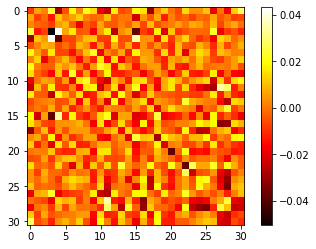

label, 0.0


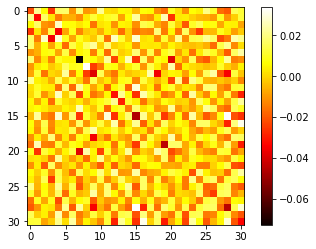

label, 0.0


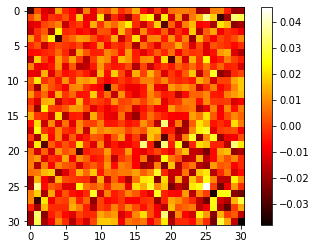

label, 0.0


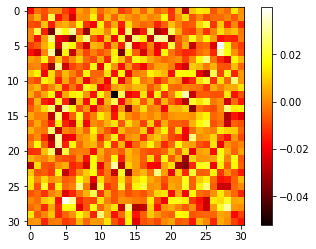

label, 0.0


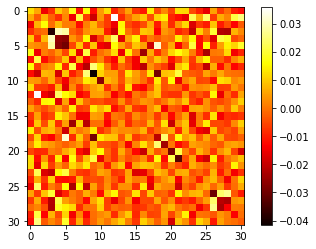

label, 0.0


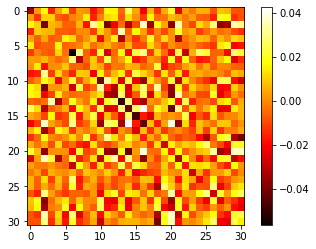

label, 0.0


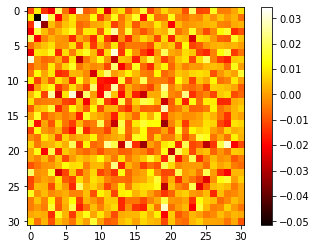

label, 0.0


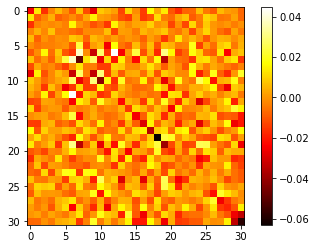

label, 0.0


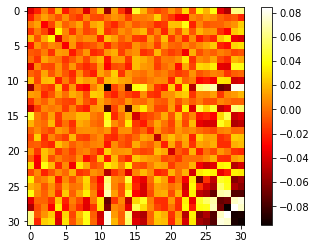

label, 1.0


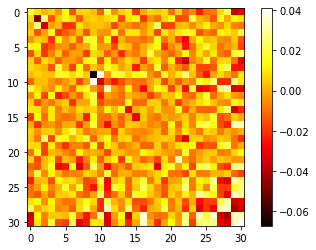

label, 1.0


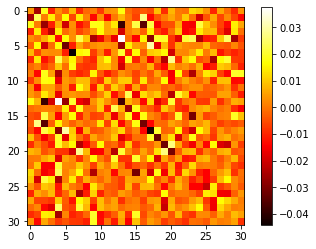

label, 1.0


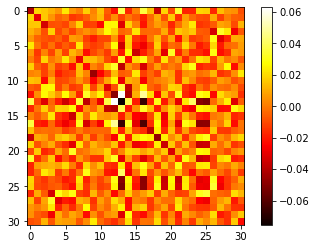

label, 1.0


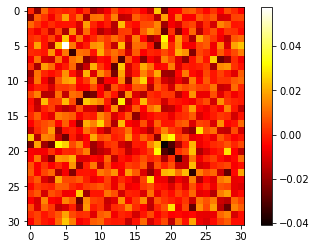

label, 1.0


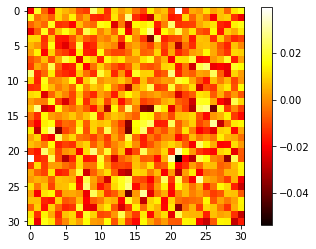

label, 1.0


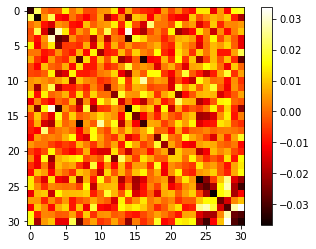

label, 1.0


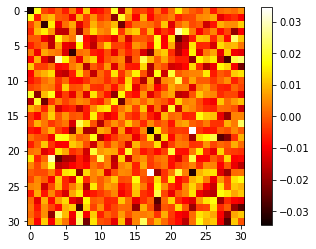

label, 1.0


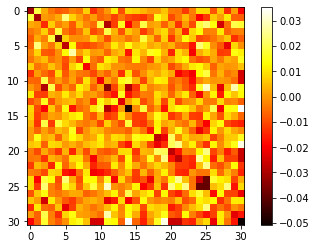

label, 1.0


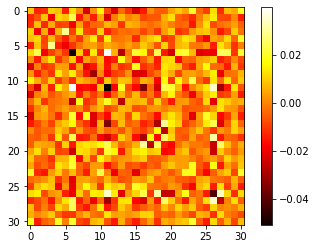

label, 1.0


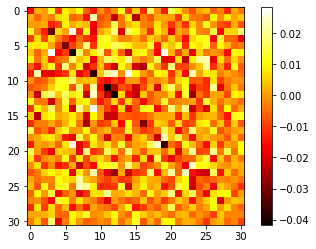

label, 1.0


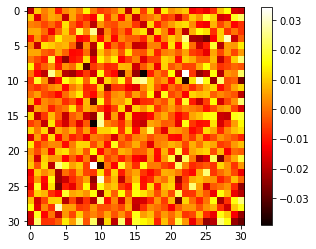

label, 1.0


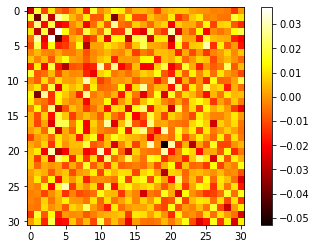

label, 1.0


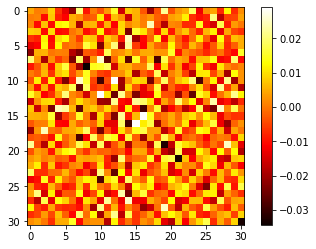

label, 1.0


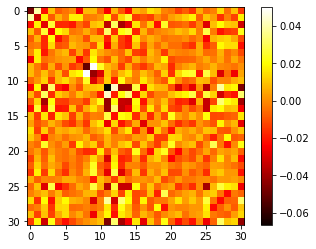

label, 1.0


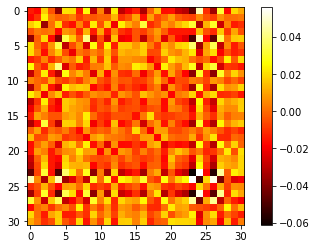

label, 1.0


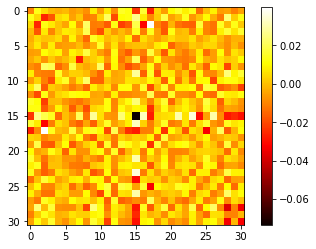

label, 1.0


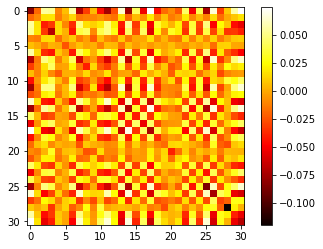

label, 1.0


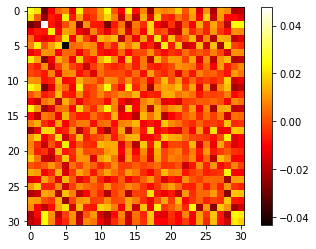

label, 1.0


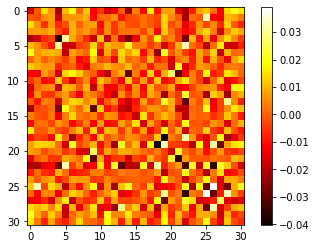

label, 1.0


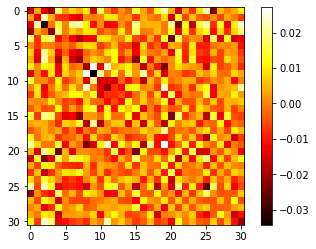

label, 1.0


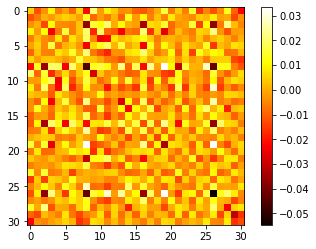

label, 1.0


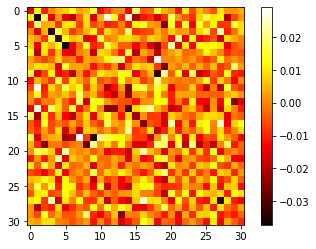

label, 1.0


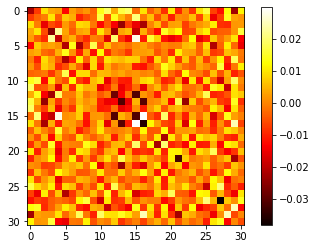

label, 1.0


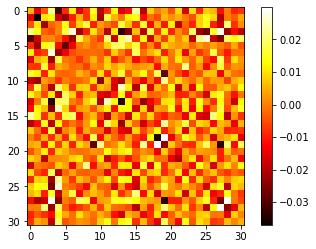

label, 1.0


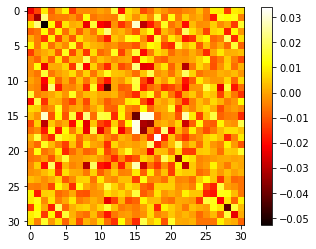

label, 1.0


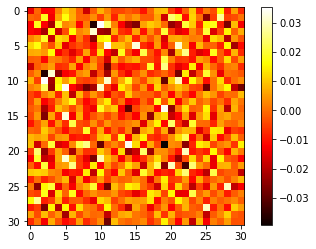

label, 1.0


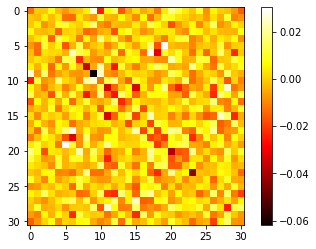

label, 1.0


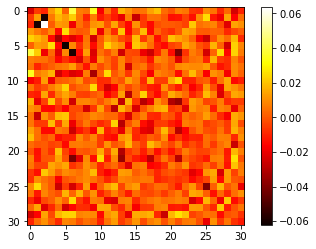

label, 1.0


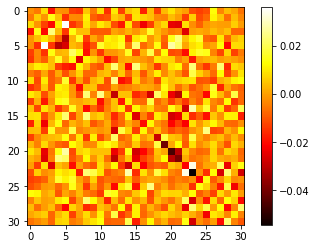

label, 1.0


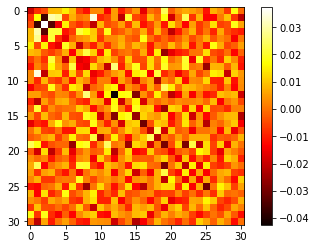

label, 1.0


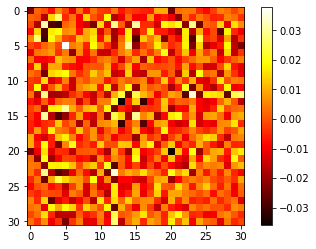

label, 1.0


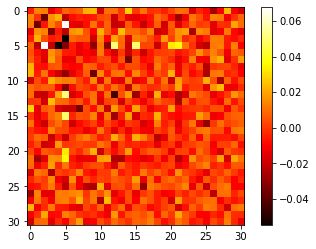

label, 1.0


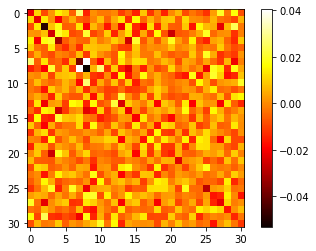

label, 1.0


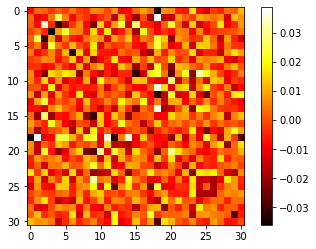

label, 1.0


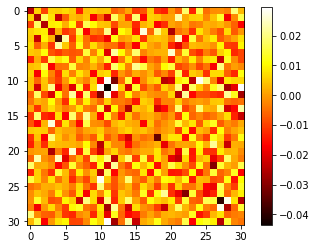

label, 1.0


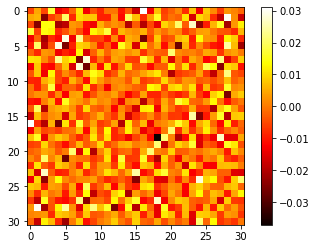

label, 1.0


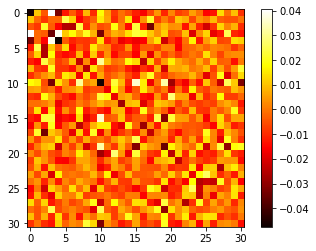

label, 1.0


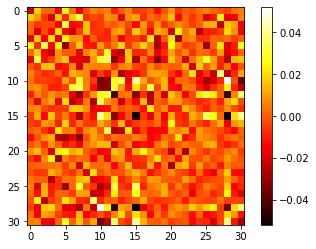

label, 1.0


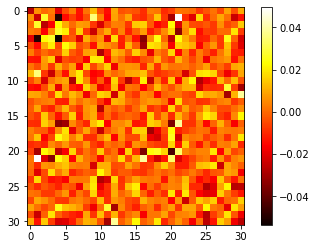

label, 1.0


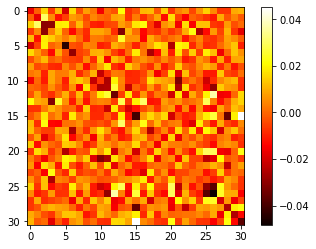

label, 1.0


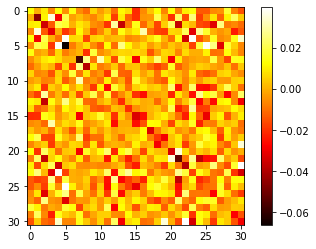

label, 1.0


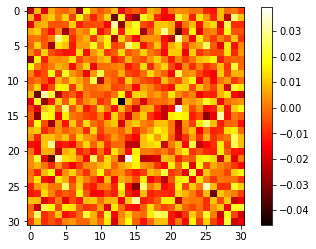

label, 1.0


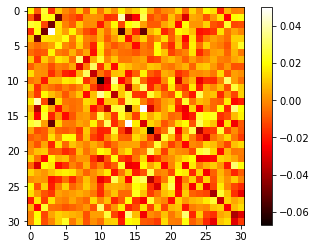

label, 1.0


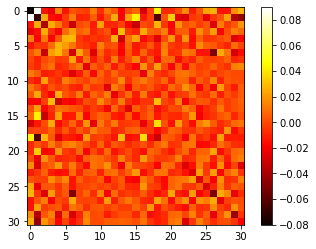

label, 1.0


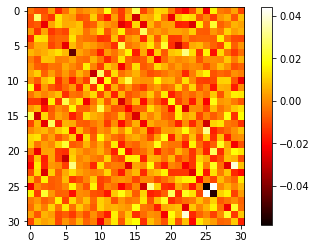

label, 1.0


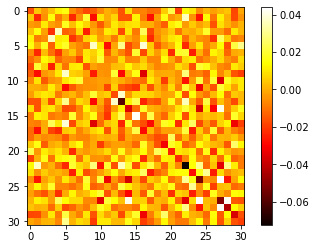

label, 1.0


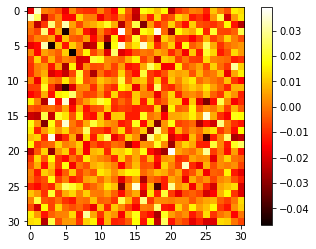

label, 1.0


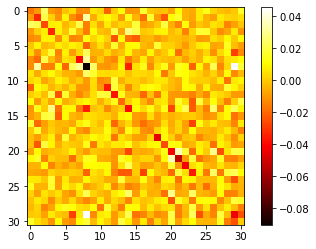

label, 1.0


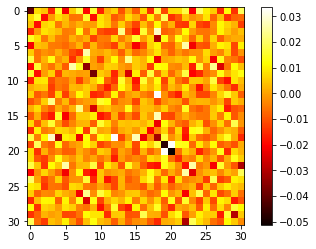

label, 1.0


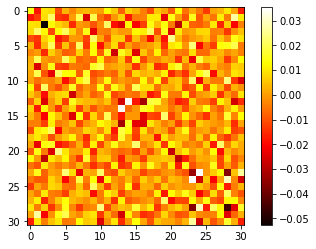

label, 1.0


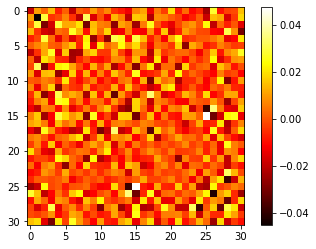

label, 1.0


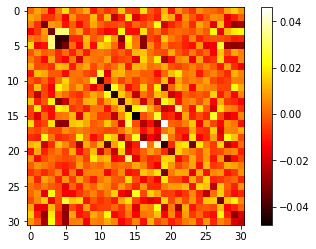

label, 1.0


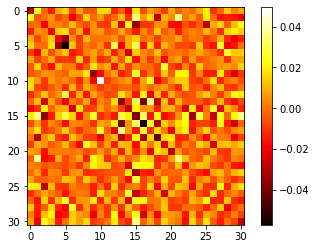

label, 1.0


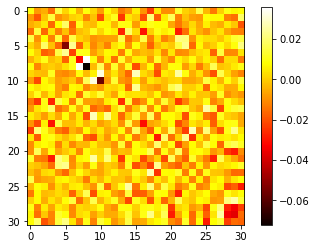

label, 1.0


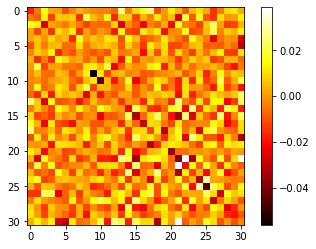

label, 1.0


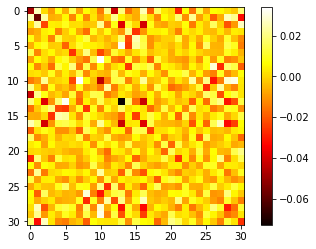

label, 1.0


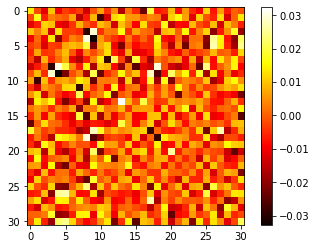

label, 1.0


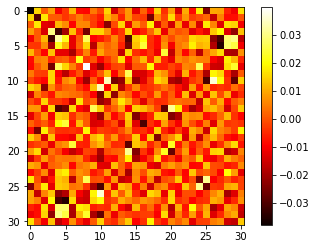

label, 1.0


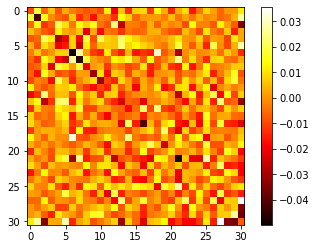

label, 1.0


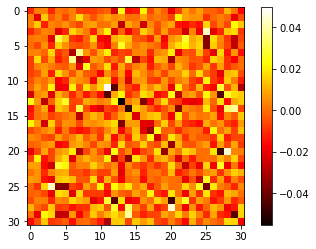

label, 1.0


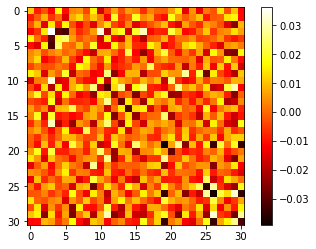

label, 1.0


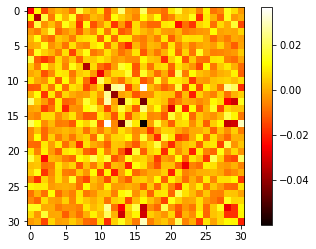

label, 1.0


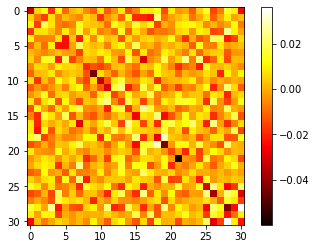

label, 1.0


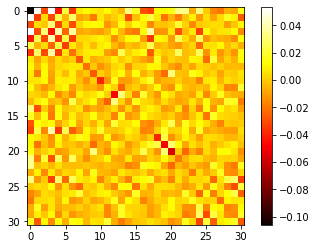

label, 1.0


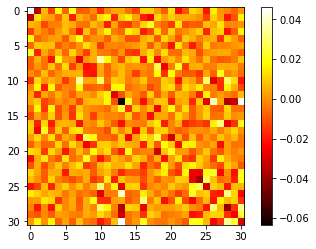

label, 1.0


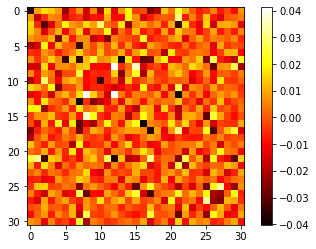

label, 1.0


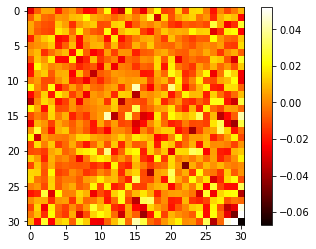

label, 1.0


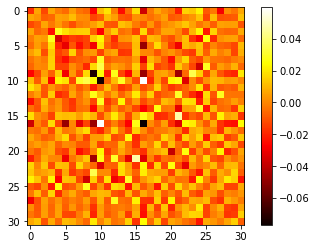

label, 1.0


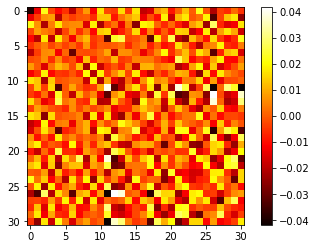

label, 1.0


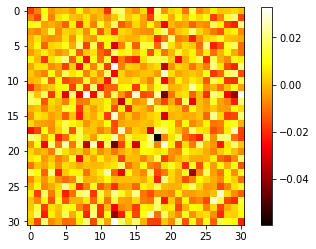

label, 1.0


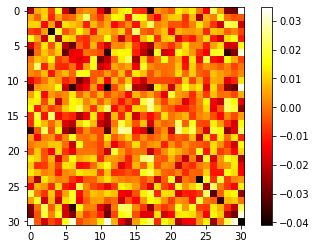

label, 1.0


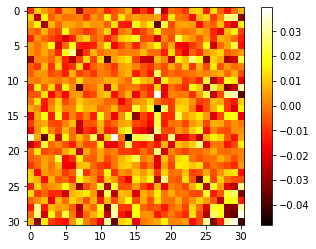

label, 1.0


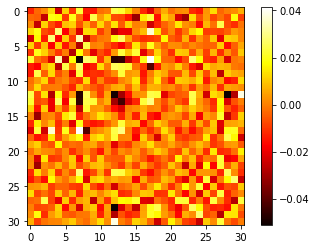

label, 1.0


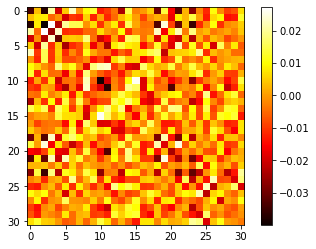

label, 1.0


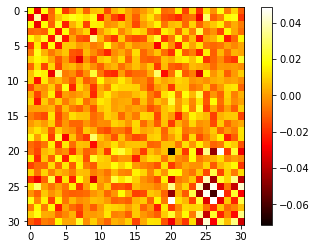

label, 0.0


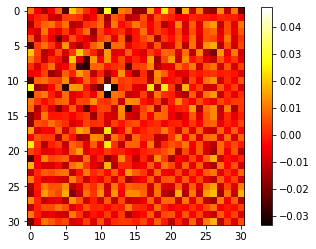

label, 0.0


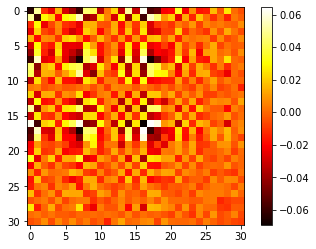

label, 0.0


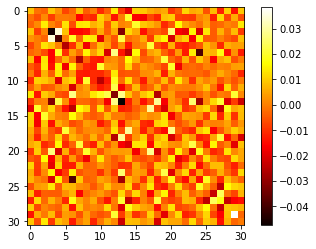

label, 0.0


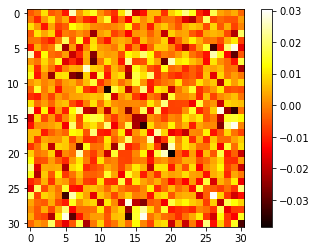

label, 0.0


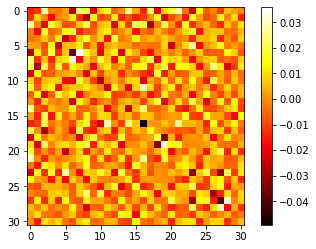

label, 0.0


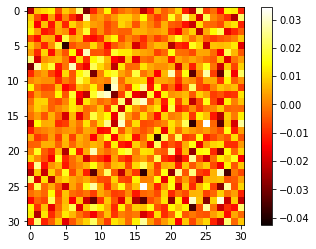

label, 0.0


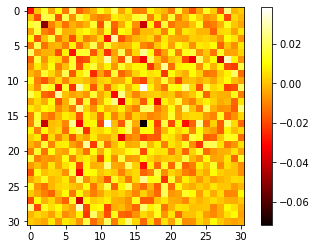

label, 0.0


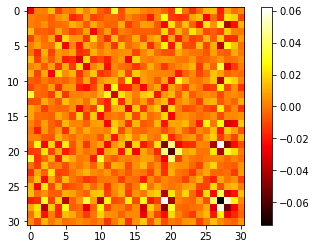

label, 0.0


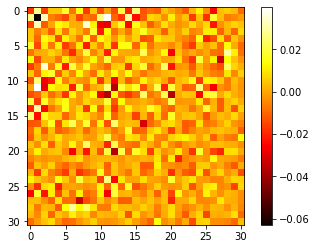

label, 0.0


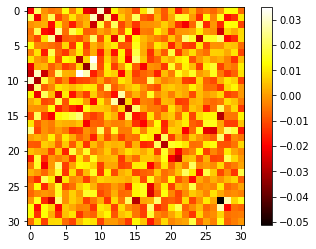

label, 1.0


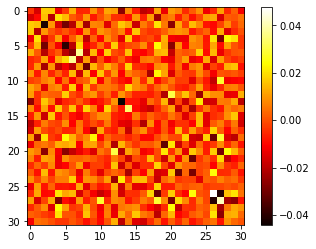

label, 1.0


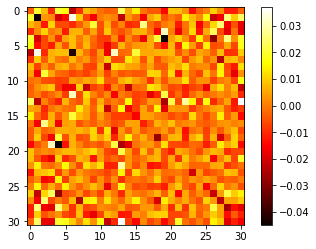

label, 1.0


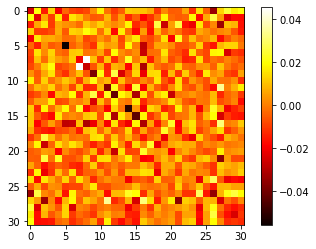

label, 1.0


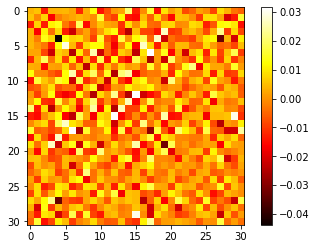

label, 1.0


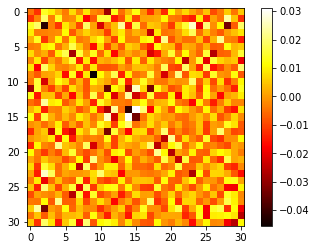

label, 1.0


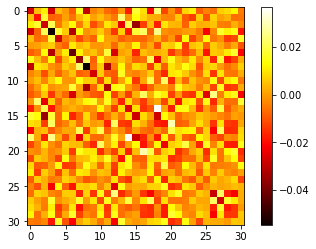

label, 1.0


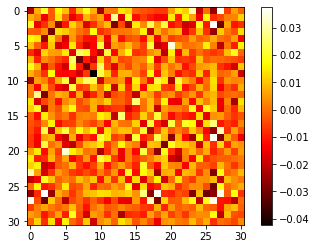

label, 1.0


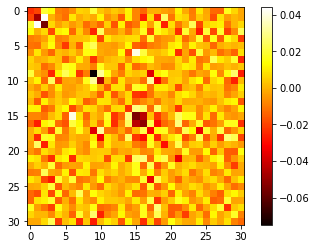

label, 1.0


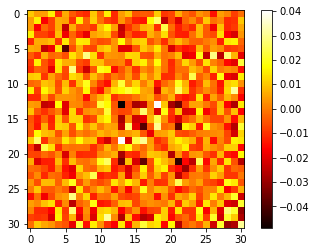

label, 1.0


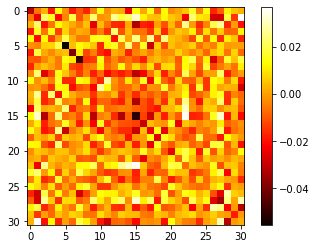

label, 1.0


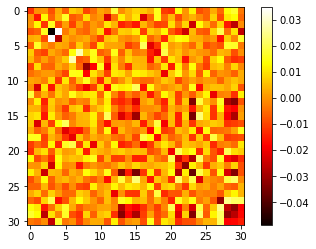

label, 1.0


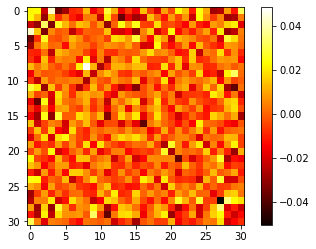

label, 1.0


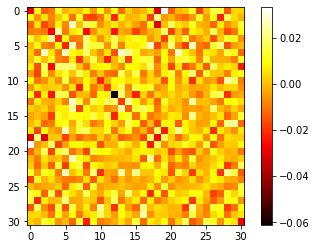

label, 1.0


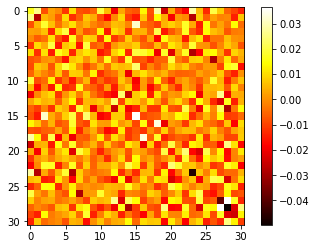

label, 1.0


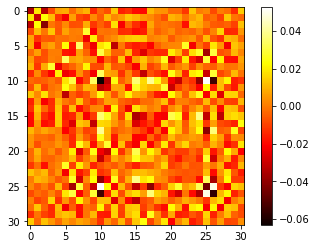

label, 1.0


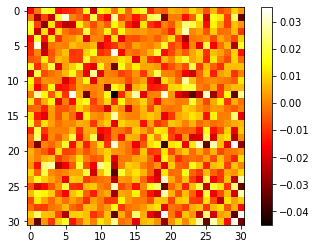

label, 1.0


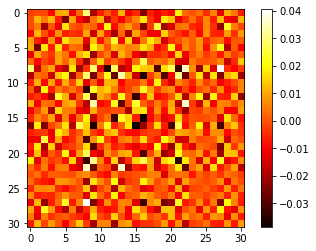

label, 1.0


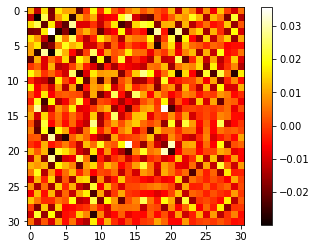

label, 1.0


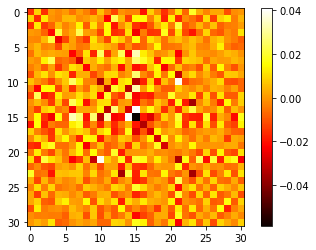

label, 1.0


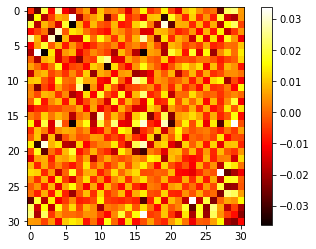

label, 1.0


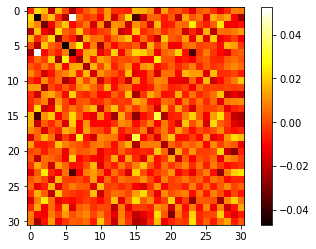

label, 1.0


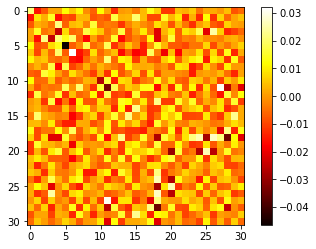

label, 1.0


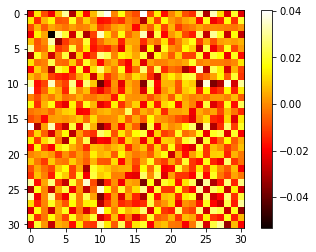

label, 0.0


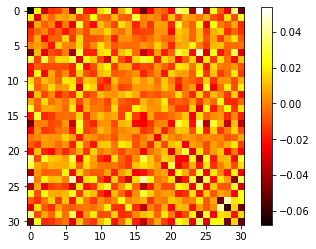

label, 0.0


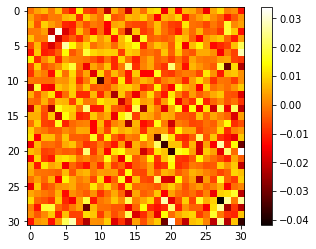

label, 0.0


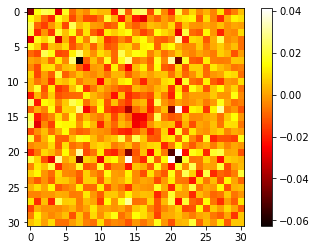

label, 0.0


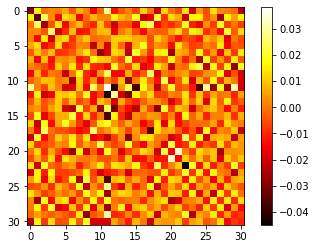

label, 0.0


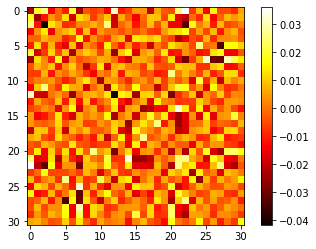

label, 0.0


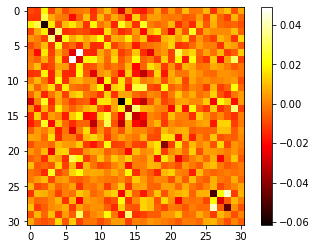

label, 0.0


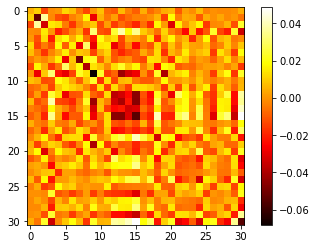

label, 0.0


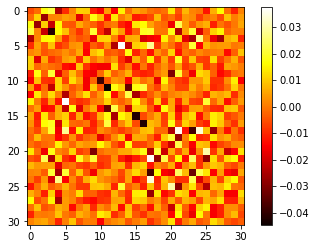

label, 0.0


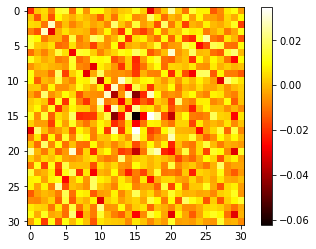

label, 0.0


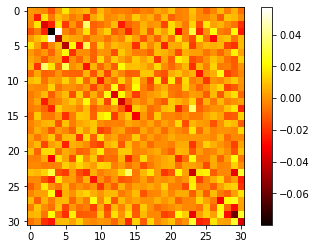

label, 0.0


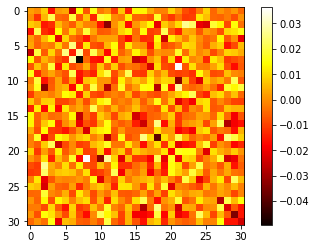

label, 0.0


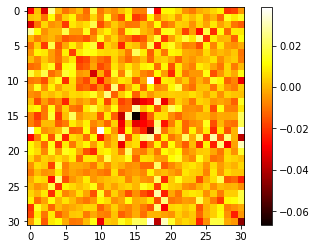

label, 0.0


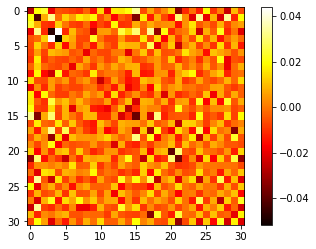

label, 0.0


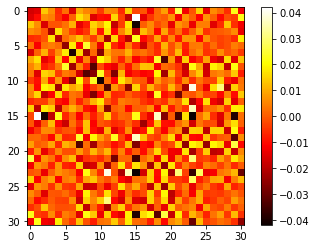

label, 0.0


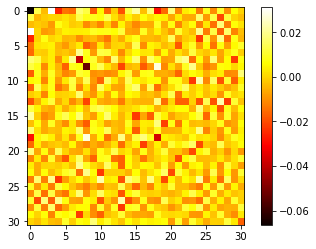

label, 0.0


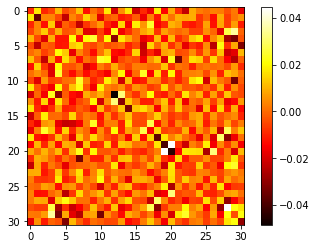

label, 0.0


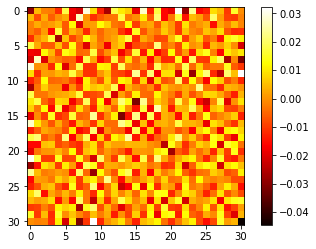

label, 0.0


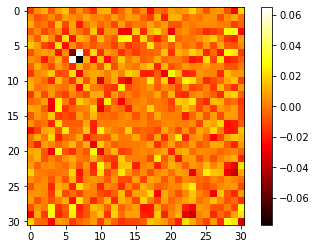

label, 0.0


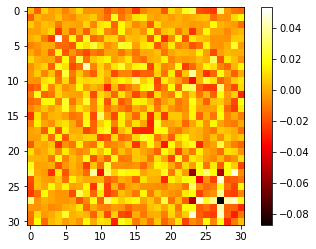

label, 0.0


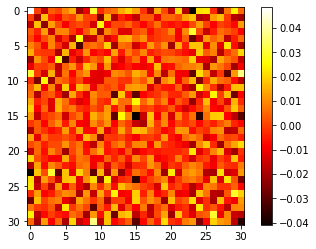

label, 0.0


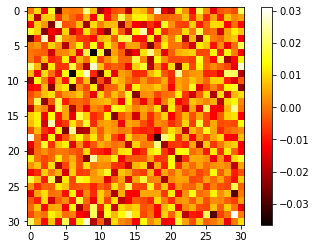

label, 0.0


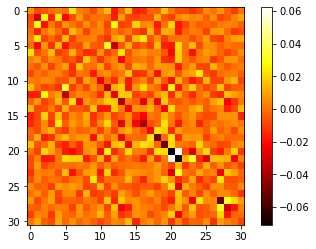

label, 1.0


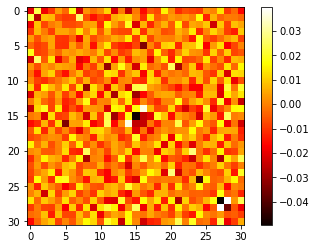

label, 1.0


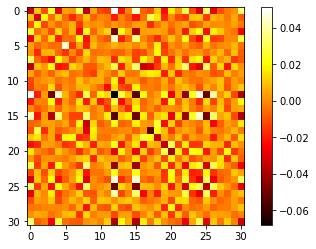

label, 1.0


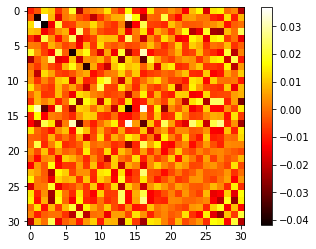

label, 1.0


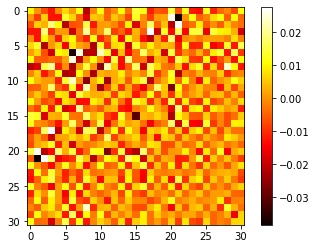

label, 1.0


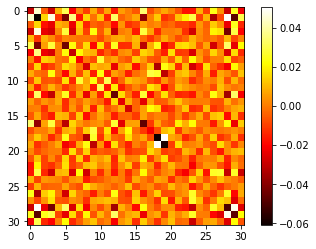

label, 1.0


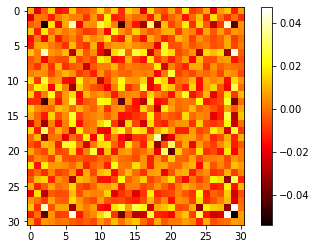

label, 1.0


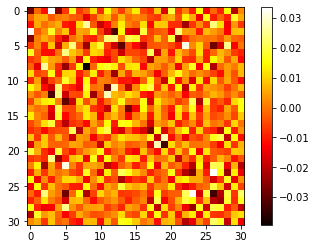

label, 1.0


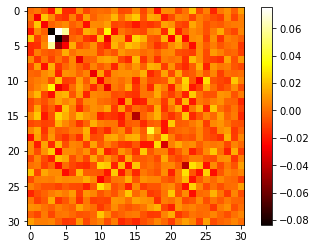

label, 1.0


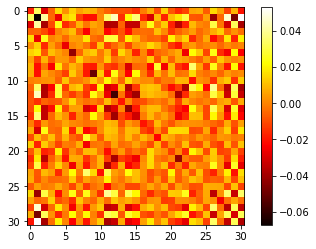

label, 1.0


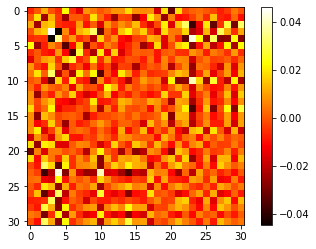

label, 1.0


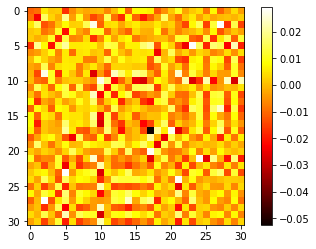

label, 1.0


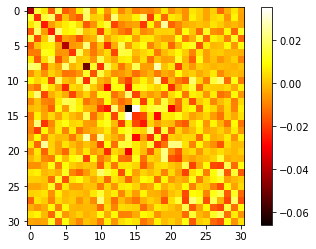

label, 1.0


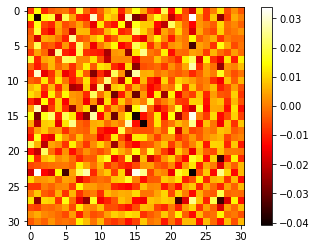

label, 1.0


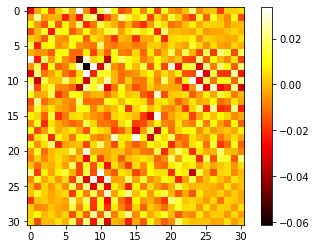

label, 1.0


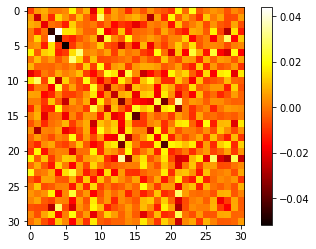

label, 0.0


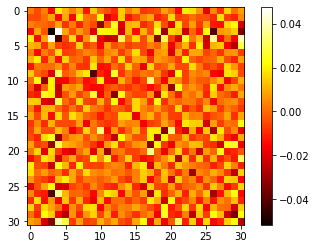

label, 0.0


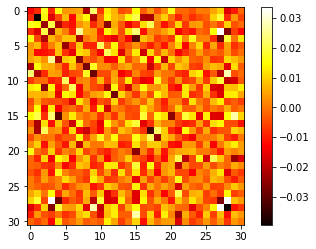

label, 0.0


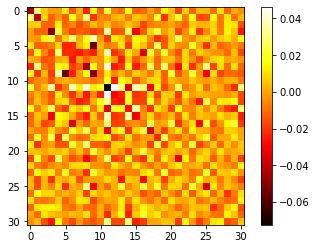

label, 0.0


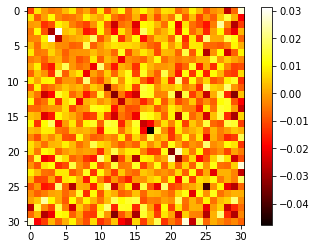

label, 0.0


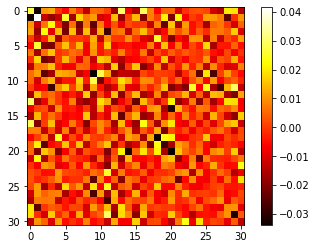

label, 0.0


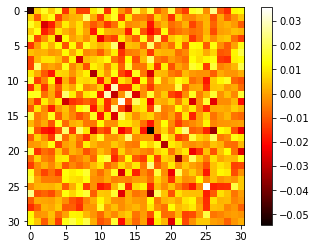

label, 0.0


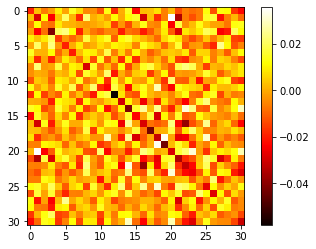

label, 0.0


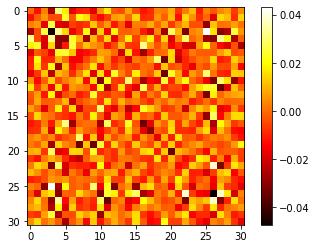

label, 0.0


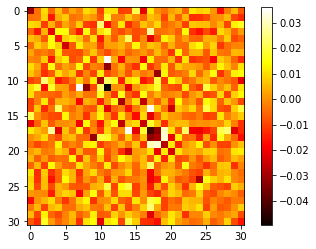

label, 0.0


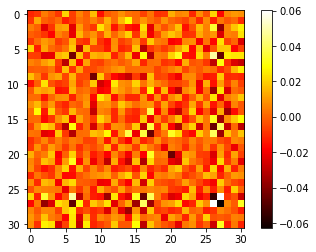

label, 0.0


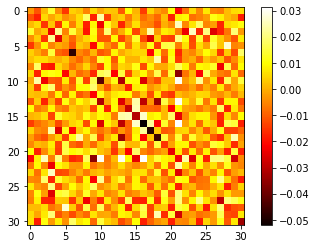

label, 0.0


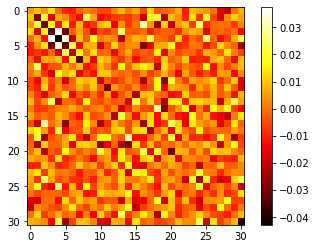

label, 0.0


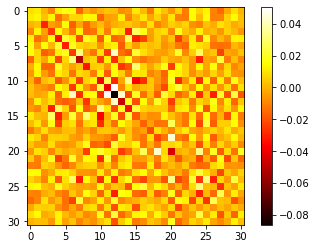

label, 0.0


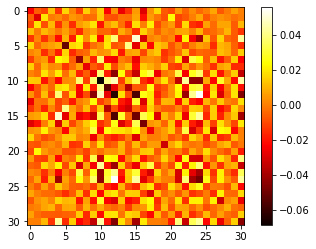

label, 0.0


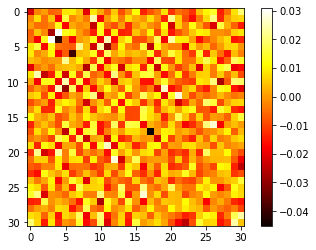

label, 0.0


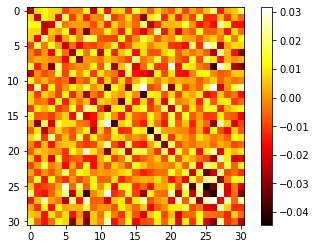

label, 0.0


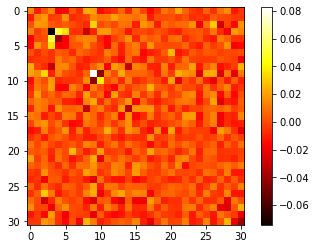

label, 0.0


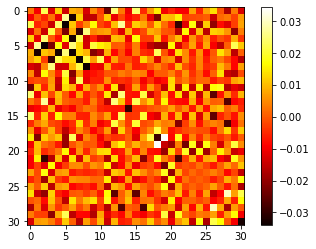

label, 0.0


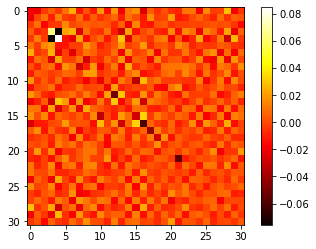

label, 0.0


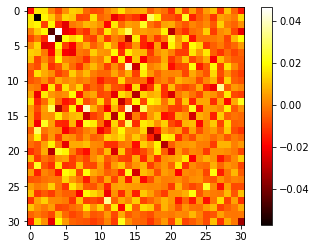

label, 0.0


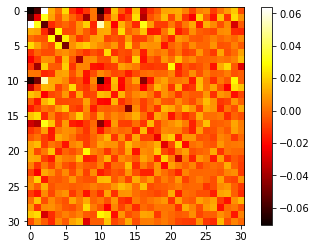

label, 0.0


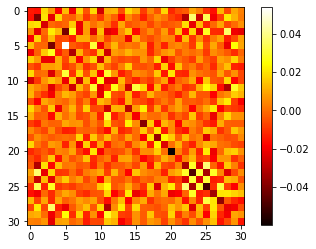

label, 0.0


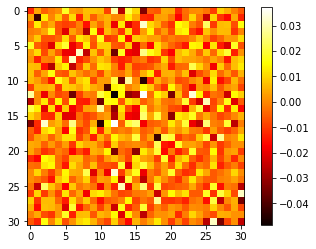

label, 0.0


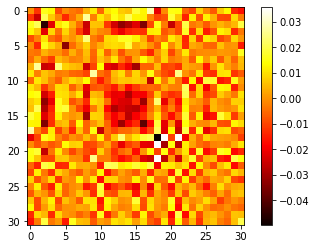

label, 0.0


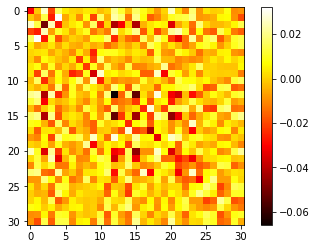

label, 0.0


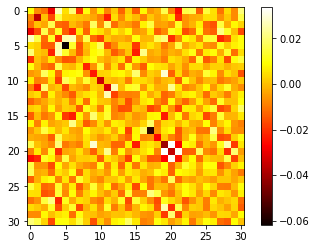

label, 0.0


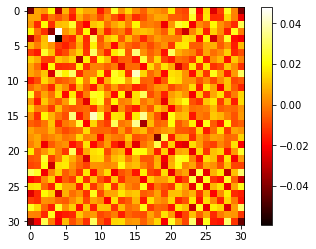

label, 0.0


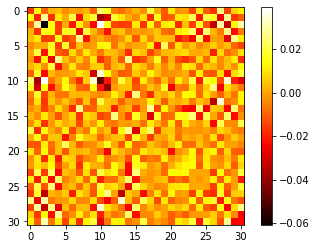

label, 0.0


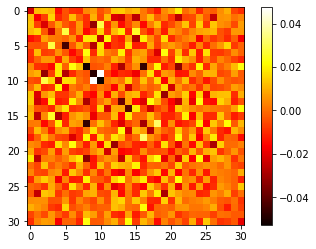

label, 0.0


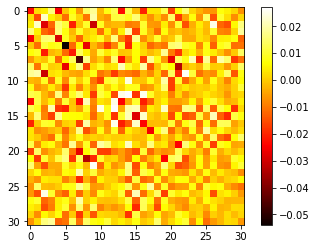

label, 0.0


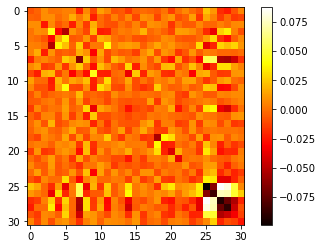

label, 0.0


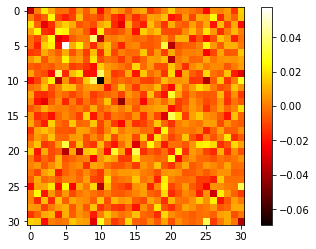

label, 0.0


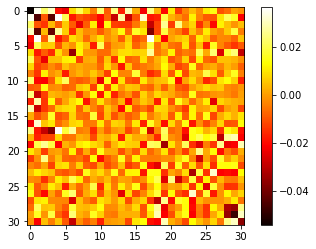

label, 0.0


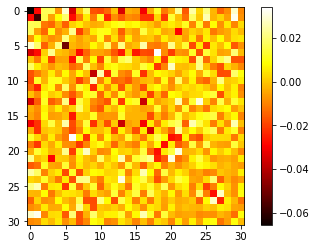

label, 0.0


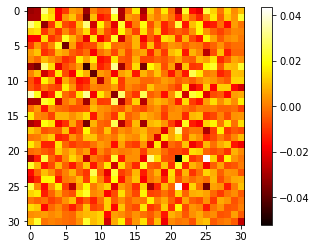

label, 0.0


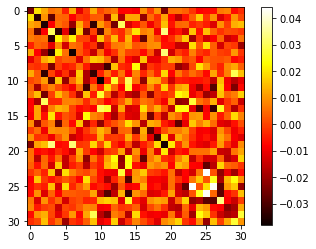

label, 0.0


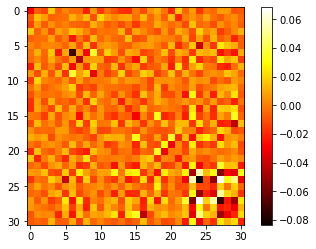

label, 0.0


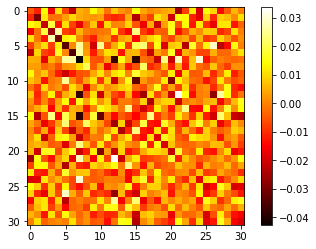

label, 0.0


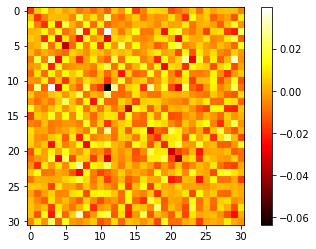

label, 0.0


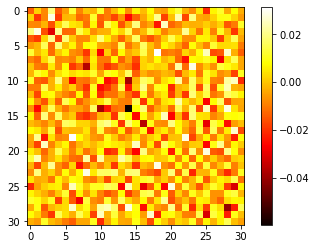

label, 0.0


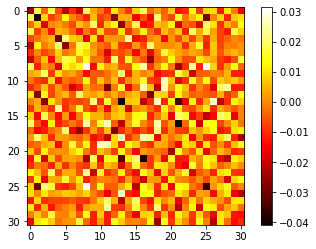

label, 0.0


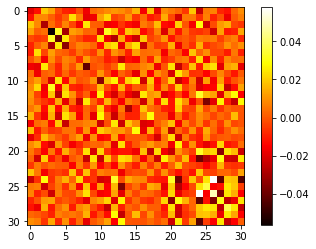

label, 0.0


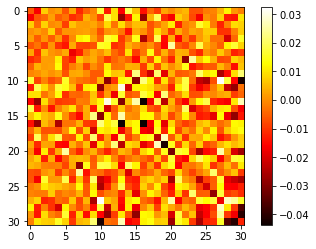

label, 0.0


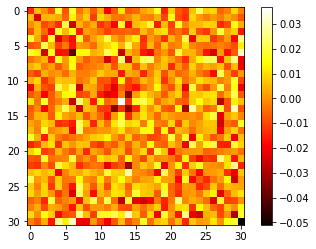

label, 0.0


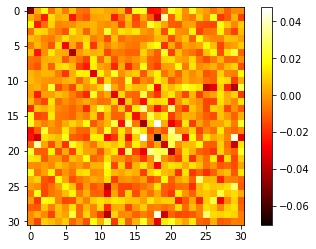

label, 0.0


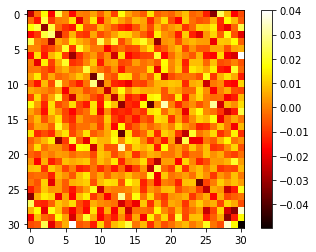

label, 0.0


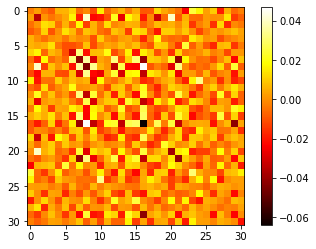

label, 0.0


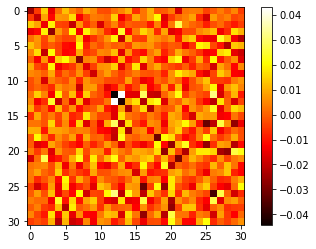

label, 0.0


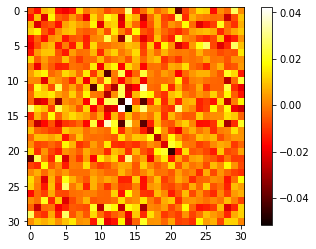

label, 0.0


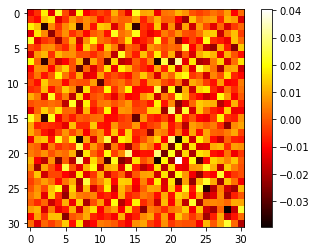

label, 0.0


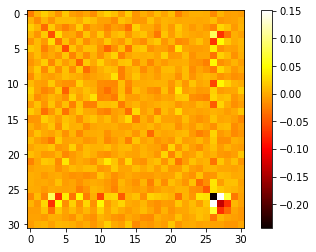

label, 0.0


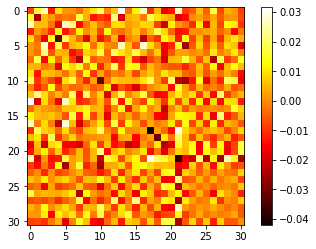

label, 0.0


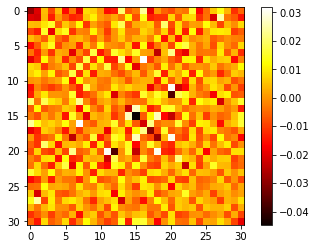

label, 0.0


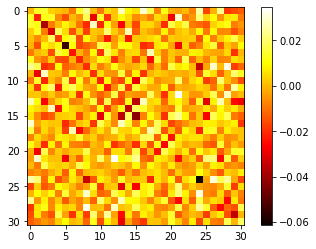

label, 0.0


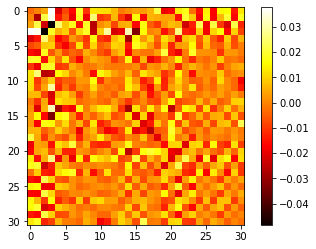

label, 0.0


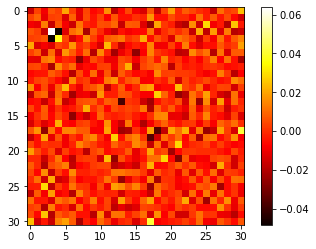

label, 0.0


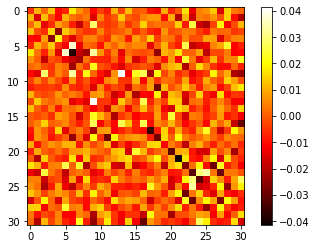

label, 0.0


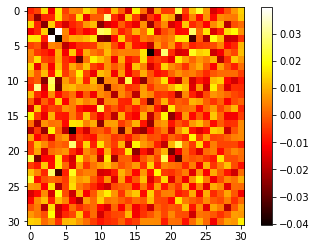

label, 0.0


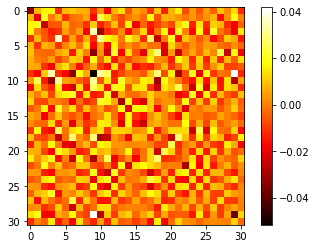

label, 0.0


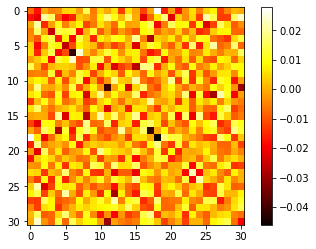

label, 0.0


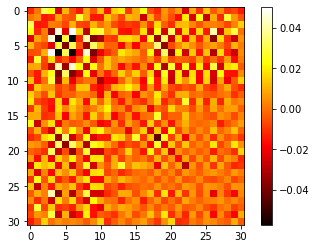

label, 0.0


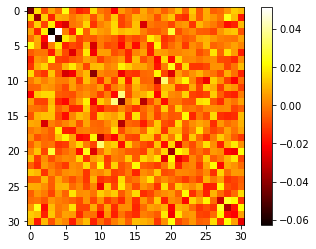

label, 0.0


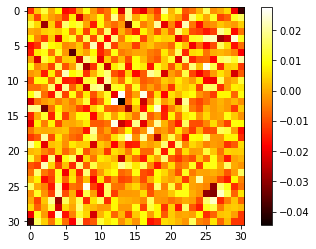

label, 0.0


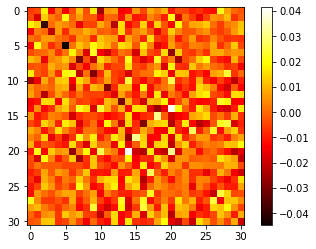

label, 0.0


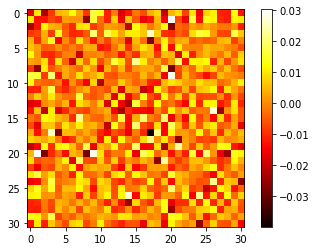

label, 0.0


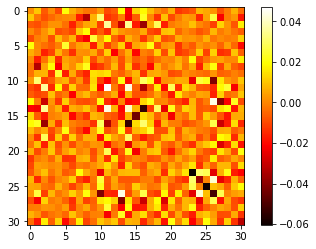

label, 0.0


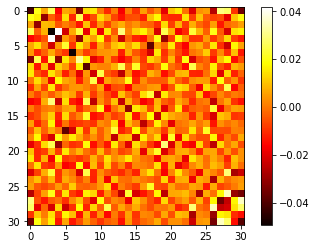

label, 0.0


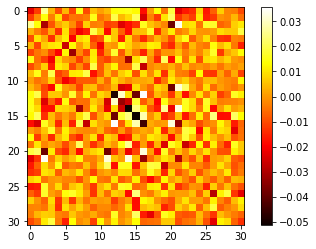

label, 0.0


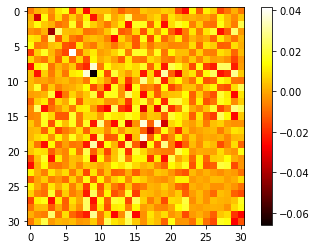

label, 0.0


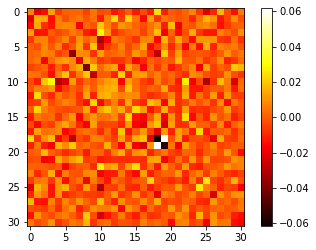

label, 0.0


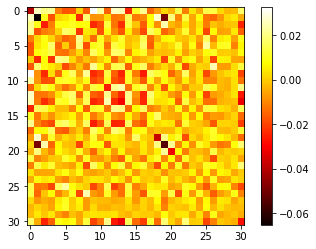

label, 0.0


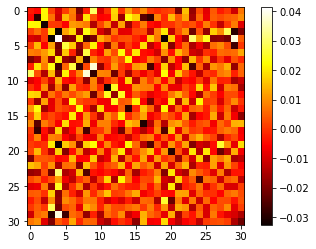

label, 0.0


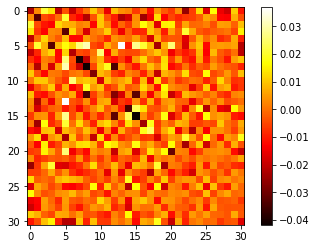

label, 0.0


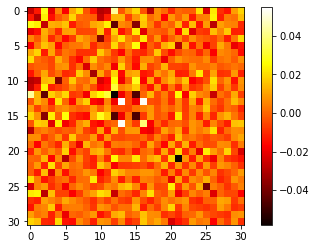

label, 0.0


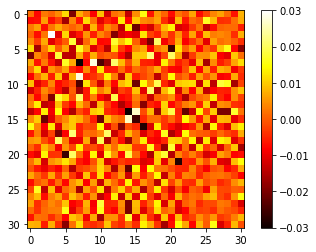

label, 0.0


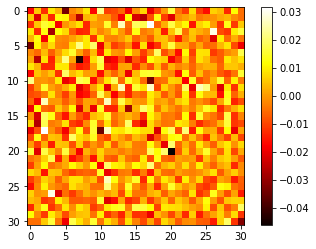

label, 0.0


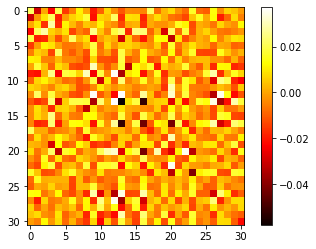

label, 0.0


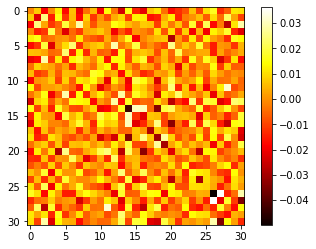

label, 0.0


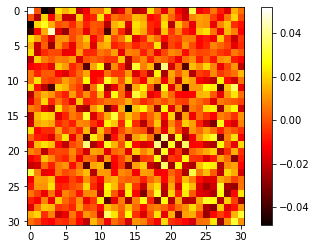

label, 0.0


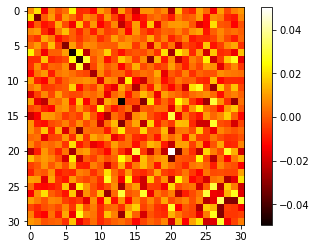

label, 0.0


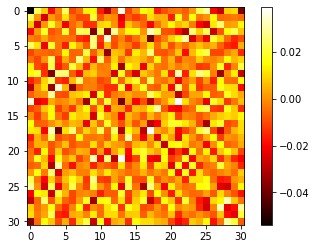

label, 0.0


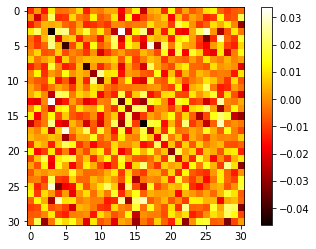

label, 0.0


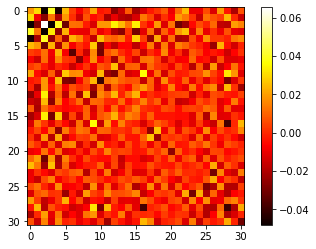

label, 0.0


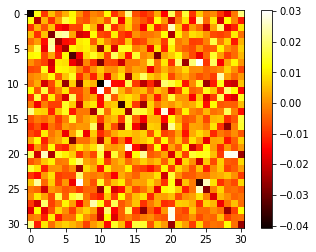

label, 0.0


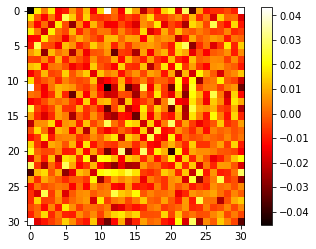

label, 0.0


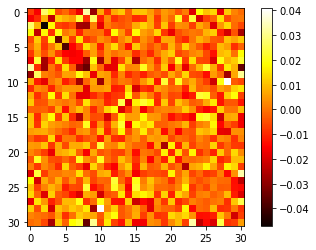

label, 0.0


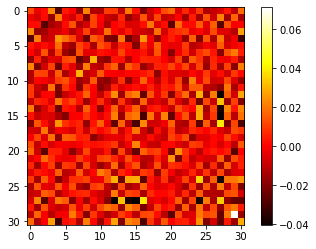

label, 0.0


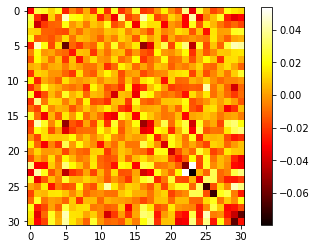

label, 0.0


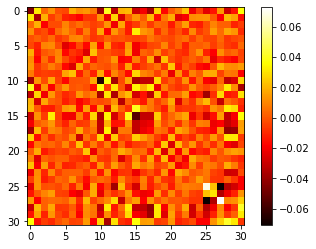

label, 0.0


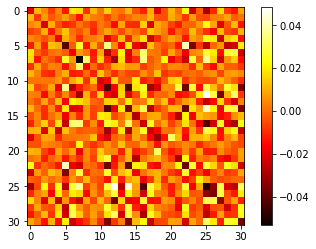

label, 0.0


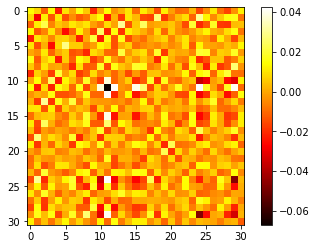

label, 0.0


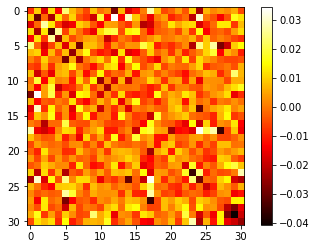

label, 0.0


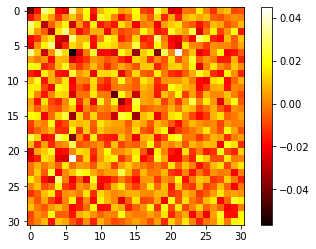

label, 0.0


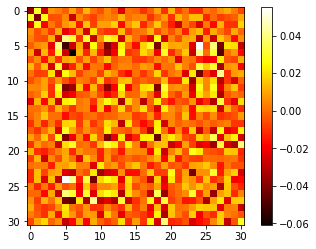

label, 0.0


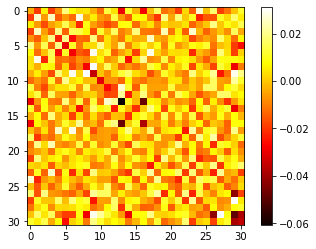

label, 0.0


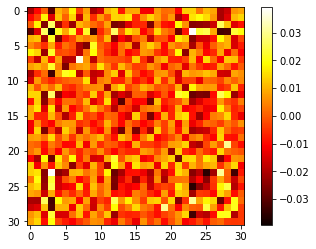

label, 0.0


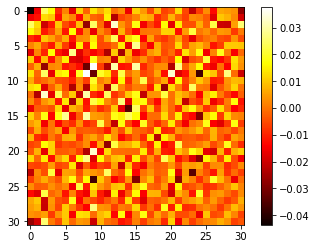

label, 0.0


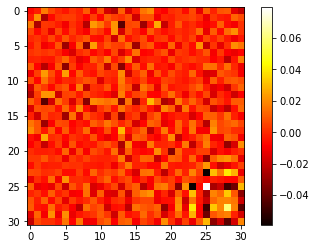

label, 0.0


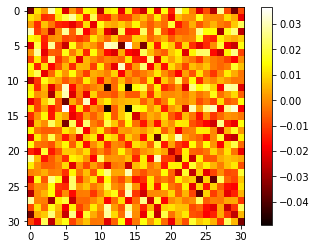

label, 0.0


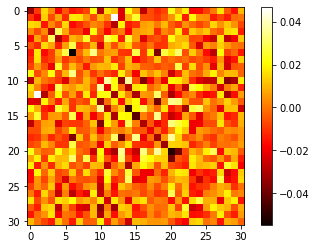

label, 0.0


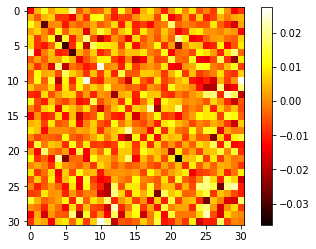

label, 0.0


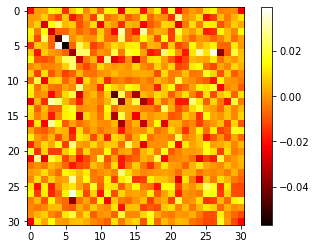

label, 0.0


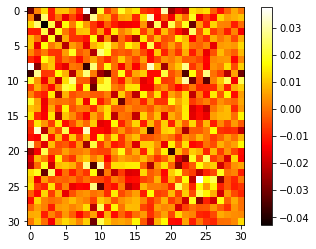

label, 0.0


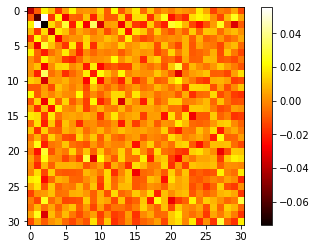

label, 0.0


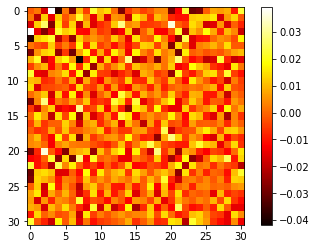

label, 0.0


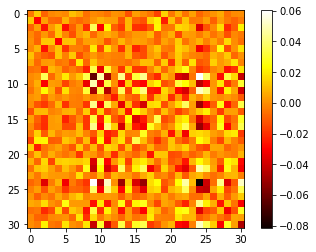

label, 0.0


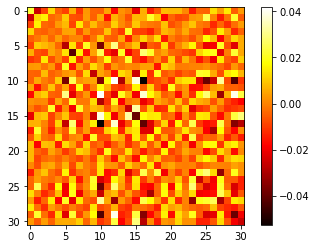

label, 0.0


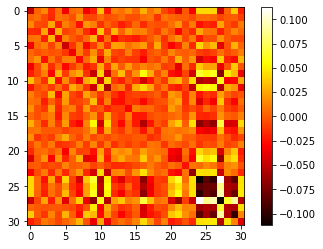

label, 0.0


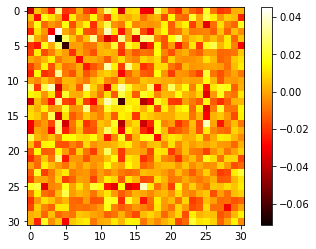

label, 0.0


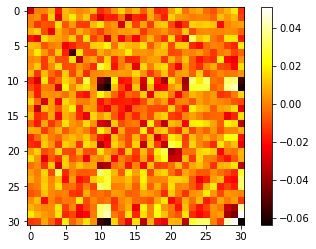

label, 0.0


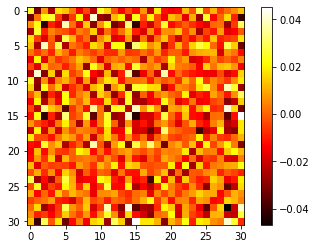

label, 0.0


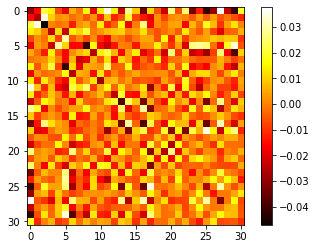

label, 0.0


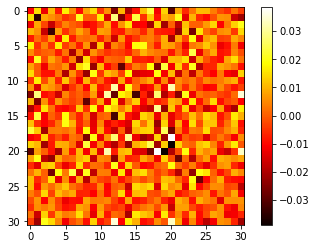

label, 0.0


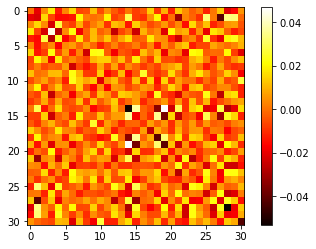

label, 0.0


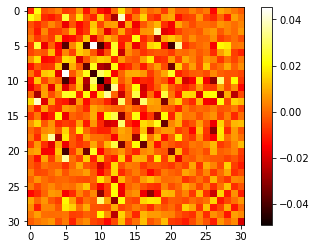

label, 0.0


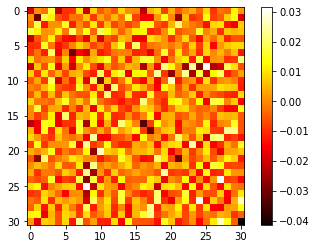

label, 0.0


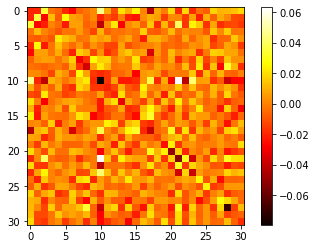

label, 0.0


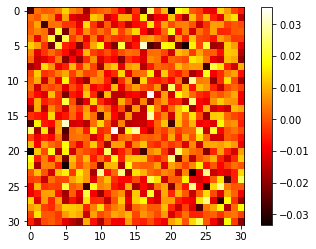

label, 0.0


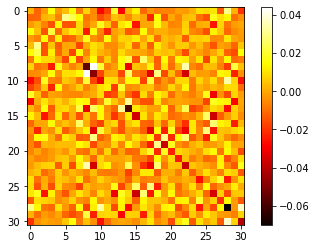

label, 0.0


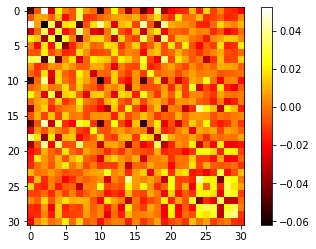

label, 0.0


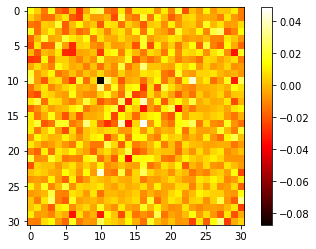

label, 0.0


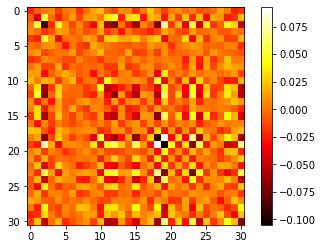

label, 0.0


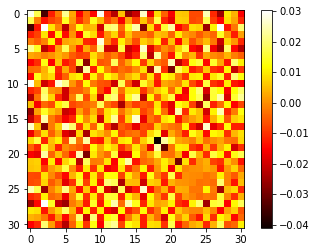

label, 0.0


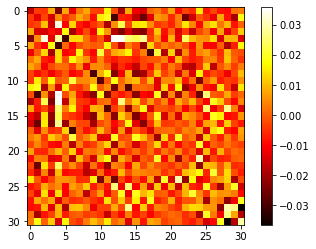

label, 0.0


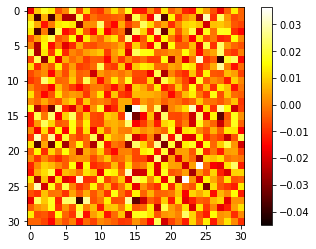

label, 0.0


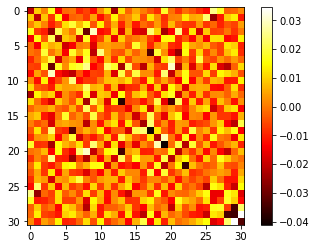

label, 0.0


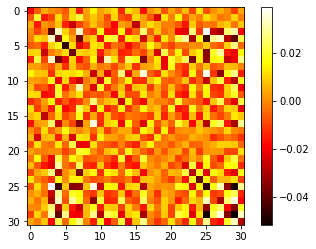

label, 0.0


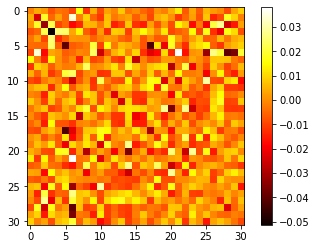

label, 0.0


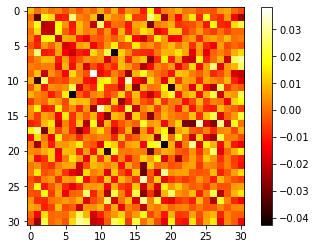

label, 0.0


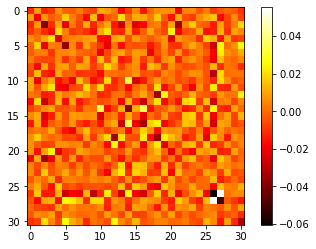

label, 0.0


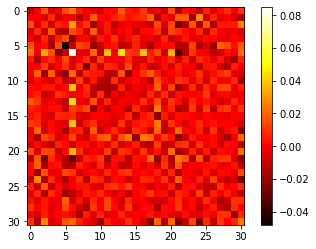

label, 0.0


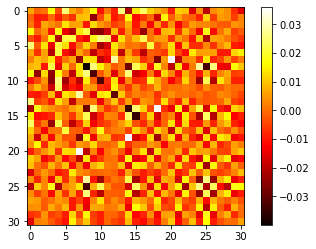

label, 0.0


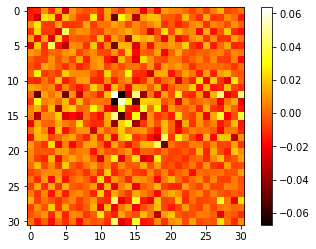

label, 0.0


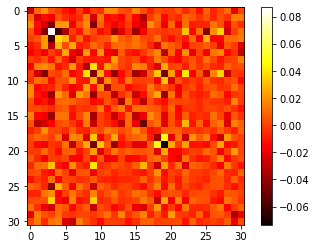

label, 0.0


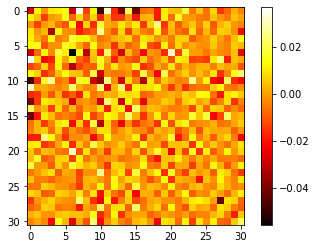

label, 0.0


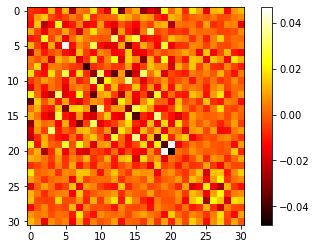

label, 0.0


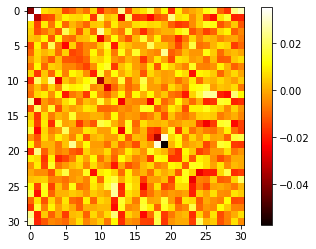

label, 0.0


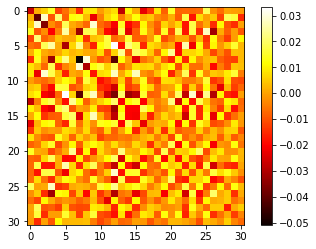

label, 0.0


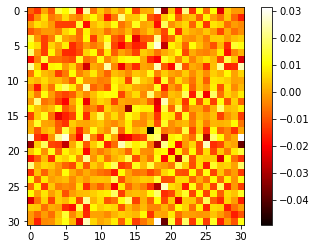

label, 0.0


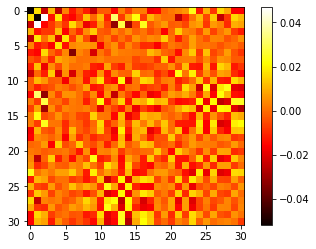

label, 0.0


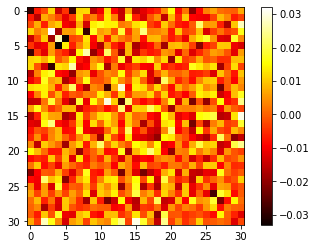

label, 0.0


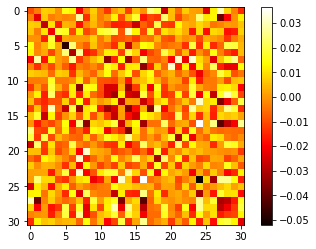

label, 0.0


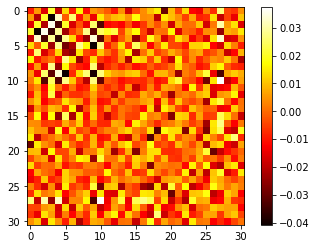

label, 0.0


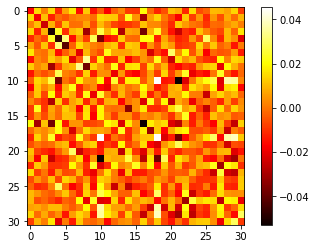

label, 0.0


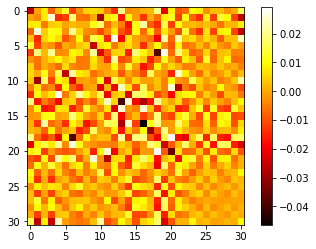

label, 0.0


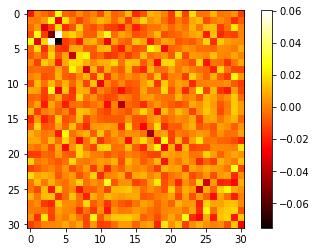

label, 0.0


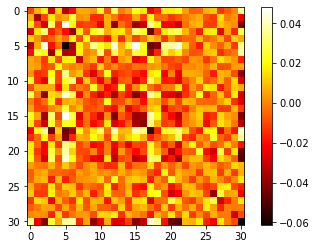

label, 0.0


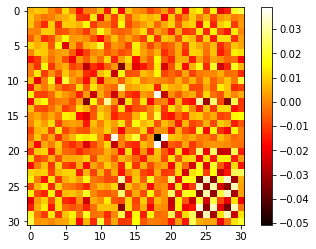

label, 0.0


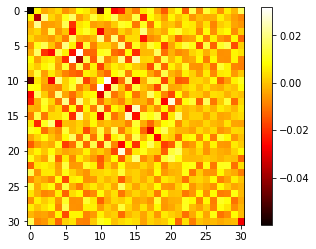

label, 0.0


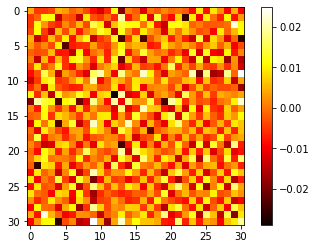

label, 0.0


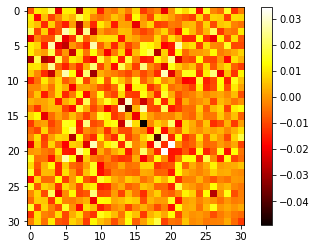

label, 0.0


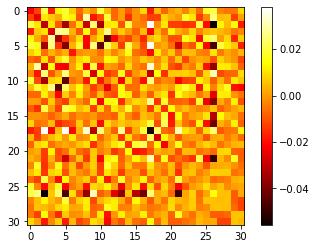

label, 0.0


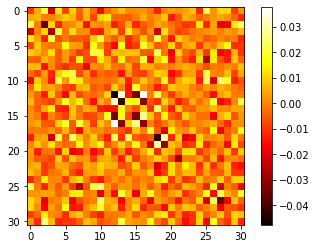

label, 0.0


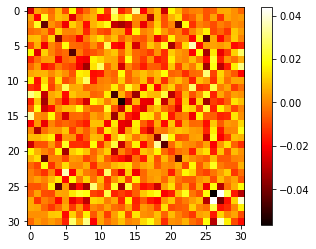

label, 0.0


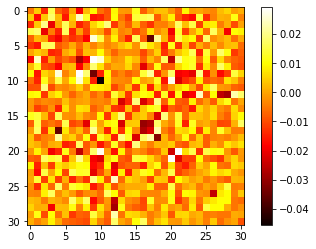

label, 0.0


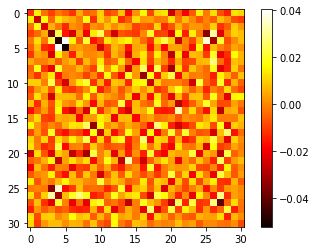

label, 0.0


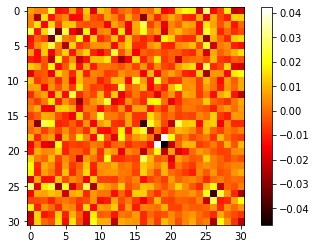

label, 0.0


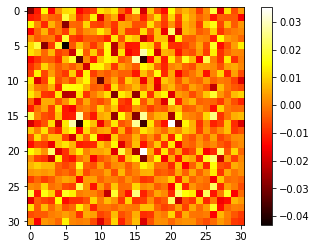

label, 0.0


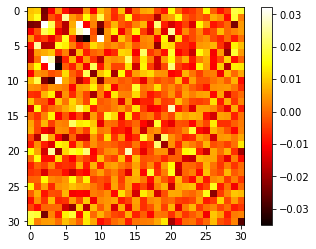

label, 0.0


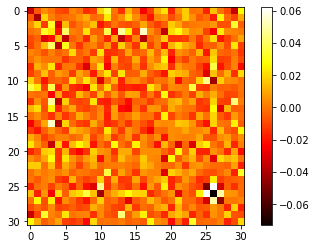

label, 0.0


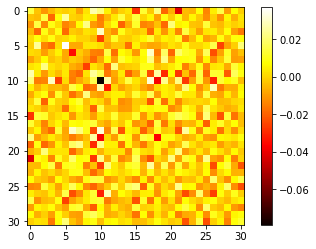

label, 0.0


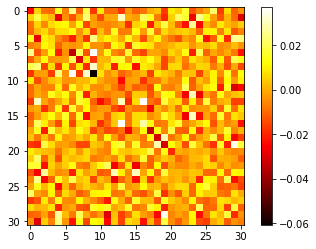

label, 0.0


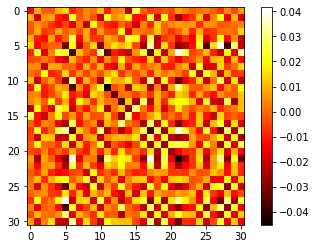

label, 0.0


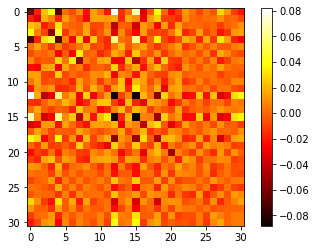

label, 0.0


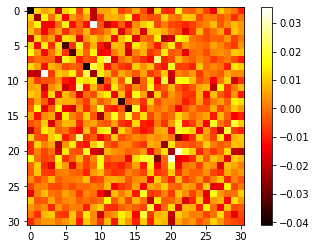

label, 0.0


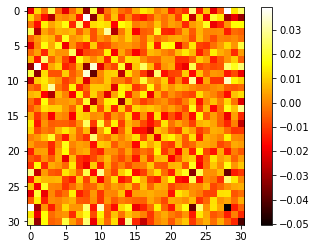

label, 0.0


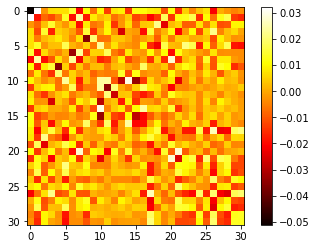

label, 0.0


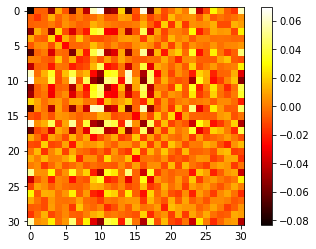

label, 0.0


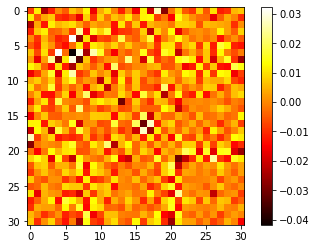

label, 0.0


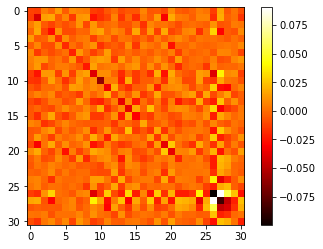

label, 0.0


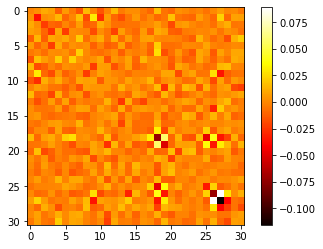

label, 0.0


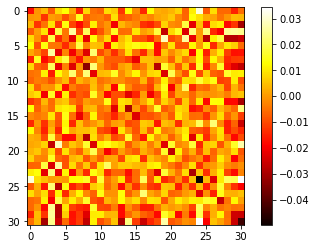

label, 0.0


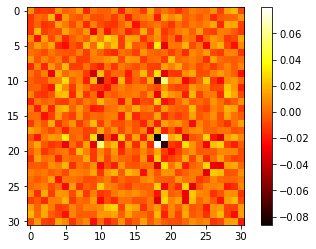

label, 0.0


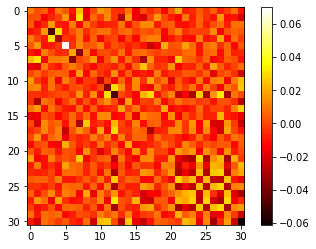

label, 0.0


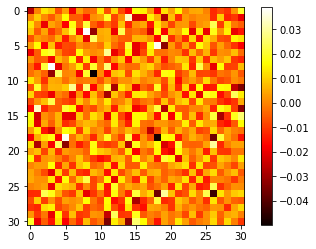

label, 0.0


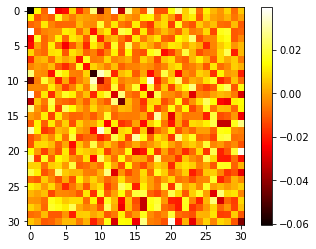

label, 0.0


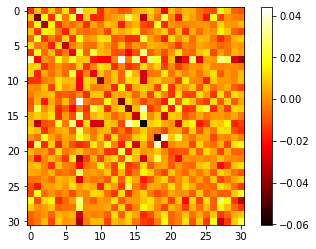

label, 0.0


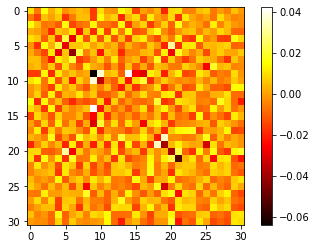

label, 0.0


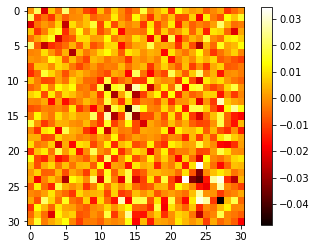

label, 0.0


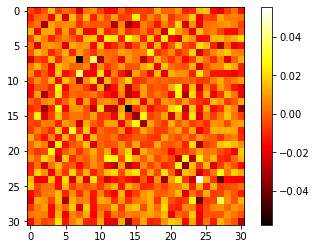

label, 0.0


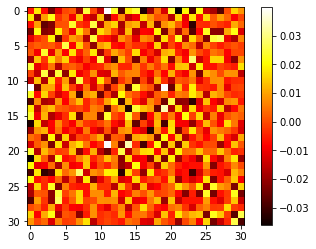

label, 0.0


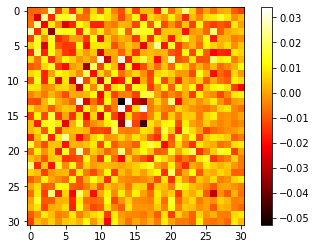

label, 0.0


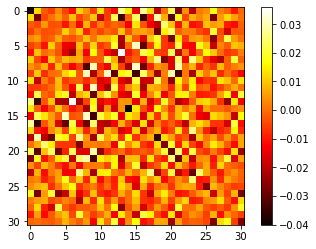

label, 0.0


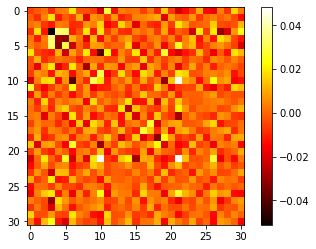

label, 0.0


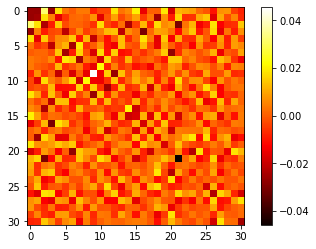

label, 0.0


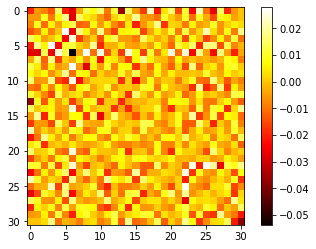

label, 0.0


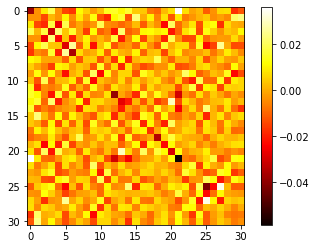

label, 0.0


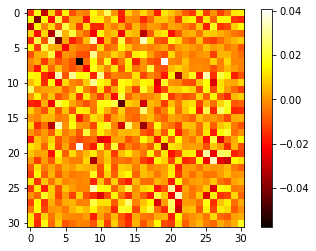

label, 0.0


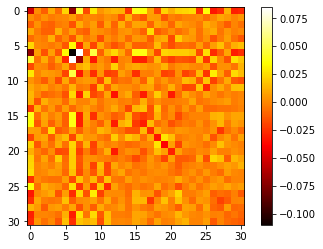

label, 0.0


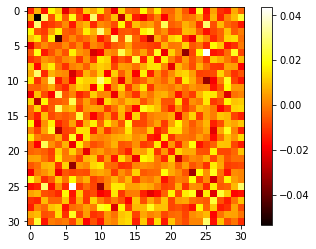

label, 0.0


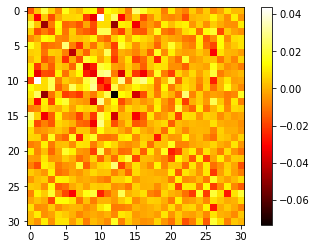

label, 0.0


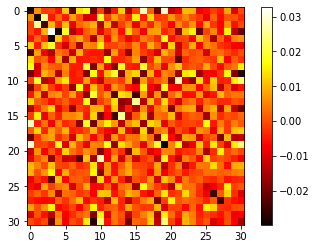

label, 0.0


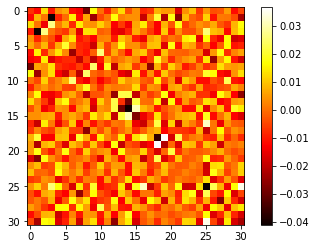

label, 0.0


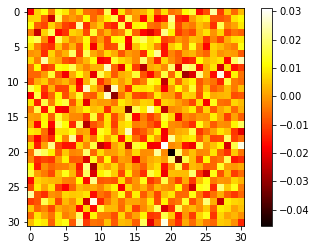

label, 0.0


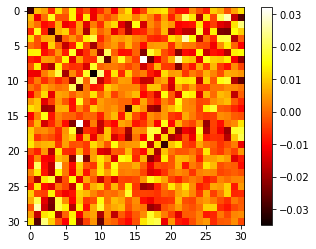

label, 0.0


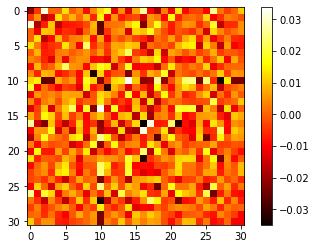

label, 0.0


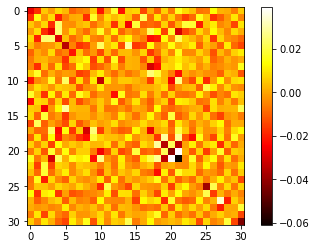

label, 0.0


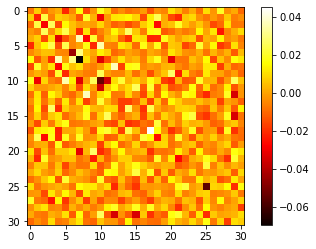

label, 0.0


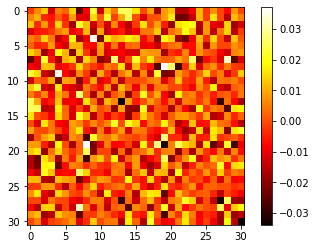

label, 0.0


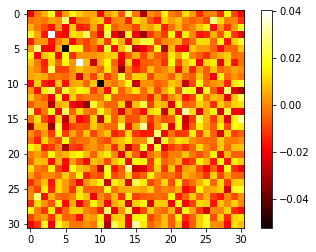

label, 0.0


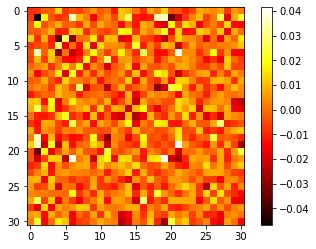

label, 0.0


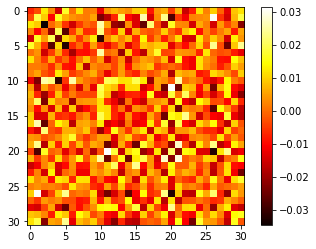

label, 0.0


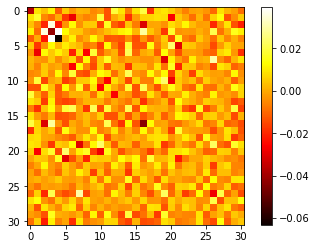

label, 0.0


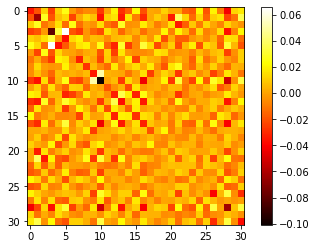

label, 0.0


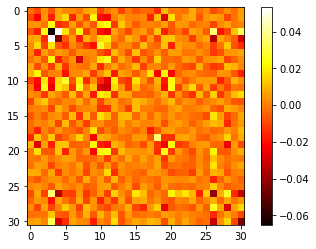

label, 0.0


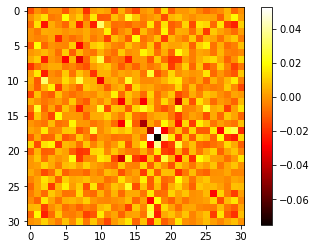

label, 0.0


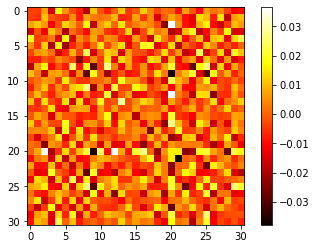

label, 0.0


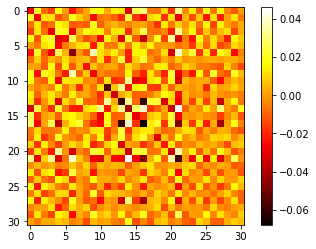

label, 0.0


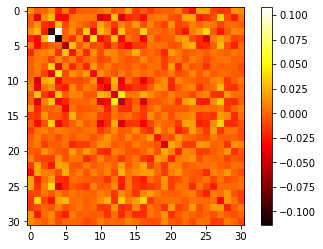

label, 0.0


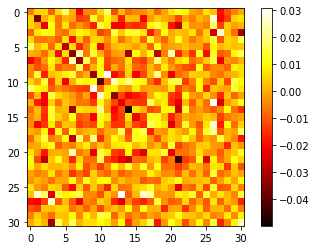

label, 0.0


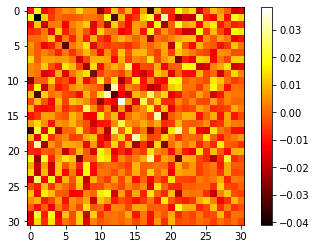

label, 0.0


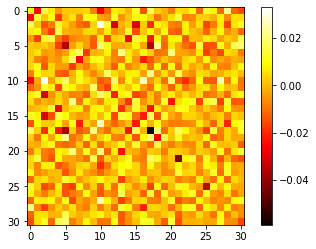

label, 0.0


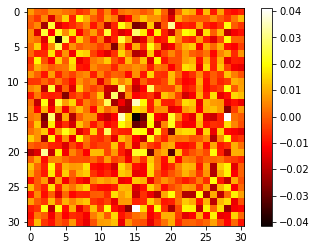

label, 0.0


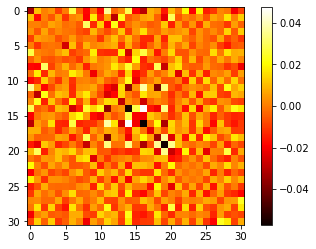

label, 0.0


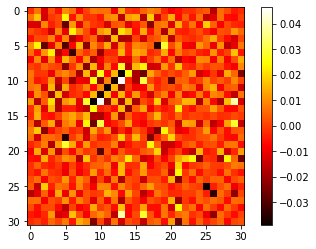

label, 0.0


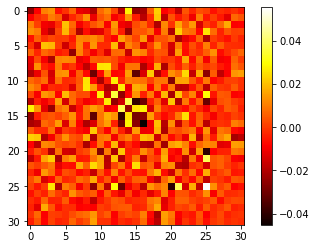

label, 0.0


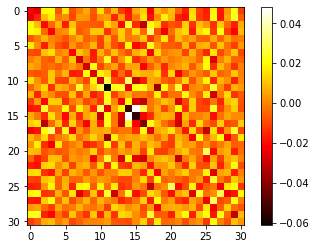

label, 0.0


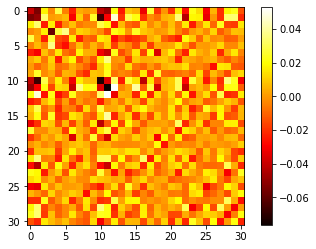

label, 0.0


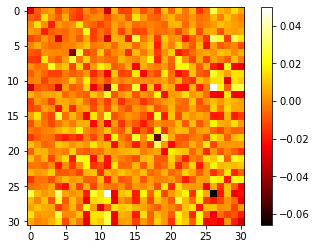

label, 0.0


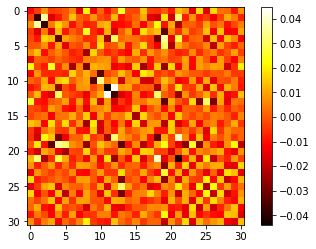

label, 0.0


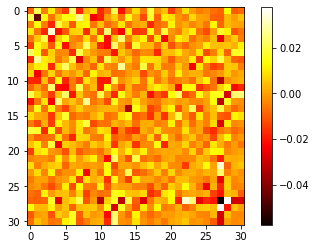

label, 0.0


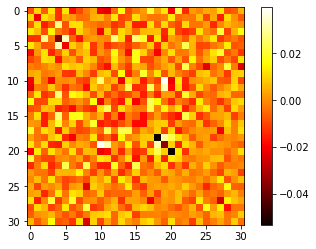

label, 0.0


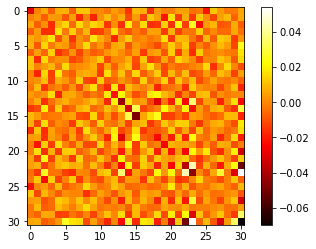

label, 0.0


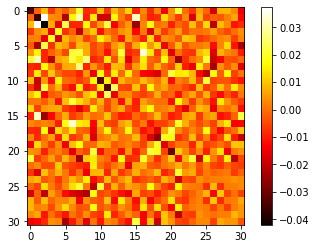

label, 0.0


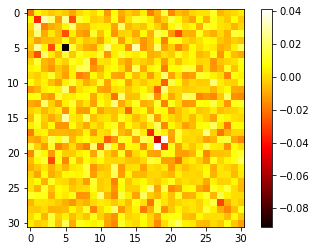

label, 0.0


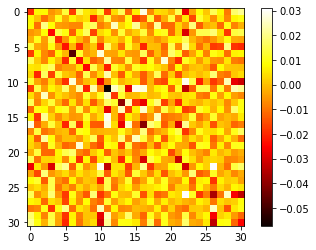

label, 0.0


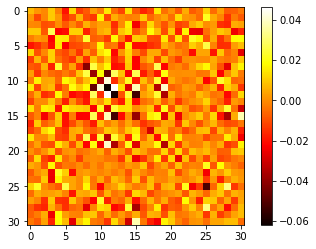

label, 0.0


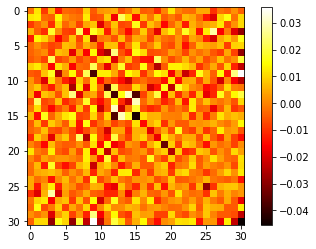

label, 0.0


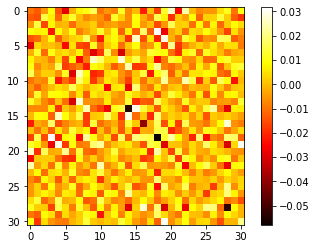

label, 0.0


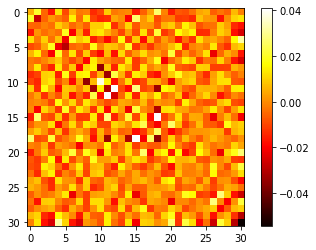

label, 0.0


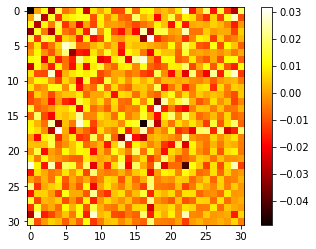

label, 0.0


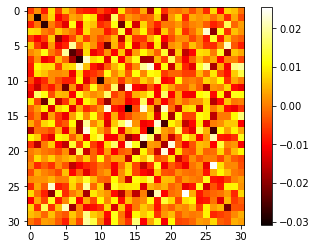

label, 0.0


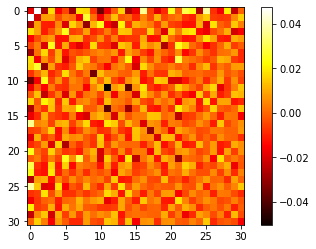

label, 0.0


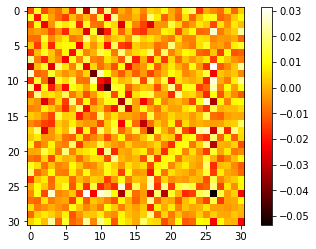

label, 0.0


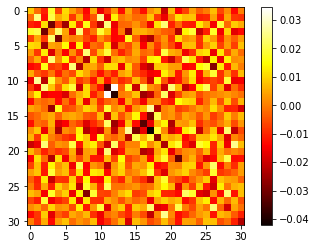

label, 0.0


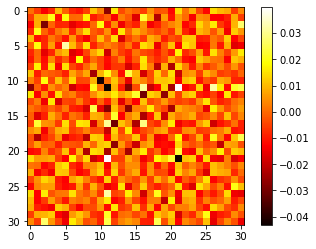

label, 0.0


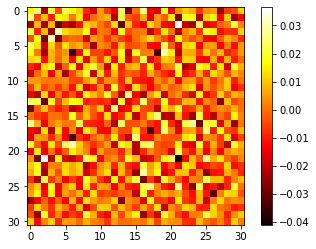

label, 0.0


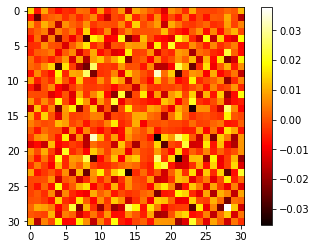

label, 0.0


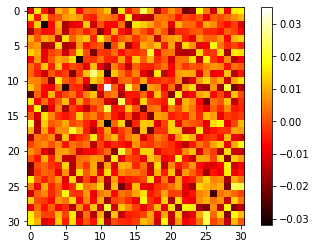

label, 0.0


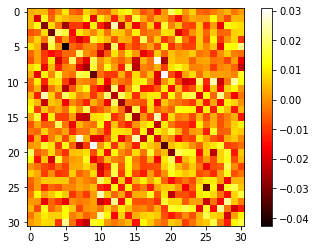

label, 0.0


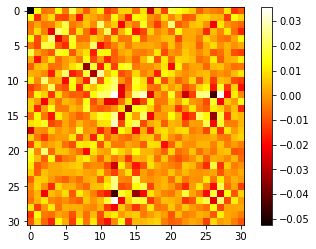

label, 0.0


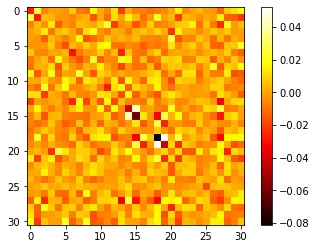

label, 0.0


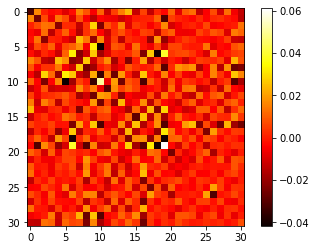

label, 0.0


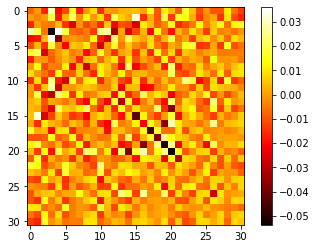

label, 0.0


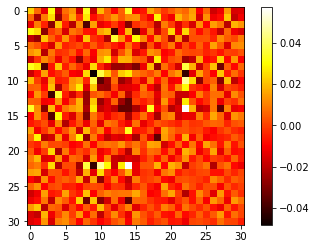

label, 0.0


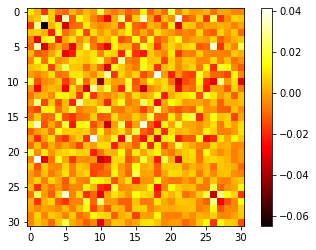

label, 0.0


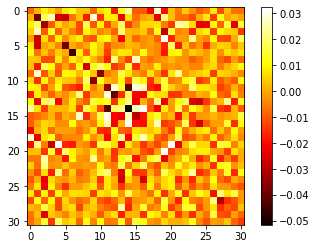

label, 0.0


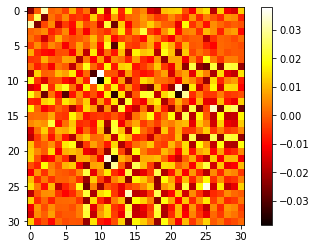

label, 0.0


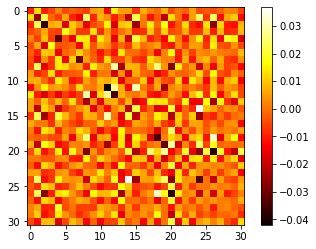

label, 0.0


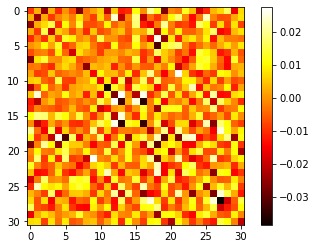

label, 0.0


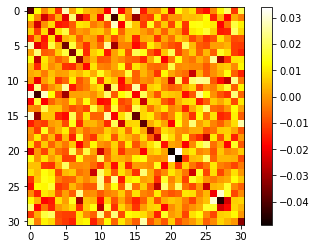

label, 0.0


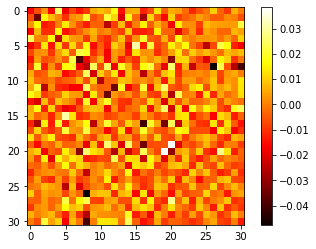

label, 0.0


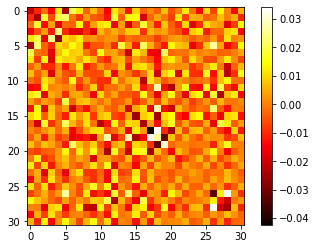

label, 0.0


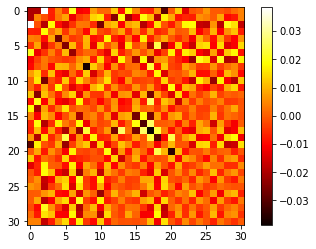

label, 0.0


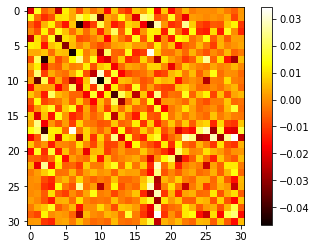

label, 0.0


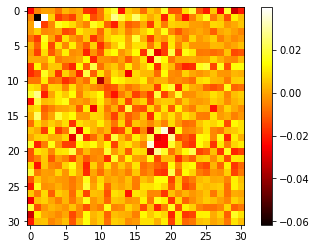

label, 0.0


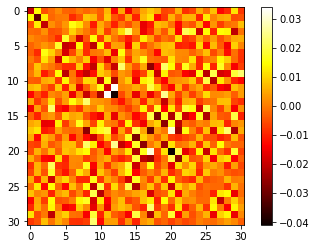

label, 0.0


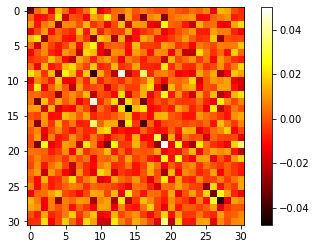

label, 0.0


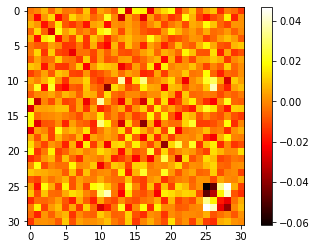

label, 0.0


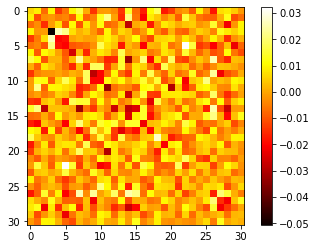

label, 0.0


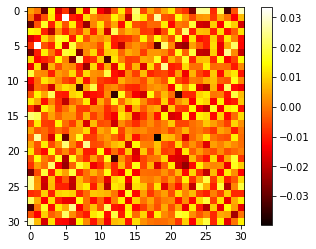

label, 0.0


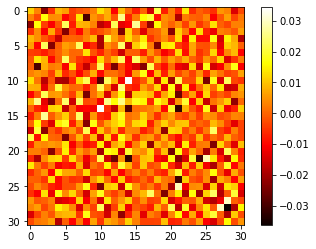

label, 0.0


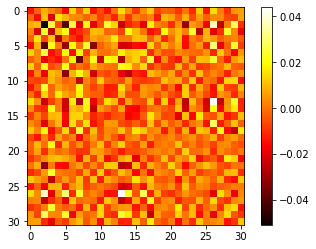

label, 0.0


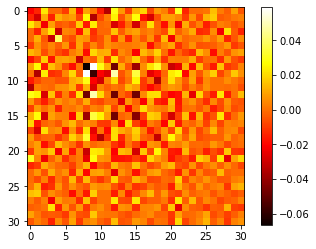

label, 0.0


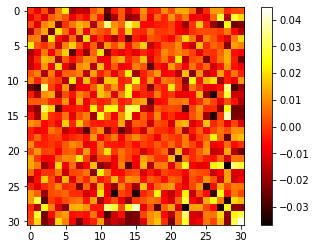

label, 0.0


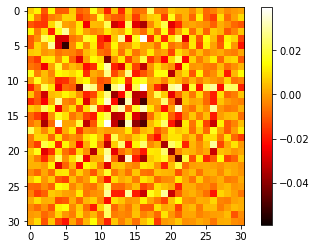

label, 0.0


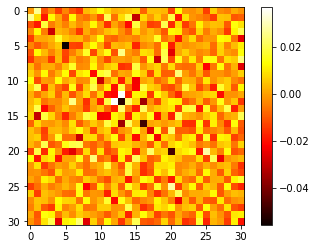

label, 0.0


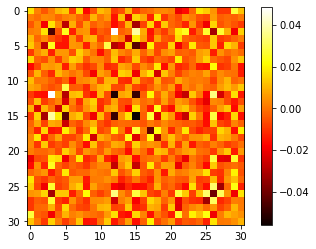

label, 0.0


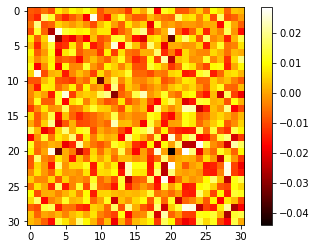

label, 0.0


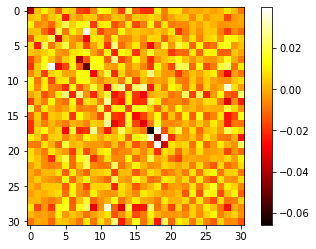

label, 0.0


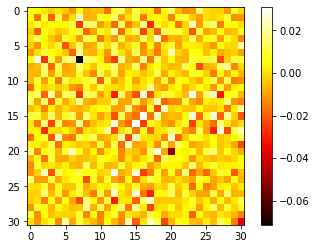

label, 0.0


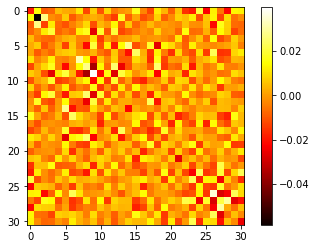

label, 0.0


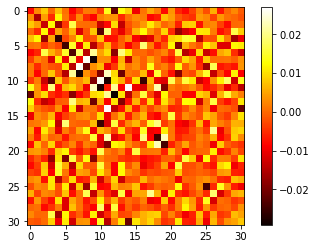

label, 0.0


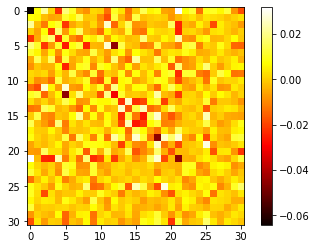

label, 0.0


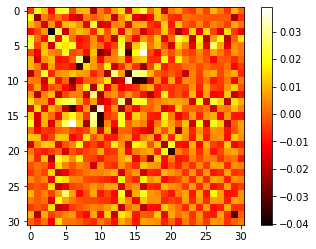

label, 0.0


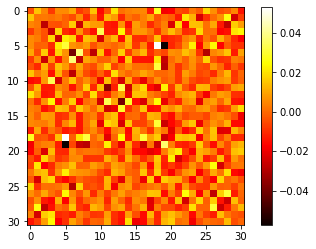

label, 0.0


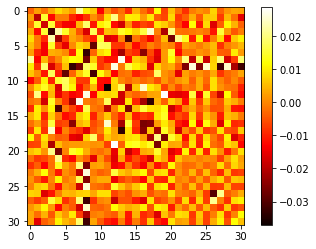

label, 0.0


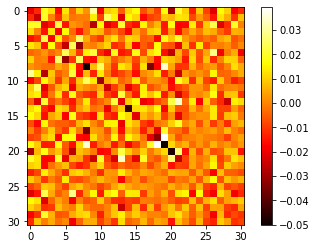

label, 0.0


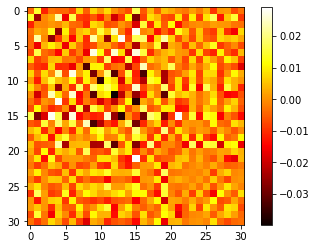

label, 0.0


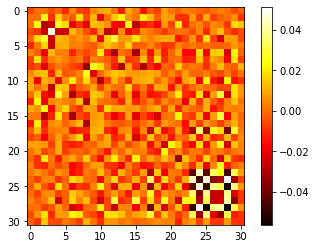

label, 0.0


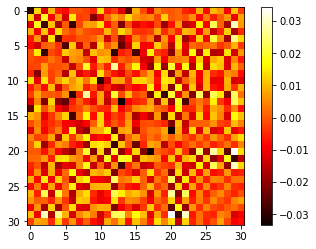

label, 0.0


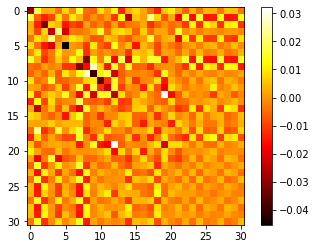

label, 0.0


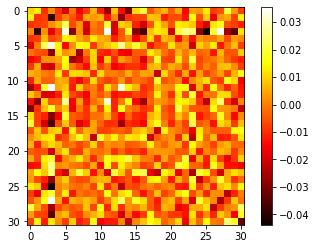

label, 0.0


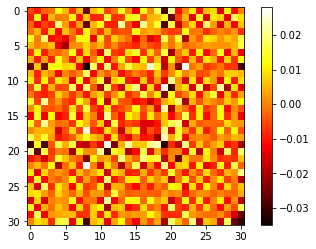

label, 0.0


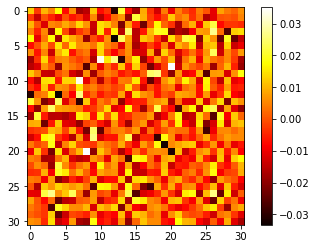

label, 0.0


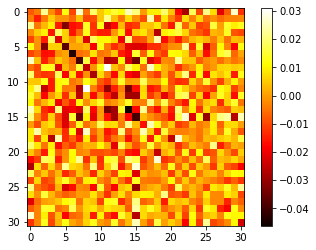

label, 0.0


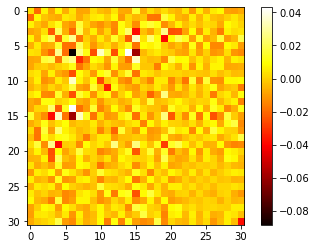

label, 0.0


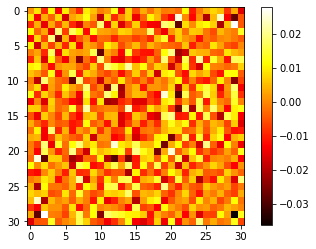

label, 0.0


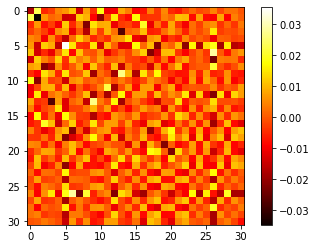

label, 0.0


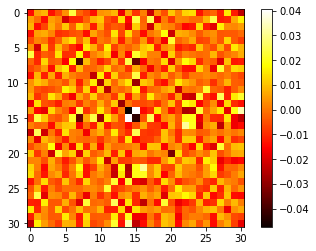

label, 0.0


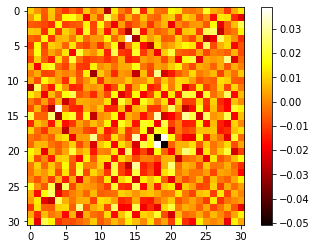

label, 0.0


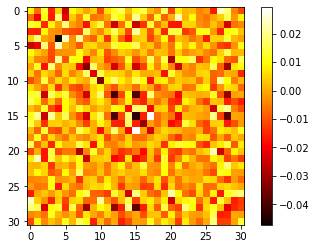

label, 0.0


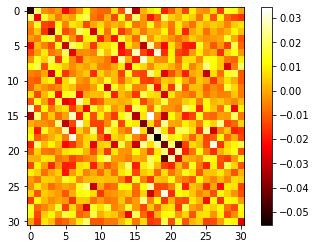

label, 0.0


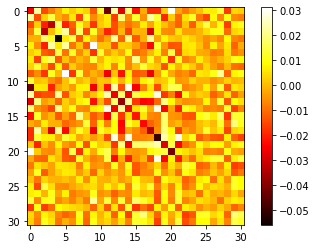

label, 0.0


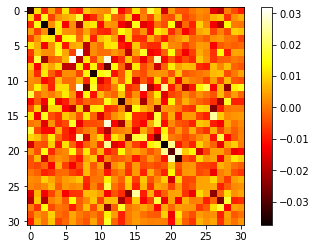

label, 0.0


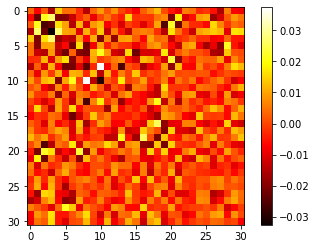

label, 0.0


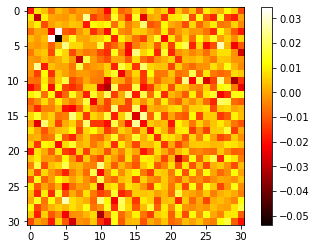

label, 0.0


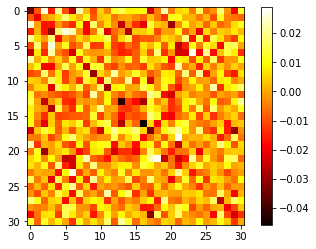

label, 0.0


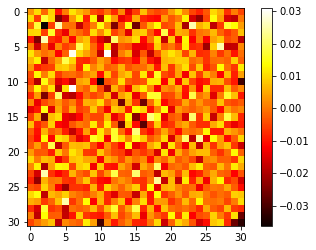

label, 0.0


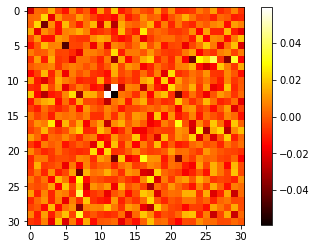

label, 0.0


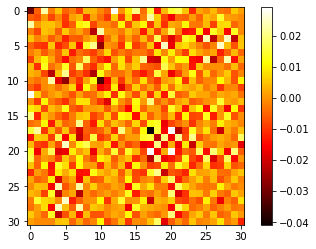

label, 0.0


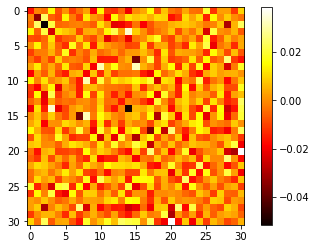

label, 0.0


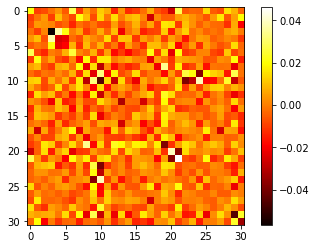

label, 0.0


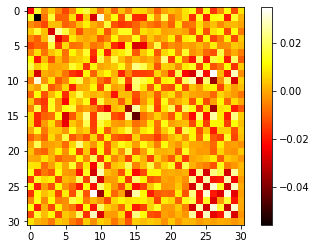

label, 0.0


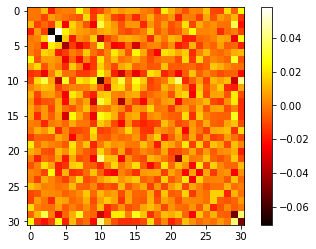

label, 0.0


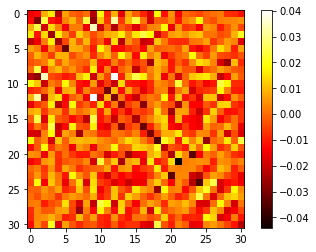

label, 0.0


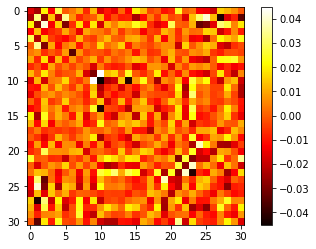

label, 0.0


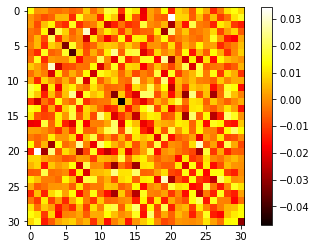

label, 0.0


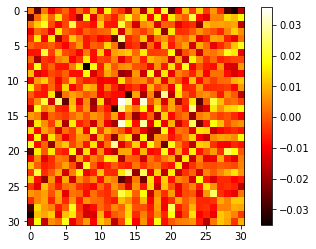

label, 0.0


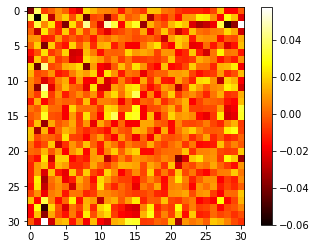

label, 0.0


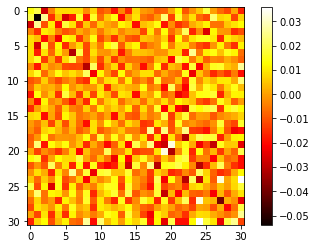

label, 0.0


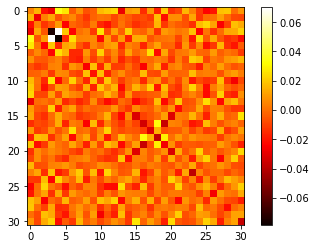

label, 0.0


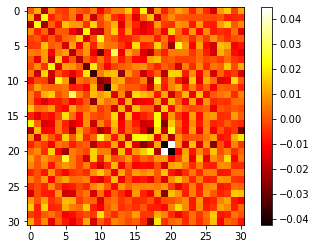

label, 0.0


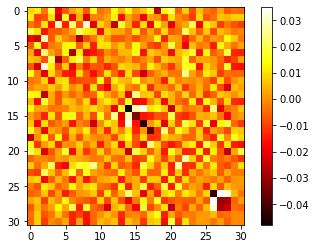

label, 0.0


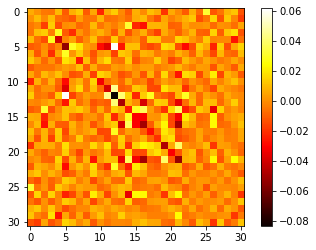

label, 0.0


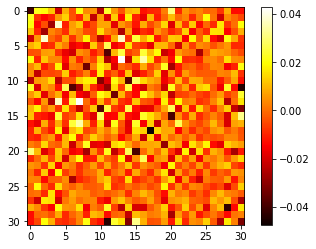

label, 0.0


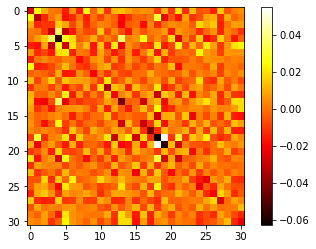

label, 0.0


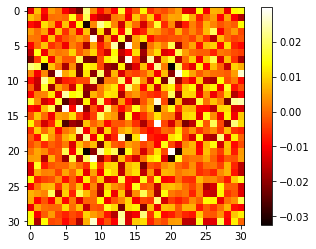

label, 0.0


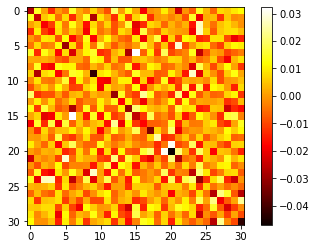

label, 0.0


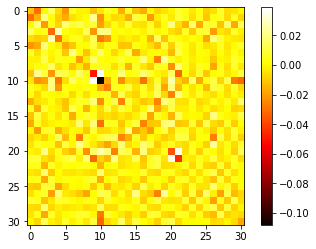

label, 0.0


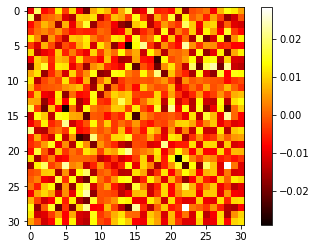

label, 0.0


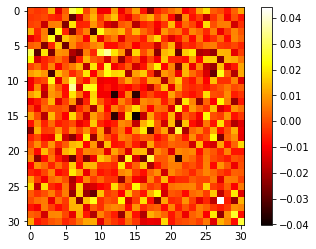

label, 0.0


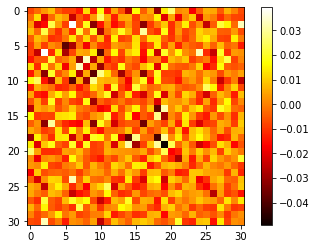

label, 0.0


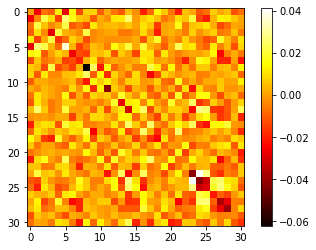

label, 0.0


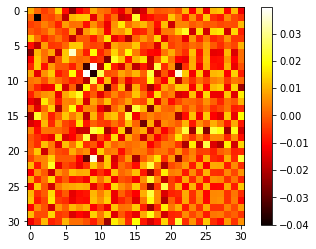

label, 0.0


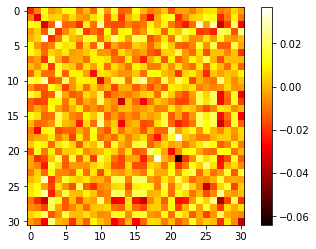

label, 0.0


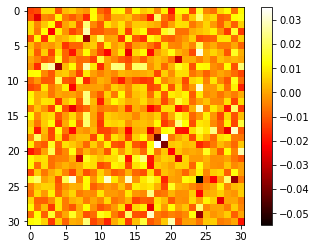

label, 0.0


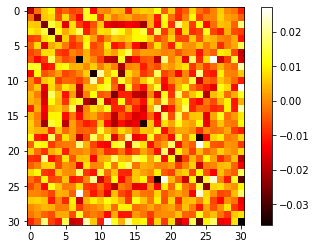

label, 0.0


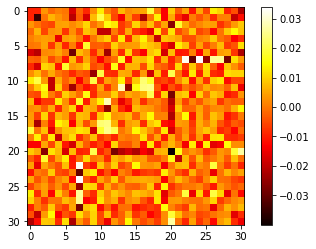

label, 0.0


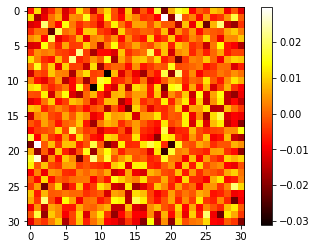

label, 0.0


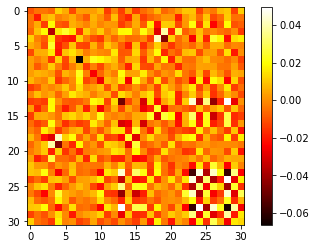

label, 0.0


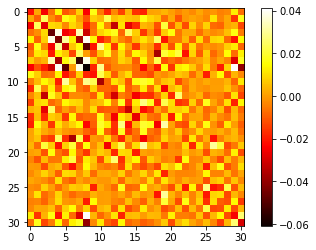

label, 0.0


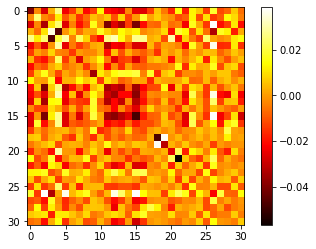

label, 0.0


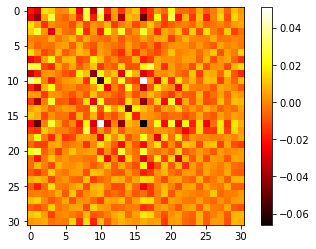

label, 0.0


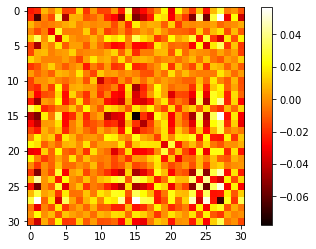

label, 0.0


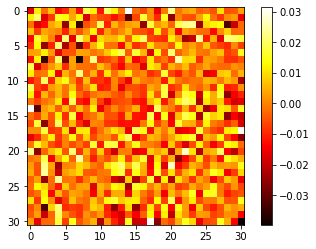

label, 0.0


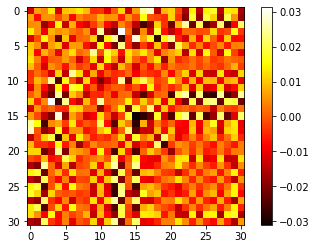

label, 0.0


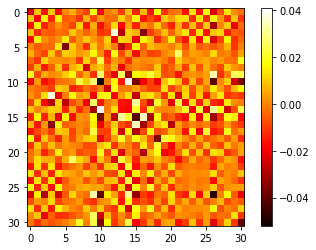

label, 0.0


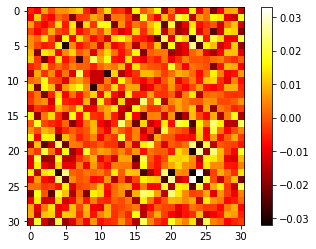

label, 0.0


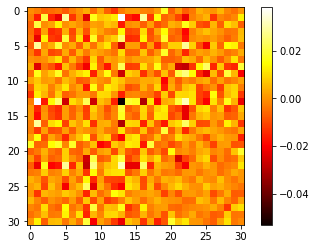

label, 0.0


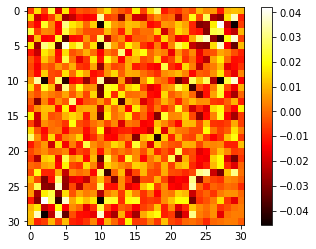

label, 0.0


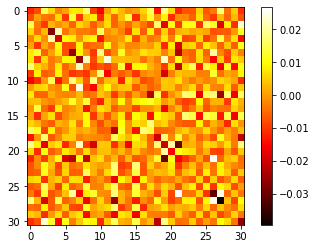

label, 0.0


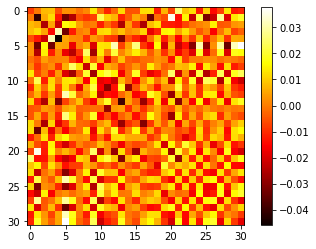

label, 0.0


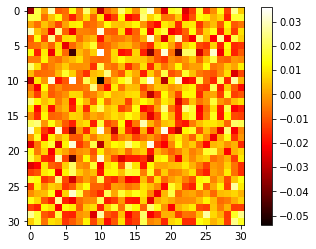

label, 0.0


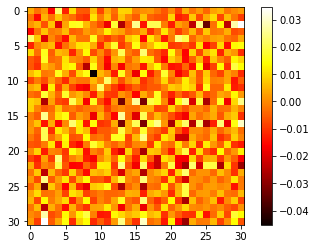

label, 0.0


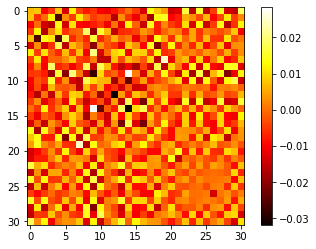

In [14]:
for i in range(500):
    print("label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:].cpu().detach().numpy())

# 

# 

# 

#### Archived code 

In [10]:
A = torch.from_numpy(create_DAD(Araw)).float()
X_train = torch.from_numpy(dm.X_train).float()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
parameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'n_layers': 2,
    'num_epochs': 1000,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(parameters)

{'body': 640, 'M': 1387, 'batch_size': 128, 'n_layers': 2, 'num_epochs': 1000, 'learning_rate': 0.001, 'weight_decay': 0.005}


In [11]:
A = A.to(device)
model = Net(parameters['body'], parameters['n_layers'], F.relu, bias=True).to(device)
input_features = X_train.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'])
criterion = sim_loss()

In [12]:
from torchsummary import summary
print(model)
summary(model, [(31,640), (31,31)])

Net(
  (head): GCN (640,640)
  (layers): ModuleList(
    (0): GCN (640,640)
  )
  (tail): SimularityMatrix (1280)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GCN-1              [-1, 31, 640]         410,240
               GCN-2              [-1, 31, 640]         410,240
  SimularityMatrix-3               [-1, 31, 31]           1,280
Total params: 821,760
Trainable params: 821,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 72.73
Forward/backward pass size (MB): 0.31
Params size (MB): 3.13
Estimated Total Size (MB): 76.18
----------------------------------------------------------------


In [18]:
n_epochs = parameters['num_epochs']
batch_size = parameters['batch_size']
from tqdm import tqdm
model.train()
for epoch in range(1, n_epochs+1):

    permutation = torch.randperm(input_features.shape[0])

    for i in tqdm(range(0,input_features.shape[0], batch_size)):
        model.train()
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size] if i+batch_size < input_features.shape[0] else permutation[i:] 
        batch_x= input_features[indices, :,:]

        sim_matrix = model(batch_x, A).to(device)
        train_loss = criterion(sim_matrix, A)
        train_loss.backward()
        optimizer.step()
        print("Epoch:", epoch, "  Batch:", int((i/batch_size)+1),"of size",batch_size, "  Train loss:", train_loss, end="\r")
    print()

  0%|          | 0/11 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 8.00 GiB total capacity; 4.23 GiB already allocated; 0 bytes free; 4.52 GiB reserved in total by PyTorch)

In [14]:
#save checkpoint
import shutil
def save_ckp(state, f_path):
    torch.save(state, f_path)

In [15]:
checkpoint = {
    'parameters': parameters,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'cumepoch': 1000
}
save_ckp(checkpoint, "models/checkpoint1000epoch.pt")

In [16]:

model.eval()
test_pred = model(input_features[10:20, :, :], A)

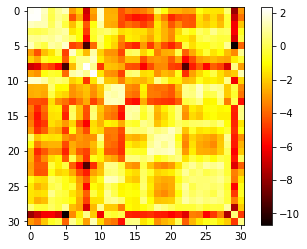

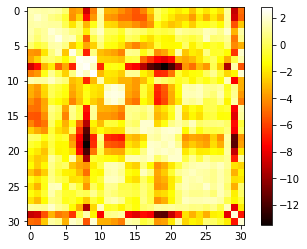

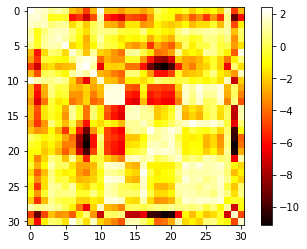

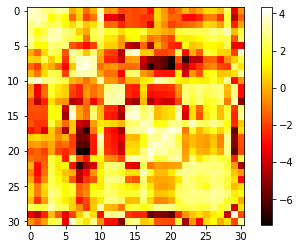

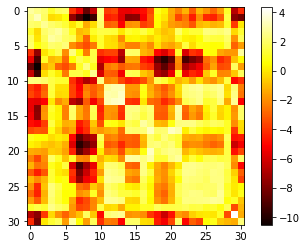

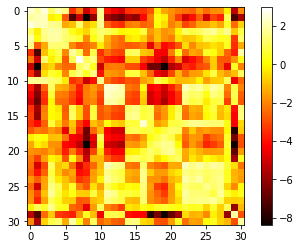

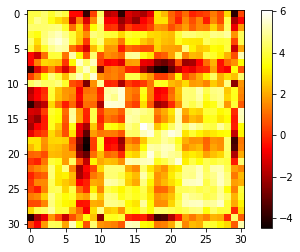

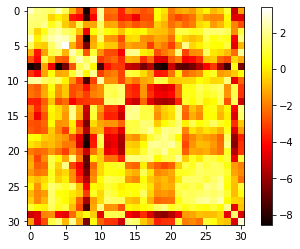

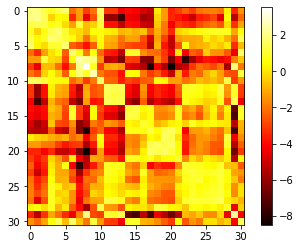

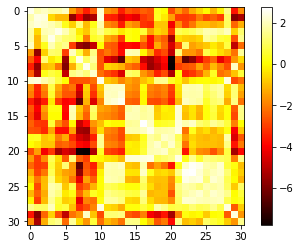

In [17]:
for i in range(10):
    show_heat_map(test_pred[i,:,:].cpu().detach().numpy())

In [20]:
#save the model
torch.save(model, "models/draft_2l_GCN2wn.pkl")

## Some testing and debugging functions

In [ ]:
def fcn(in_features, u):
        norm_u = (u - torch.mean(u, dim=2, keepdim=True))
        print(norm_u)
        print(((1/(in_features-1)) * torch.sum(norm_u**2, dim = 2, keepdim = True))**(1/2))
        return norm_u/(((1/(in_features-1)) * torch.sum(norm_u**2, dim = 2, keepdim = True))**(1/2))


A = torch.tensor([[[1, -1, 3], [2, -2, 1]],[[2, -1, 1], [3, -2, 1]]]).float()
print(A, A.shape)
print(fcn(3, A))

In [ ]:
def forward(sim_matrix, A):
        A_tf = (A!=0)
        print("A_tf:", A_tf)
        abs_N = torch.sum(A_tf, dim = 1, keepdim = True)
        print("abs_N:", abs_N)
        logexp_S = torch.log(torch.sum(torch.exp(sim_matrix), dim = 2, keepdim = True))
        print(logexp_S)
        obj_matrix = A_tf*(sim_matrix - abs_N * logexp_S)
        print(obj_matrix)
        return -torch.sum(obj_matrix)

sim_matrix = torch.tensor([[[1, -1, 3], [2, -2, 1],[1, 2, 3]],[[2, -1, 1], [3, -2, 1],[2, -1, 1]]]).float()
print(sim_matrix)
A = torch.tensor([[0.1,0,0.5],[0,0.7,0],[0.1,0,0.5]])
print(A)

print(forward(sim_matrix, A))

In [ ]:
z = torch.tensor([[[1, -1, 3], [2, -2, 1],[1, 2, 3]],[[2, -1, 1], [3, -2, 1],[2, -1, 1]]]).float()
print(torch.reshape(z[:,1,:], (z.shape[0],1,z.shape[2])))

In [ ]:
weight = torch.tensor([[1],[1],[2]])
print(weight.shape, torch.diag(torch.squeeze(weight)), torch.diag(weight).shape)

In [ ]:
for x in range(1000):
    print(x, end='\r')
print()